In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from proj1_helpers import *
from helpers2 import *
from preprocessing import *

In [24]:
#data_folder = Path("../data/")
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Data analysis

In [25]:
print(y)
print(np.shape(y))
print(np.shape(tX))
print(tX.dtype)
print(y.dtype)

[ 1. -1. -1. ...  1. -1. -1.]
(250000,)
(250000, 30)
float64
float64


In [26]:
feature_names = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 
                 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 
                 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 
                 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
                 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
                 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

for i, name in enumerate(feature_names):
    print(i, feature_names[i])


0 DER_mass_MMC
1 DER_mass_transverse_met_lep
2 DER_mass_vis
3 DER_pt_h
4 DER_deltaeta_jet_jet
5 DER_mass_jet_jet
6 DER_prodeta_jet_jet
7 DER_deltar_tau_lep
8 DER_pt_tot
9 DER_sum_pt
10 DER_pt_ratio_lep_tau
11 DER_met_phi_centrality
12 DER_lep_eta_centrality
13 PRI_tau_pt
14 PRI_tau_eta
15 PRI_tau_phi
16 PRI_lep_pt
17 PRI_lep_eta
18 PRI_lep_phi
19 PRI_met
20 PRI_met_phi
21 PRI_met_sumet
22 PRI_jet_num
23 PRI_jet_leading_pt
24 PRI_jet_leading_eta
25 PRI_jet_leading_phi
26 PRI_jet_subleading_pt
27 PRI_jet_subleading_eta
28 PRI_jet_subleading_phi
29 PRI_jet_all_pt


The training data set is composed of : 
* a y vector of length 250'000 and type float
* a tX float matrix of 250'000 rows and 30 columns

It means that our data set is composed of 250'000 different obsevations of 30 different features. In the rest of the notebook, we name the features by their index number. So, it means the indexes span from the feature 0 to the feature  29.

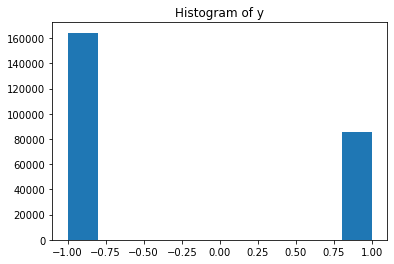

In [27]:
plt.hist(y)
plt.title('Histogram of y')
plt.show()

There is more y = -1 than y = 1 in the data, so there is more y = 'b' (background) than y = 's' (signal). So, we have to pay attention to normalize the data in order to compare them in the next plots.

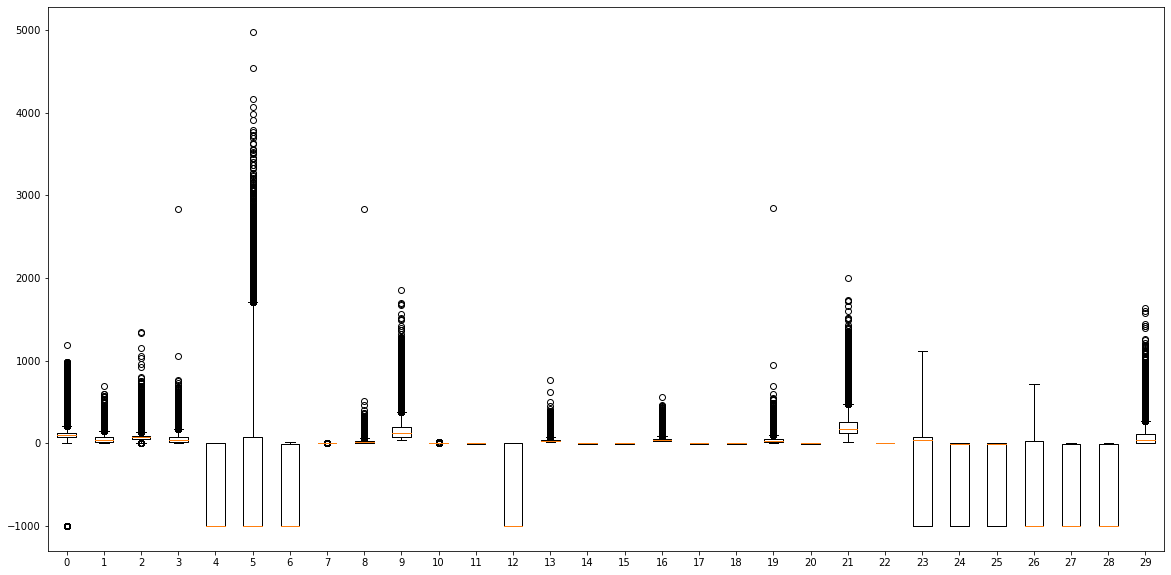

In [28]:
plt.figure(figsize=(20, 10))
ind = np.arange(30)
plt.boxplot(tX[:,], labels = ind)

plt.show()

There are many outliers depending on the feature. There are also feature that has a long interquantile range. Perhaps we have to treat these features in order to be more efficient in our futur predictions. Let's do more plots to be have a better idea :

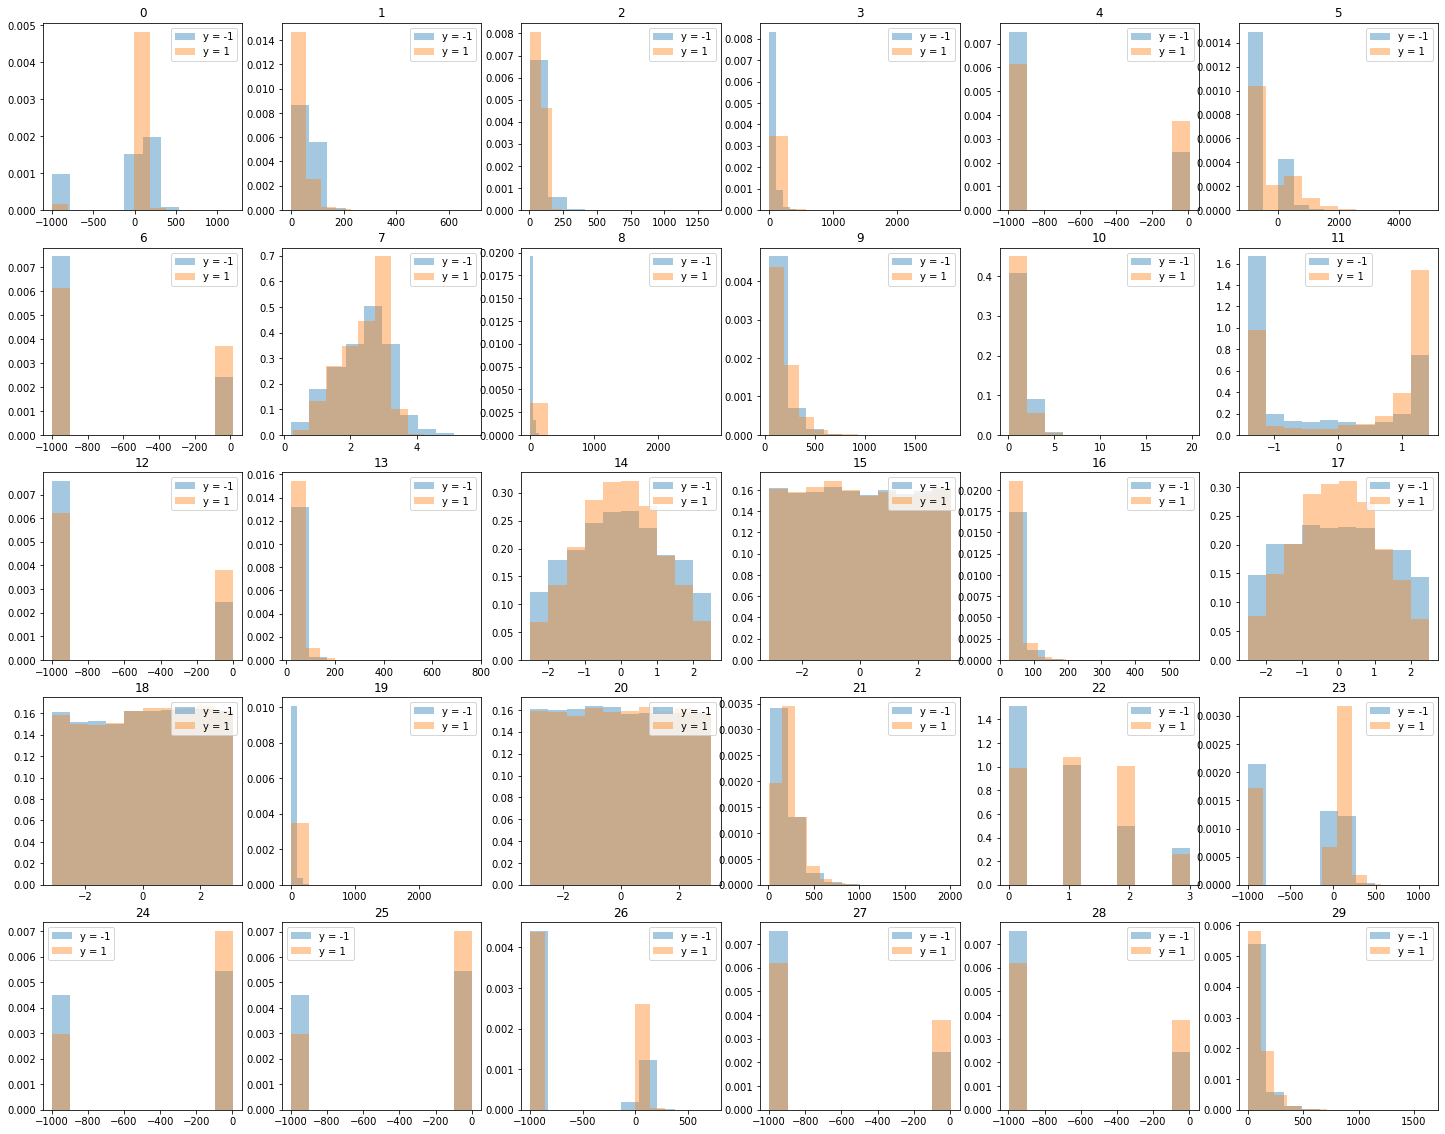

In [29]:
ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

fig, axs = plt.subplots(5, 6, figsize=(25,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].hist(tX_2[:,n], alpha=0.4, density=True, label=['y = -1'])
        axs[i,j].hist(tX_1[:,n], alpha=0.4, density=True, label=['y = 1'])
        axs[i,j].legend()
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

By plotting the normalized histograms of the features with a color for each y, we can see that there are useless features as they have almost the same distribution for y=1 than for y = -1. Thus, we can cut features 15, 18 and 20. 


There are also features that are very inequally distributed with values that are about -1000 and values around 0 ; it can be problematic for the prediction with such a large gap between values of a single distribution. Moreover, there is not a big difference in the distribution of y=1 and y=-1. Maybe it can be useful to put off these big negative values of these features. The features in question are : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27 and 28.


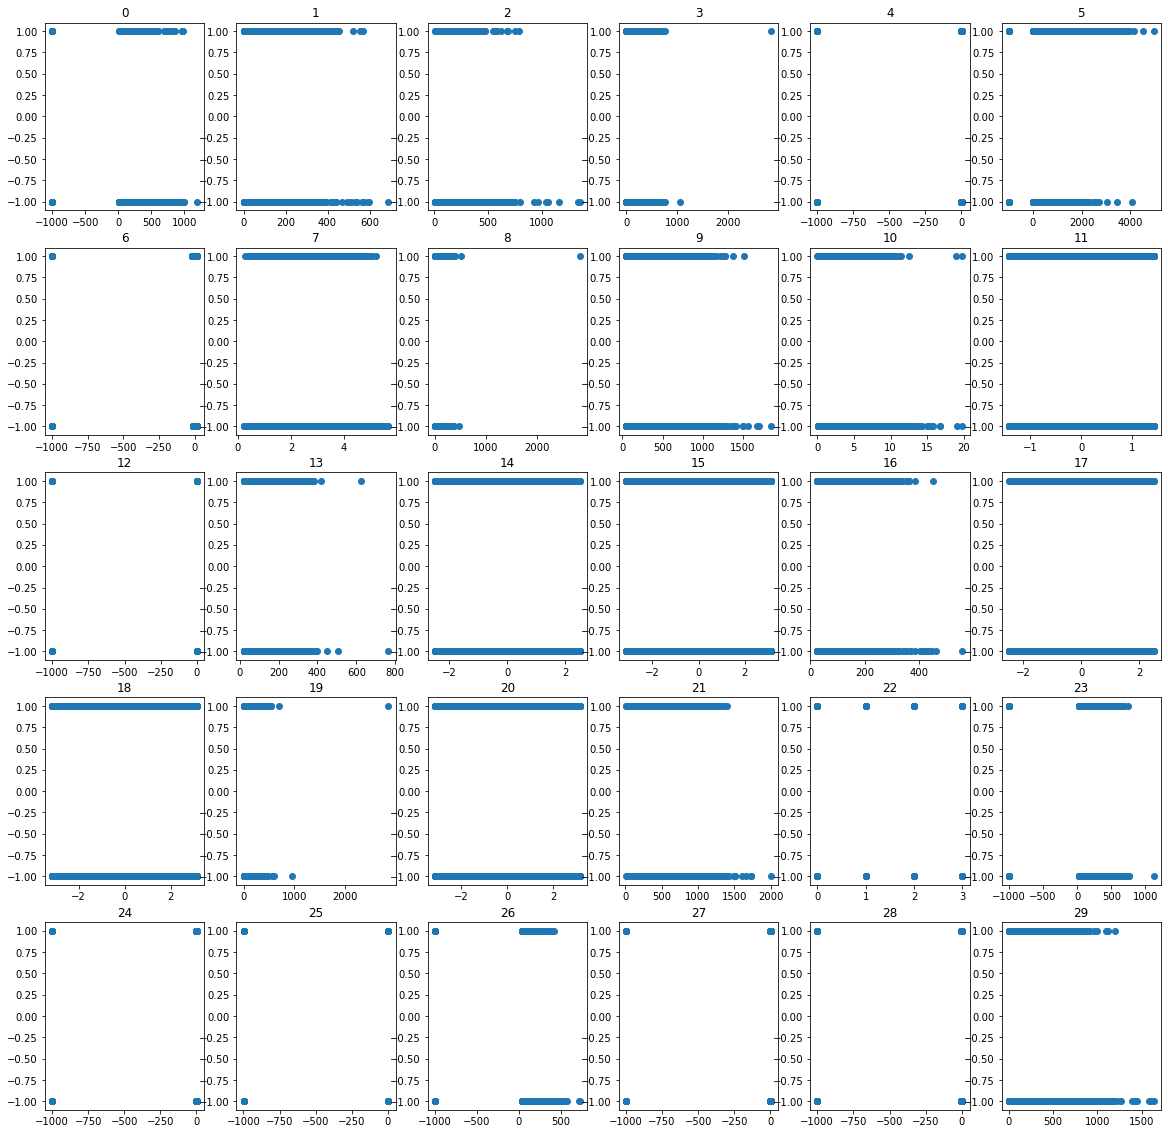

In [30]:
fig, axs = plt.subplots(5, 6, figsize=(20,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].scatter(tX[:,n], y)
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

These plots confirm the obsevations that we made in the previous plot ; no difference of the distribution of y for features 15, 18, 20 and very large gap in the distributions of features : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28. We can also see that the feature 22 has an atypical distribution.

## Data filtering

### Outliers

In [31]:
def nb_outliers(tX, outlier) : 
    sum = 0
    nb_outliers = []
    for col in range(tX.shape[1]) :
        sum = np.where(tX[:,col] == outlier)[0].shape
        nb_outliers.append(sum)   
    print(nb_outliers)
    print(np.where(tX==outlier)[0].shape)

out = -999

print('number of -999 in the entire matrix :')
nb_outliers(tX, out)

ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

print('number of -999 in the rows where y = 1 :')
nb_outliers(tX_1, out)
print('number of -999 in the rows where y = -1 :')
nb_outliers(tX_2, out)

number of -999 in the entire matrix :
[(38114,), (0,), (0,), (0,), (177457,), (177457,), (177457,), (0,), (0,), (0,), (0,), (0,), (177457,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (99913,), (99913,), (99913,), (177457,), (177457,), (177457,), (0,)]
(1580052,)
number of -999 in the rows where y = 1 :
[(2835,), (0,), (0,), (0,), (53202,), (53202,), (53202,), (0,), (0,), (0,), (0,), (0,), (53202,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (25492,), (25492,), (25492,), (53202,), (53202,), (53202,), (0,)]
(451725,)
number of -999 in the rows where y = -1 :
[(35279,), (0,), (0,), (0,), (124255,), (124255,), (124255,), (0,), (0,), (0,), (0,), (0,), (124255,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (74421,), (74421,), (74421,), (124255,), (124255,), (124255,), (0,)]
(1128327,)


We have a problem with features  0, 4, 5, 6, 12, 23, 24, 25, 26, 27 and 28. They are inequally distributed; they have a lot of -999 values and the rest is values around 0. So, here we can see how much of these -999 there are. We can see that the -999 appear only in the features that we identified with the histograms. It seems that there is a correlation between features as many features have the same number of -999. We can also see that there is more -999 in the obsevations where y=-1, so we have to take this into account when we filter the data. As there are many -999, we can't delete the rows where there is -999 because we will lose too much information.
After checking the documentation, we found that the number of -999 values is linked to the feature 22. Thus, we create a function to separate the data in sets according to the feature 22 value. Moreover, verification with the next histogramms showed us that some features were then constant in some sets. We delete these features.

In [32]:
def histograms(y, tX):
    ind_1 = np.where(y == 1)
    ind_2 = np.where(y == -1)
    tX_1 = tX[ind_1[0],:]
    tX_2 = tX[ind_2[0],:]

    fig, axs = plt.subplots(5, 6, figsize=(25,20))

    n = 0
    for i in range(5) :
        for j in range(6) :
            axs[i,j].hist(tX_2[:,n], alpha=0.4, density=True, label=['y = -1'])
            axs[i,j].hist(tX_1[:,n], alpha=0.4, density=True, label=['y = 1'])
            axs[i,j].legend()
            axs[i,j].set_title(n)
            n = n + 1
            if n>=tX.shape[1]: break
        if n>=tX.shape[1]: break
    plt.show()

We separate the dataset into 3 sets according to the PRI_jet_num feature. Features with constant values and column 22 are deleted. So, this function gets also rid of the features whose ratio of -999 is 1 in the sets

Set 1
[False False False False False False False False False False False False
 False False False False False False]


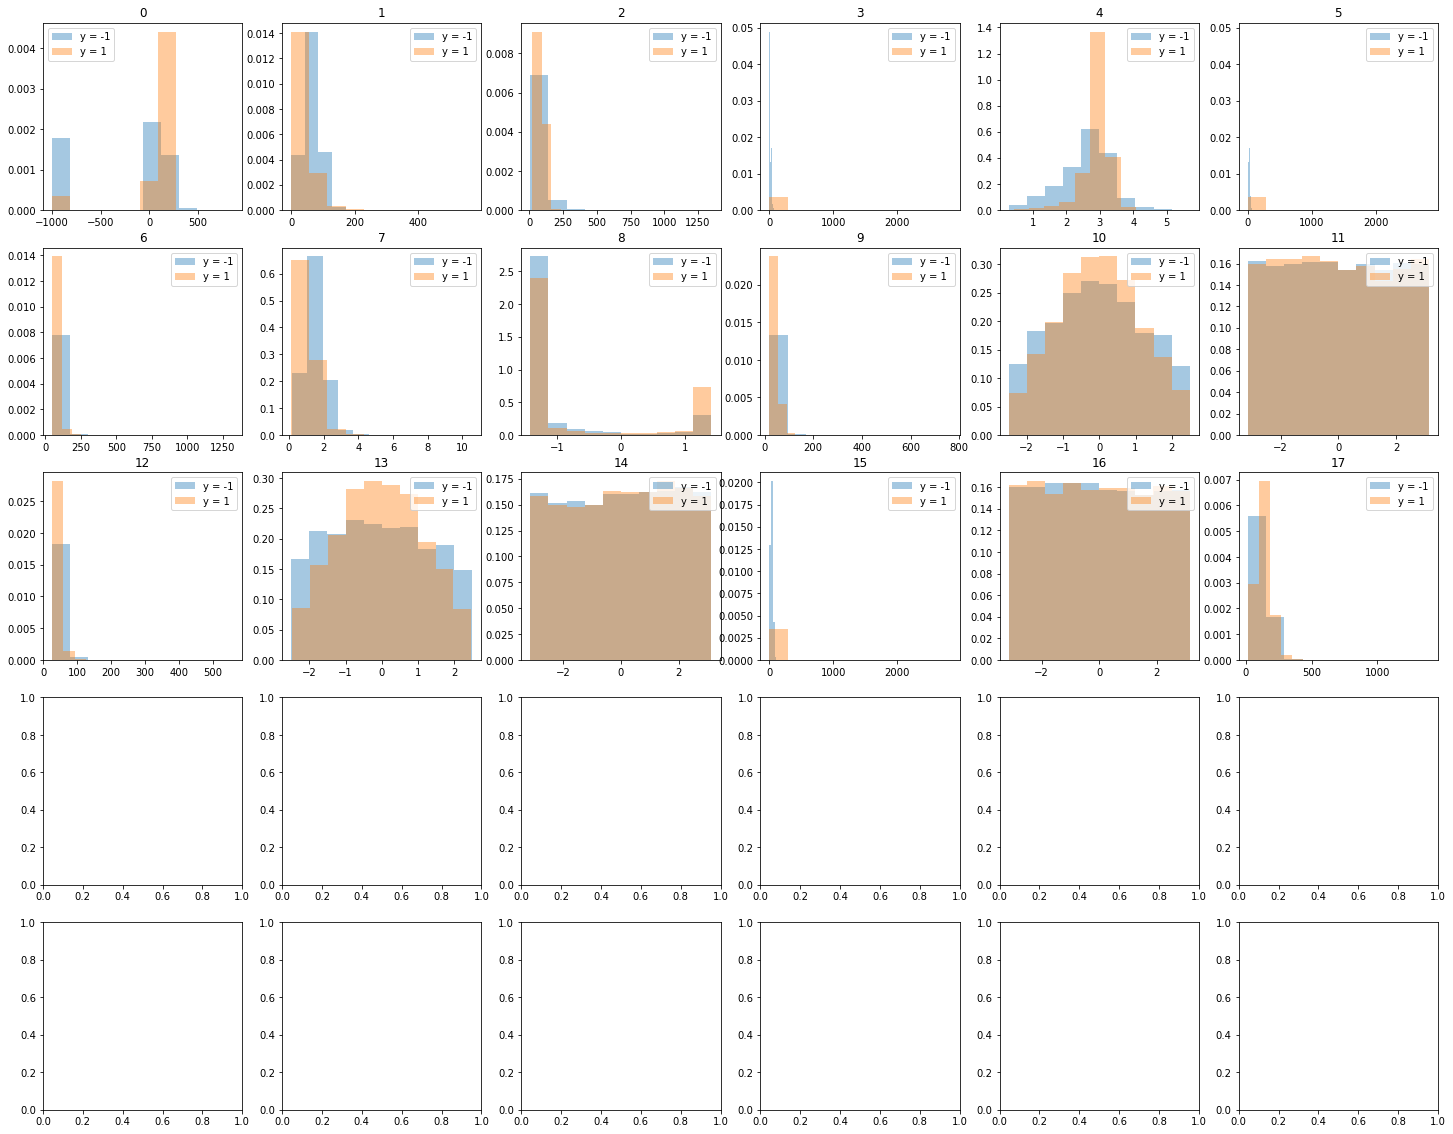


Set 2
[False False False False False False False False False False False False
 False False False False False False False False False False]


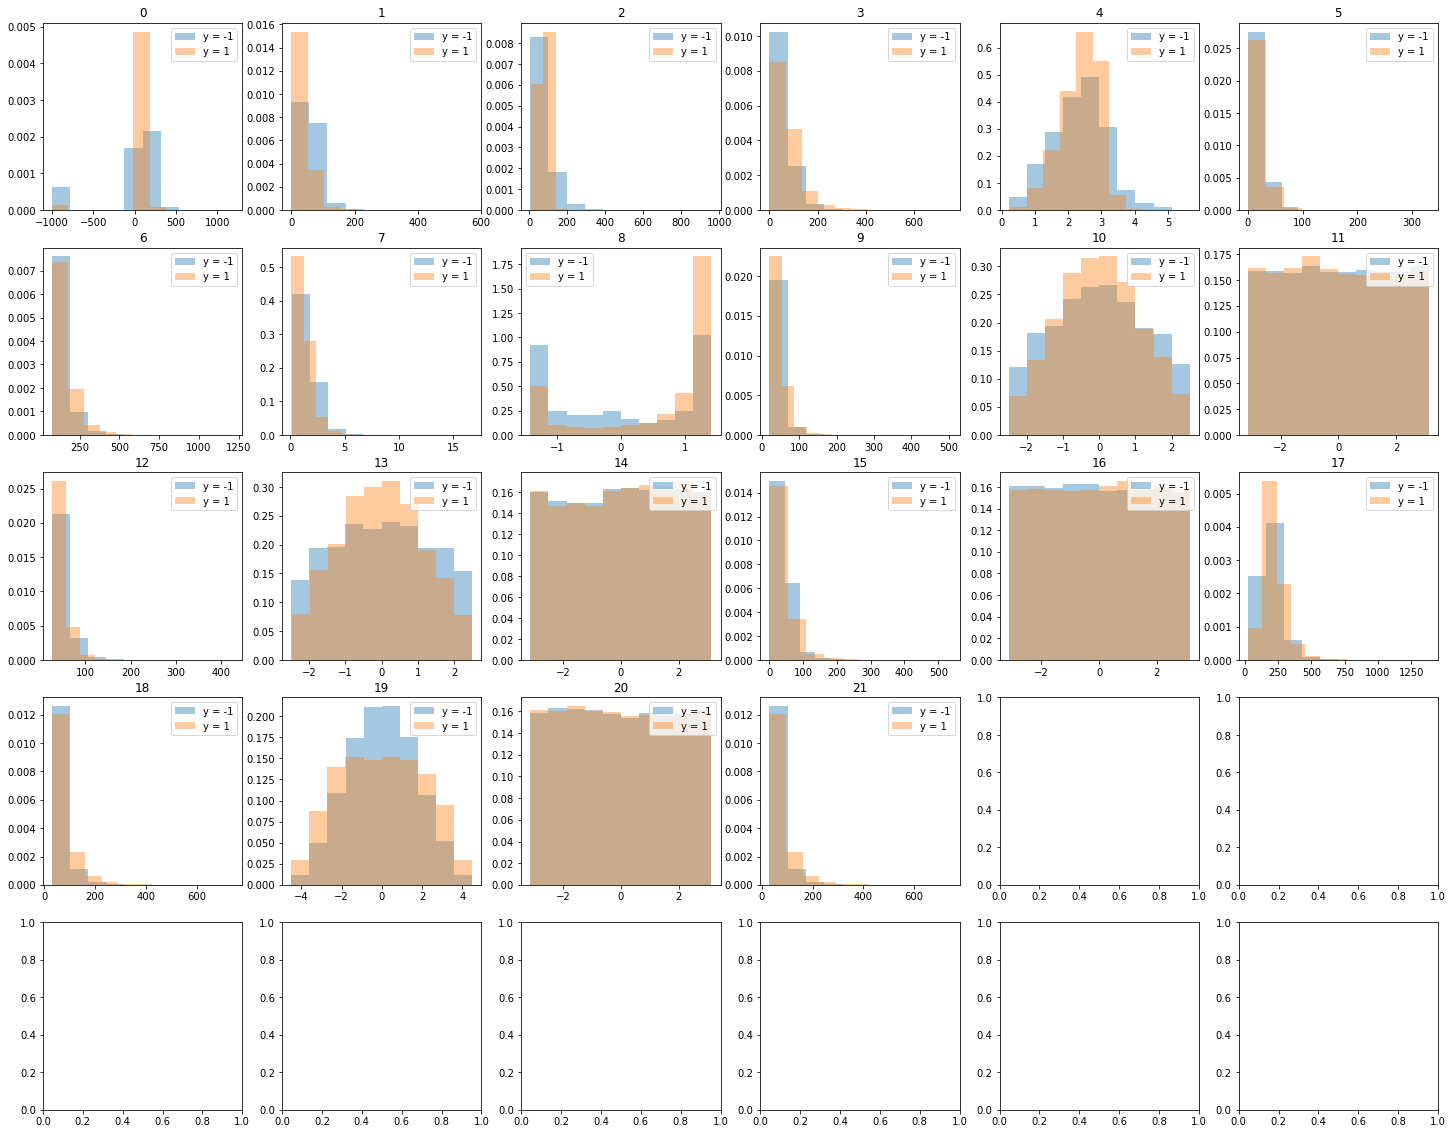


Set 3
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


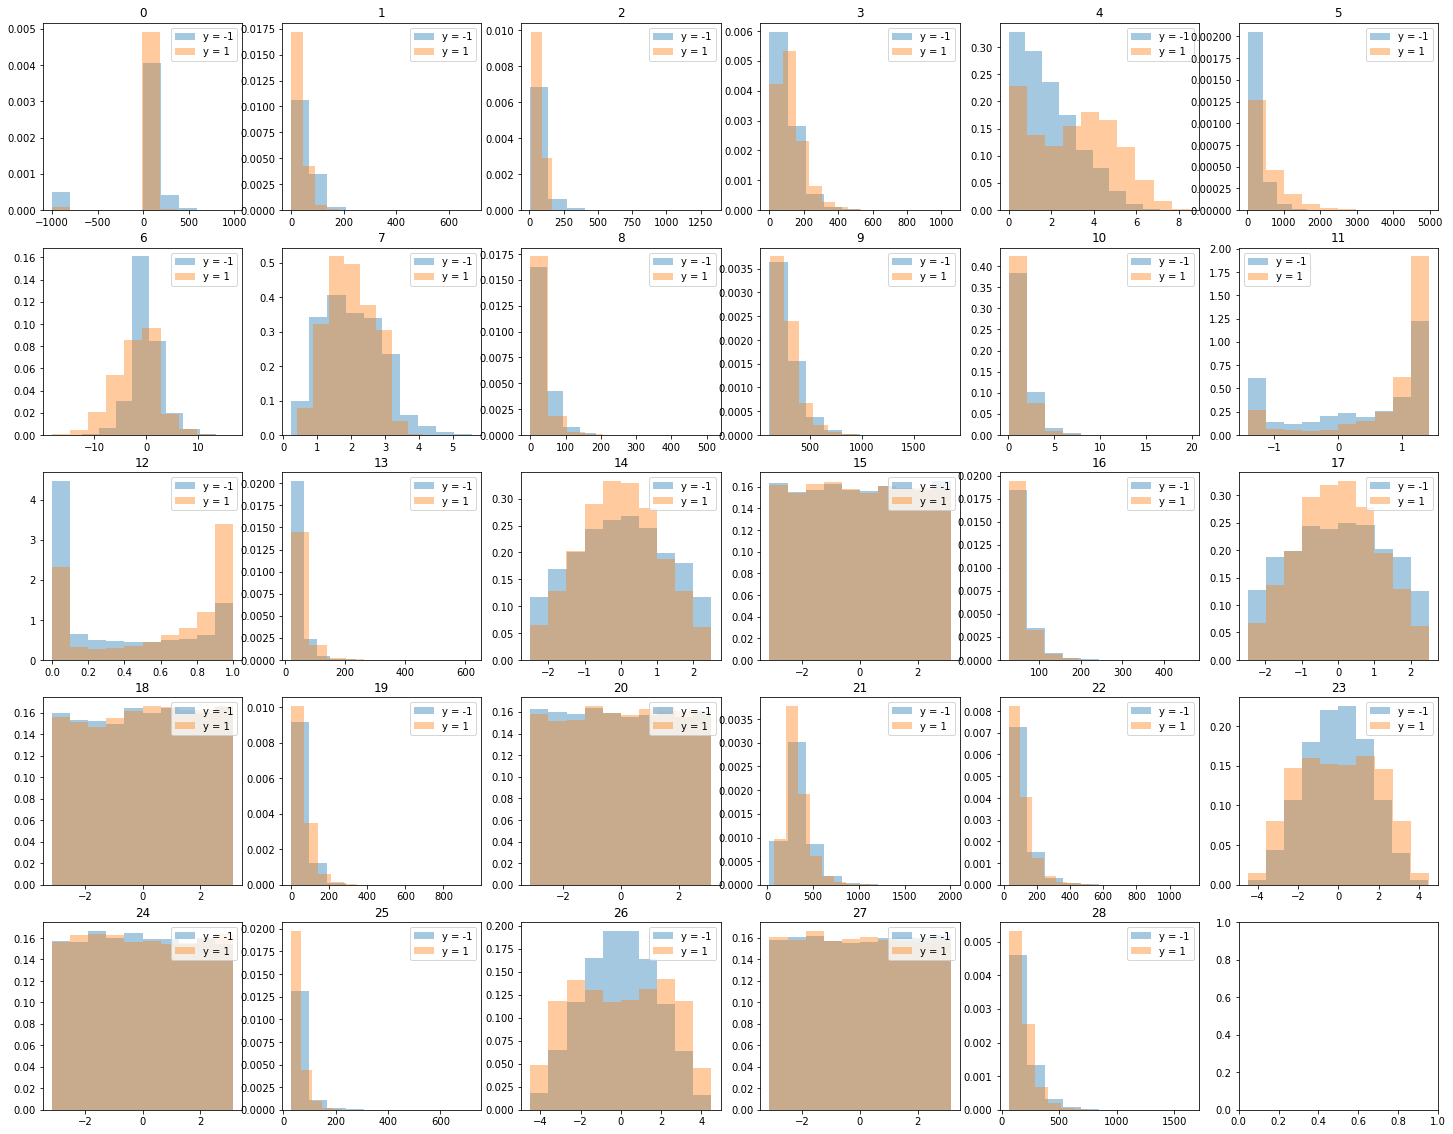

In [33]:
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y, ids)

print('Set 1')
print(np.all(set1_x==set1_x[0], axis = 0))
histograms(set1_y, set1_x)

print('\nSet 2')
print(np.all(set2_x==set2_x[0], axis = 0))
histograms(set2_y, set2_x)

print('\nSet 3')
print(np.all(set3_x==set3_x[0], axis = 0))
histograms(set3_y, set3_x)

In order to filter the data, we want to get rid of the -999 values left, but we can't just delete the rows. So, we have the idea to replace the -999 by the mean of the rest of values of the feature. As there is a significant difference of amount of -999 in between y=1 and y=-1 in certain features, we calculate the mean for the rows where y = 1 and y = -1 separatly.

Then, we want to change the distribution of the data. 
We standardize the data. It can be a good idea because the features are not all in the same range of values and it can create disproportionality between the importance of the features.
Some features have a skewed distribution so a log tranformation will be applied. The features in question are 1, 2, 5, 9, 10, 13, 16, 19, 21, 23, 26 and 29.

As we see above in the histograms, some features seem to be useless as they have a similar distribution between the y = 1 and y = -1. So, it is useful to have function that cut or keep some parameters.

## Fonctions 

In [34]:
from implementations import *
from cross_validation import *
to_log = [1, 2, 5, 9, 10, 13, 16, 19, 21, 23, 26, 29]

### Least squares

The best results for least squares regression is with the tX matrix which is standardize, filter with filtering_with_mean_bis function and whose features 15, 18 and 20 are cut :

In [35]:
tX_cut = cut(tX, [15,18,20])
x_essai = std(filtering_with_mean_bis(tX_cut, y))
degrees = np.arange(1,11)
# Cross-validation on the degrees
degree_opt, _ = best_degree_selection(y, x_essai, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
# Best degree model
tX_poly = build_poly(x_essai, degree_opt)
w_ls, loss_ls = least_squares(y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_ls = degree_opt

best rmses [0.80948237155391, 0.8367349211100976, 2.1056028200718133, 7.584563594896589, 112.96122840799619, 21513.2210588402, 640516.9061716219, 17066015.327445216, 849823489.373302, 11729544171.634888]
Cross validation finished: optimal degree 1
Least square loss rmse 0.572303010058039


The least squares best model on the entire is degree 1 ; its accuracy is : 0.606. Let's try the same model but applied to the 3 different sets according to the PRI_jet_num parameter thanks to the separate_sets function. We should normally improve our results : 

In [36]:
tX_cut = cut(tX, [15,18,20])

# Separation into set according to the PRI_jet_num parameter, as it is the 22th column of the entire matrix
# if we cut 3 paramaters before the 22th, PRI_jet_num is the 22-3th now
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_cut, y, ids, 22-3)

def best_filtering_ls(set_x, set_y) :
        set_x = std(filtering_with_mean_bis(set_x, set_y))
        return set_x

set1_x_ls = best_filtering_ls(set1_x, set1_y)

set2_x_ls = best_filtering_ls(set2_x, set2_y)

set3_x_ls = best_filtering_ls(set3_x, set3_y)

Let's do least square regression for each set : 

In [37]:
degrees = np.arange(1,11)
# Cross-validation on the degrees
degree_opt, _ = best_degree_selection(set1_y, set1_x_ls, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
# Best degree model 
tX_poly = build_poly(set1_x_ls, degree_opt)
w_set1_ls, loss_ls = least_squares(set1_y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_set1_ls = degree_opt

best rmses [0.6992125028495939, 1.9838337029939577, 49.0950398443345, 680.4586172329542, 303224.19185779814, 17472346.266190786, 1260372331.5143912, 149649086899.284, 14771744591044.932, 992792139909914.0]
Cross validation finished: optimal degree 1
Least square loss rmse 0.49359178738866794


In [38]:
degrees = np.arange(1,11)
# Cross-validation on the degrees
degree_opt, _ = best_degree_selection(set2_y, set2_x_ls, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
# Best degree model
tX_poly = build_poly(set2_x_ls, degree_opt)
w_set2_ls, loss_ls = least_squares(set2_y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_set2_ls = degree_opt

best rmses [0.8627394973460675, 0.8194579182072766, 0.8118323371013689, 0.8032701421404125, 0.8242480764420067, 0.8875691794942945, 1.8982183184773578, 3.7796703449611853, 8.007527383460971, 6.076619719165262]
Cross validation finished: optimal degree 4
Least square loss rmse 0.5636950146943955


In [39]:
degrees = np.arange(1,11)
# Cross-validation on the degrees
degree_opt, _ = best_degree_selection(set3_y, set3_x_ls, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
# Best degree model
tX_poly = build_poly(set3_x_ls, degree_opt)
w_set3_ls, loss_ls = least_squares(set3_y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_set3_ls = degree_opt

best rmses [0.8494265790433897, 0.8048402895290894, 0.7838667566556834, 0.7804477195530966, 0.7723920605331281, 1.1329656610628462, 1.1764287631331443, 3.804495786140791, 17.16800592264092, 52.071429055052455]
Cross validation finished: optimal degree 5
Least square loss rmse 0.5401761404390791


The least square best model (standardize + filter_with_mean_bis + cut 15,18,20) with separate_sets is :
* set 1 : degree 1
* set 2 : degree 4
* set 3 : degree 5

We have a better accuracy : 0.683

### Ridge regression 

The best results for Ridge regression is with tX that is only filtered by filtering_with_mean_bis function : 

In [40]:
degrees = np.arange(1,8)
x_essai = filtering_with_mean_bis(tX, y)
# Cross-validation on the degrees and the lambdas
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
# Best degree and lambda model
x_essai = build_poly(x_essai, degree_opt)
w_rr, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
degree_rr = degree_opt

best rmses [0.8095450909349754, 0.8445419545288869, 2.247160529826916, 1.0059212330109675, 326.0060605683501, 24851.667841593295, 37137.19563252635]
Cross validation finished: optimal lambda 0.0001 and degree 1
Ridge regression loss 0.32753637107123684


Let's look if we can improve the results with the separation of tX into sets according to the feature 22 (PRI_jet_num) : 

In [41]:
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y, ids)
degrees = np.arange(1,8)

def best_filtering_rr(set_x, set_y) :
        set_x = filtering_with_mean_bis(set_x, set_y)
        return set_x
    
set1_x_rr = best_filtering_rr(set1_x, set1_y)

set2_x_rr = best_filtering_rr(set2_x, set2_y)

set3_x_rr = best_filtering_rr(set3_x, set3_y)

Ridge regression according to the different sets : 

In [42]:
degrees = np.arange(1,8)
x_essai = set1_x_rr
y = set1_y
# Cross-validation on the degrees and the lambdas
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
# Best degree and lambda model
x_essai = build_poly(x_essai, degree_opt)
w_rr_set1, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set1 = lambda_opt
degree_rr_set1 = degree_opt

best rmses [0.6992441526017305, 2.6438327298719484, 55.809898850762615, 63.705511705617276, 419428.85898805317, 13392389.077271095, 1248794439.0902886]
Cross validation finished: optimal lambda 0.0001 and degree 1
Ridge regression loss 0.24363595402634758


In [43]:
degrees = np.arange(1,8)
x_essai = set2_x_rr
y = set2_y
# Cross-validation on the degrees and the lambdas
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
# Best degree and lambda model
x_essai = build_poly(x_essai, degree_opt)
w_rr_set2, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set2 = lambda_opt
degree_rr_set2 = degree_opt

best rmses [0.8628990483108392, 0.8169222621356722, 0.8101900738903768, 0.8002934007887142, 0.826084352026456, 1.2170935353460806, 1.72006282565027]
Cross validation finished: optimal lambda 0.0002592943797404667 and degree 4
Ridge regression loss 0.31512983195030697


In [44]:
degrees = np.arange(1,8)
x_essai = set3_x_rr
y = set3_y
# Cross-validation on the degrees and the lambdas
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
# Best degree and lambda model
x_essai = build_poly(x_essai, degree_opt)
w_rr_set3, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set3 = lambda_opt
degree_rr_set3 = degree_opt

best rmses [0.8495901136277593, 0.8051128492381026, 0.7850629220809839, 0.7798421457960699, 0.8176384927925996, 0.9426713514111557, 2.885731326654307]
Cross validation finished: optimal lambda 0.0002592943797404667 and degree 4
Ridge regression loss 0.29715852129993825


The ridge regression best model (filter_with_mean_bis) with separate_sets is :
* set 1 : degree 1 and lambda = 0.0001
* set 2 : degree 4 and lambda = 0.0002592943797404667
* set 3 : degree 4 and lambda = 0.0002592943797404667

We have better results with the matrix that is separated in sets, so let's do a submission with this method. We have 0.801 of accuracy.

### Gradient descent

Applying the gradient descent with no preprocessing gives lambda = 0. So, we process the data to get better results. 

In [68]:
k_fold = 4
max_iters = 500
gammas = np.arange(0, 0.5, 0.01)

y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
tX_log = log_distribution(tX, to_log)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_log, y, ids)

set1_x = filtering_with_mean_bis(set1_x, set1_y)
#set1_x = filtering_with_mean(set1_x)
set1_x = std(set1_x)

set2_x = filtering_with_mean_bis(set2_x, set2_y)
#set2_x = filtering_with_mean(set2_x)
set2_x = std(set2_x)

set3_x = filtering_with_mean_bis(set3_x, set3_y)
#set3_x = filtering_with_mean(set3_x)
set3_x = std(set3_x)
print('')
print("Preprocessing for gradient descent done!")


Preprocessing for gradient descent done!


In the next cells, we perform a 4-fold cross validation for the gamma parameter for gradient descent method for each set. Then we we perform a gradient descent with the optimal gamma found. For the cross validation we use 50 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [69]:
initial_w = np.zeros(set1_x.shape[1])
gamma_opt1 = cross_validation(set1_y, set1_x, k_fold, gammas, fonction=2)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt1))
w_gd1, loss_gd1 = least_squares_GD(set1_y, set1_x, gamma_opt1, max_iters=max_iters)
print("Gradient descent regression loss {loss}".format(loss=loss_gd1))

Cross validation finished: optimal gamma 0.35000000000000003
Gradient descent regression loss 0.355609347335319


In [70]:
initial_w = np.zeros(set2_x.shape[1])
gamma_opt2 = cross_validation(set2_y, set2_x, k_fold, gammas, fonction=2)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt2))
w_gd2, loss_gd2 = least_squares_GD(set2_y, set2_x, gamma_opt2, max_iters=max_iters)
print("Gradient descent regression loss {loss}".format(loss=loss_gd2))

Cross validation finished: optimal gamma 0.32
Gradient descent regression loss 0.4160415268946601


In [71]:
initial_w = np.zeros(set3_x.shape[1])
gamma_opt3 = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=2)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt3))
w_gd3, loss_gd3 = least_squares_GD(set3_y, set3_x, gamma_opt3, max_iters=max_iters)
print("Gradient descent regression loss {loss}".format(loss=loss_gd3))

Cross validation finished: optimal gamma 0.3
Gradient descent regression loss 0.3665162447874631


The best results are obtained with a preprocessing using the filtering_with_mean_bis, std and log_distribution (on to_log = [1, 2, 5, 9, 10, 13, 16, 19, 21, 23, 26, 29]) functions. 
We get: 
* set 1 : gamma = 0.35
* set 2 : gamma = 0.32
* set 3 : gamma = 0.30

With a test submission on AICrowd we get the accuracy 0.693.


### Stochastic gradient descent

Applying the stochastic gradient descent with bo preprocessing gives lambda = 0. So, we process the data to get better results. 

In [51]:
k_fold = 4
max_iters = 500
gammas = np.arange(0, 0.5, 0.01)
tX_log = log_distribution(tX, to_log)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_log, y, ids)

set1_x = filtering_with_mean_bis(set1_x, set1_y)
#set1_x = filtering_with_mean(set1_x)
set1_x = std(set1_x)

set2_x = filtering_with_mean_bis(set2_x, set2_y)
#set2_x = filtering_with_mean(set2_x)
set2_x = std(set2_x)

set3_x = filtering_with_mean_bis(set3_x, set3_y)
#set3_x = filtering_with_mean(set3_x)
set3_x = std(set3_x)
print('')
print("Preprocessing for stochastic gradient descent done!")


Preprocessing for stochastic gradient descent done!


In the next cells, we perform a 4-fold cross validation for the gamma parameter for stochastic gradient descent method for each set. Then we we perform a stochastic gradient descent with the optimal gamma found. For the cross validation we use 50 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [53]:
gamma_opt_sgd1 = cross_validation(set1_y, set1_x, k_fold, gammas, fonction=3)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt_sgd1))
w_sgd1, loss_sgd1 = least_squares_SGD(set1_y, set1_x, gamma_opt_sgd1, max_iters=500)
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd1))

Cross validation finished: optimal gamma 0.01
Stochastic gradient descent regression loss 0.46398823869760136


In [54]:
gamma_opt2 = cross_validation(set2_y, set2_x, k_fold, gammas, fonction=3)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt2))
w_sgd2, loss_sgd2 = least_squares_SGD(set2_y, set2_x, gamma_opt2, max_iters=500)
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd2))

Cross validation finished: optimal gamma 0.01
Stochastic gradient descent regression loss 0.4749653694610756


In [55]:
gamma_opt3 = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=3)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt3))
w_sgd3, loss_sgd3 = least_squares_SGD(set3_y, set3_x, gamma_opt3, max_iters=500)
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd3))

Cross validation finished: optimal gamma 0.01
Stochastic gradient descent regression loss 0.5201101990210747


The best results are obtained with a preprocessing using the filtering_with_mean_bis, std and log_distribution (on to_log = [1, 2, 5, 9, 10, 13, 16, 19, 21, 23, 26, 29]) functions. 
We get: 
* set 1 : gamma = 0.01
* set 2 : gamma = 0.01
* set 3 : gamma = 0.01

With a test submission on AICrowd we get the accuracy 0.656.

### Logistic regression

To process the data for Logistic regression, we first need to convert every -1 value of the y array by 0. Separating the sets in 3 and applying filtering by mean as well as standardization, we get the processed data.

In [56]:
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
y_l = np.copy(y)
y_l[y_l==-1]=0 # transform y=-1 to 0
k_fold = 4
max_iters = 500
gammas = np.arange(0, 0.5, 0.01) 
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y_l, ids)

set1_x = filtering_with_mean_bis(set1_x, set1_y, lr=1)
#set1_x = filtering_with_mean(set1_x)
set1_x = std(set1_x)
#set1_x = scaling(set1_x)

set2_x = filtering_with_mean_bis(set2_x, set2_y, lr=1)
#set2_x = filtering_with_mean(set2_x)
set2_x = std(set2_x)

set3_x = filtering_with_mean_bis(set3_x, set3_y, lr=1)
#set3_x = filtering_with_mean(set3_x)
set3_x = std(set3_x)

print('')
print("Preprocessing for logistic regression done!")


Preprocessing for logistic regression done!


We then perform a 4-fold cross validation for the gamma parameter for logistic regression for each set, followed by logistic regression with the optimal gamma found. For the cross validation we use 10 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [57]:
initial_w = np.zeros(set1_x.shape[1])
gamma_opt = cross_validation(set1_y, set1_x, k_fold, gammas, fonction=4)
w_lr1, loss_lr = logistic_regression(set1_y, set1_x, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=51651.275342506975
Current iteration=4, loss=51368.16050573232
Current iteration=6, loss=51090.78351989005
Current iteration=8, loss=50818.98084343085
loss=50552.59601289003
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=51650.44329393331
Current iteration=4, loss=51366.51138977231
Current iteration=6, loss=51088.33201643038
Current iteration=8, loss=50815.741363611414
loss=50548.58272612058
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=51653.019521985334
Current iteration=4, loss=51371.63458273093
Current iteration=6, loss=51095.97449208556
Current iteration=8, loss=50825.87698614971
loss=50561.18641902622


Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49508.86382836763
Current iteration=4, loss=47481.746470431586
Current iteration=6, loss=45775.32351194108
Current iteration=8, loss=44324.69550431936
loss=43079.30325653526
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49501.11744356748
Current iteration=4, loss=47464.910471918345
Current iteration=6, loss=45750.08247277149
Current iteration=8, loss=44291.68938498145
loss=43039.09352689413
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49242.06430887279
Current iteration=4, loss=47034.53986409268
Current iteration=6, loss=45206.68582626901
Current iteration=8, loss=43674.55974450746
loss=42374.74515019869
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49234.23832030415
Current iteration=4, loss=47020.21515154343
Current iteration=6, loss=45186.97433329738
Current iteration=8, loss=43650.39436848609
loss=42346.90270010541
Current iteration=0, loss=

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47365.42723286305
Current iteration=4, loss=44155.05724004511
Current iteration=6, loss=41805.047198933884
Current iteration=8, loss=40016.66429071757
loss=38610.69497853966
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47352.08980558597
Current iteration=4, loss=44132.25941145861
Current iteration=6, loss=41775.59213711522
Current iteration=8, loss=39982.500117281495
loss=38573.11919222479
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47395.53501798804
Current iteration=4, loss=44211.53965589896
Current iteration=6, loss=41884.296588188554
Current iteration=8, loss=40115.50898928844
loss=38726.41660502244
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47379.311314390055
Current iteration=4, loss=44178.76792215845
Current iteration=6, loss=41837.35404755052
Current iteration=8, loss=40056.248495912216
loss=38656.37016749109
Current iteration=0, lo

Current iteration=8, loss=37752.321704769085
loss=36427.5475481389
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45728.42646639113
Current iteration=4, loss=41958.650918655934
Current iteration=6, loss=39456.82036190657
Current iteration=8, loss=37674.44353084391
loss=36337.542948326416
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45516.35673877633
Current iteration=4, loss=41684.07482366097
Current iteration=6, loss=39165.72792356981
Current iteration=8, loss=37382.78447062988
loss=36051.371542116096
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45497.550542851655
Current iteration=4, loss=41654.238138980545
Current iteration=6, loss=39129.402944690664
Current iteration=8, loss=37342.39473786782
loss=36008.20557621506
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45560.52462632139
Current iteration=4, loss=41764.07658746679
Current iteration=6, loss=39274.27668747313
Current iteration=8, l

Current iteration=2, loss=44133.17096832651
Current iteration=4, loss=40073.54721587137
Current iteration=6, loss=37599.29769748
Current iteration=8, loss=35924.84968878668
loss=34713.373674624854
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44101.98320551507
Current iteration=4, loss=40015.301377297794
Current iteration=6, loss=37520.49064985288
Current iteration=8, loss=35830.206791296194
loss=34606.487668579735
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43909.388613488176
Current iteration=4, loss=39786.72736007852
Current iteration=6, loss=37288.156300144554
Current iteration=8, loss=35602.654307486766
loss=34386.269573347396
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43885.835001935906
Current iteration=4, loss=39751.85621722975
Current iteration=6, loss=37247.507136960354
Current iteration=8, loss=35558.55336708979
loss=34339.79789442704
Current iteration=0, loss=51940.29082807905
Current iteration=2, 

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42656.756106831075
Current iteration=4, loss=38443.97701323309
Current iteration=6, loss=36026.684110608796
Current iteration=8, loss=34446.81132741444
loss=33333.73976339972
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42629.54810189549
Current iteration=4, loss=38405.828295053674
Current iteration=6, loss=35983.388098475865
Current iteration=8, loss=34400.43567755625
loss=33285.20397942966
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42725.66927431611
Current iteration=4, loss=38560.879701883976
Current iteration=6, loss=36176.531667623174
Current iteration=8, loss=34619.90240420321
loss=33523.75113879816
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42687.00436009332
Current iteration=4, loss=38491.06786308362
Current iteration=6, loss=36084.61046189121
Current iteration=8, loss=34512.095191632434
loss=33404.456377451235
Current iteration=0,

Current iteration=112, loss=49930.660774791024
Current iteration=114, loss=49784.78854830256
Current iteration=116, loss=49641.881959071296
Current iteration=118, loss=49501.85178016161
Current iteration=120, loss=49364.61235298289
Current iteration=122, loss=49230.08141326561
Current iteration=124, loss=49098.179926798875
Current iteration=126, loss=48968.83193433108
Current iteration=128, loss=48841.964405059305
Current iteration=130, loss=48717.507098185546
Current iteration=132, loss=48595.39243203965
Current iteration=134, loss=48475.555360311904
Current iteration=136, loss=48357.933254965305
Current iteration=138, loss=48242.46579542093
Current iteration=140, loss=48129.09486364203
Current iteration=142, loss=48017.764444769615
Current iteration=144, loss=47908.42053297321
Current iteration=146, loss=47801.011042215025
Current iteration=148, loss=47695.4857216378
Current iteration=150, loss=47591.79607530768
Current iteration=152, loss=47489.8952860591
Current iteration=154, loss

Current iteration=478, loss=40785.19777863245
Current iteration=480, loss=40769.24901413842
Current iteration=482, loss=40753.424322185114
Current iteration=484, loss=40737.722286363394
Current iteration=486, loss=40722.141510140485
Current iteration=488, loss=40706.68061652714
Current iteration=490, loss=40691.33824775096
Current iteration=492, loss=40676.11306493715
Current iteration=494, loss=40661.00374779483
Current iteration=496, loss=40646.00899430996
Current iteration=498, loss=40631.12752044363
loss=40616.358059837876
Cross validation finished: optimal gamma 0.02
logistic regression loss 40623.728866947946


In [58]:
initial_w = np.zeros(set2_x.shape[1])
gamma_opt = cross_validation(set2_y, set2_x, k_fold, gammas, fonction=4)
w_lr2, loss_lr = logistic_regression(set2_y,set2_x, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40191.22432343765
Current iteration=4, loss=40073.838590885796
Current iteration=6, loss=39959.753409369456
Current iteration=8, loss=39848.83137445774
loss=39740.94085084486
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40188.85269362086
Current iteration=4, loss=40069.18962602582
Current iteration=6, loss=39952.915816836605
Current iteration=8, loss=39839.88857094663
loss=39729.97126415207
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40191.943318427955
Current iteration=4, loss=40075.27143108327
Current iteration=6, loss=39961.8933480253
Current iteration=8, loss=39851.67020573674
loss=39744.4

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39294.81978625158
Current iteration=4, loss=38498.457139921535
Current iteration=6, loss=37853.22816209175
Current iteration=8, loss=37316.4727313141
loss=36861.059376135294
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39320.054637952606
Current iteration=4, loss=38542.63972508465
Current iteration=6, loss=37912.0169488082
Current iteration=8, loss=37386.78752965786
loss=36940.65535805271
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39300.529070300196
Current iteration=4, loss=38507.5481843702
Current iteration=6, loss=37864.425508408814
Current iteration=8, loss=37328.95011562539
loss=36874.22787040694
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39214.390662798905
Current iteration=4, loss=38374.60956380789
Current iteration=6, loss=37705.41765889454
Current iteration=8, loss=37155.78424173336
loss=36694.25780478606
Current iteration=0, 

Current iteration=8, loss=36017.973652400324
loss=35524.16470280541
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38551.776543592554
Current iteration=4, loss=37400.794640896
Current iteration=6, loss=36569.388632010254
Current iteration=8, loss=35933.9603166919
loss=35430.78076481768
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38490.71303756239
Current iteration=4, loss=37324.52780164147
Current iteration=6, loss=36492.87857993027
Current iteration=8, loss=35863.30342327138
loss=35368.54460551111
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38457.19248832324
Current iteration=4, loss=37271.77615816724
Current iteration=6, loss=36426.911950107555
Current iteration=8, loss=35787.775841378425
loss=35285.97574700285
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38502.556351930165
Current iteration=4, loss=37343.344672624444
Current iteration=6, loss=36515.22936817175
Current iteration=8,

Current iteration=4, loss=36470.35176817521
Current iteration=6, loss=35574.23506976477
Current iteration=8, loss=34935.75401066786
loss=34458.92713016681
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37892.30375820964
Current iteration=4, loss=36558.158483871695
Current iteration=6, loss=35677.93438180776
Current iteration=8, loss=35049.51696971677
loss=34579.45967061639
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37844.28237423932
Current iteration=4, loss=36484.365749041135
Current iteration=6, loss=35587.45589615846
Current iteration=8, loss=34947.08620238702
loss=34468.08344476436
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37806.18261779141
Current iteration=4, loss=36450.66733269303
Current iteration=6, loss=35565.76561908833
Current iteration=8, loss=34938.45623274509
loss=34471.64159667946
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37761.12204702306
Current iteration=4, l

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37289.71765764168
Current iteration=4, loss=35852.23925691488
Current iteration=6, loss=34970.57819664435
Current iteration=8, loss=34374.906597951056
loss=33948.83535884136
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37236.169653460856
Current iteration=4, loss=35776.13311862032
Current iteration=6, loss=34882.233339464045
Current iteration=8, loss=34279.88824883364
loss=33850.372970241624
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37309.15989121569
Current iteration=4, loss=35876.75746473909
Current iteration=6, loss=34997.063559819595
Current iteration=8, loss=34403.01845572212
loss=33978.60190428283
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37249.697788820646
Current iteration=4, loss=35790.03724879531
Current iteration=6, loss=34893.616871266015
Current iteration=8, loss=34288.261259913685
loss=33855.912355182634
Current iterati

Current iteration=2, loss=36864.2398886767
Current iteration=4, loss=35395.73420213281
Current iteration=6, loss=34542.52172787273
Current iteration=8, loss=33990.501080991955
loss=33609.1494984342
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36796.19069508362
Current iteration=4, loss=35299.88594271724
Current iteration=6, loss=34430.3824751472
Current iteration=8, loss=33867.97684270222
loss=33479.76726653917
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36790.80684010764
Current iteration=4, loss=35316.37342364461
Current iteration=6, loss=34465.49761023199
Current iteration=8, loss=33916.941912333525
loss=33538.70069503713
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36729.1444661985
Current iteration=4, loss=35232.290616643375
Current iteration=6, loss=34371.02973271157
Current iteration=8, loss=33817.937227579474
loss=33438.21784126065
Current iteration=0, loss=40312.053727005376
Current iteration=2, los

Current iteration=88, loss=49311.78957730392
Current iteration=90, loss=49249.309637331215
Current iteration=92, loss=49187.83970597685
Current iteration=94, loss=49127.35425844556
Current iteration=96, loss=49067.82869083078
Current iteration=98, loss=49009.23927662032
Current iteration=100, loss=48951.56312571457
Current iteration=102, loss=48894.77814578655
Current iteration=104, loss=48838.863005831765
Current iteration=106, loss=48783.79710176146
Current iteration=108, loss=48729.560523907014
Current iteration=110, loss=48676.13402631131
Current iteration=112, loss=48623.498997691866
Current iteration=114, loss=48571.637433969314
Current iteration=116, loss=48520.53191226236
Current iteration=118, loss=48470.16556625671
Current iteration=120, loss=48420.522062862474
Current iteration=122, loss=48371.58558008153
Current iteration=124, loss=48323.34078600924
Current iteration=126, loss=48275.772818903184
Current iteration=128, loss=48228.86726825431
Current iteration=130, loss=48182

Current iteration=444, loss=44754.053492317034
Current iteration=446, loss=44744.02026591033
Current iteration=448, loss=44734.05934424604
Current iteration=450, loss=44724.17000915417
Current iteration=452, loss=44714.351551450294
Current iteration=454, loss=44704.60327079664
Current iteration=456, loss=44694.92447556541
Current iteration=458, loss=44685.31448270506
Current iteration=460, loss=44675.77261760868
Current iteration=462, loss=44666.29821398503
Current iteration=464, loss=44656.89061373223
Current iteration=466, loss=44647.54916681314
Current iteration=468, loss=44638.273231133775
Current iteration=470, loss=44629.06217242338
Current iteration=472, loss=44619.91536411689
Current iteration=474, loss=44610.832187239794
Current iteration=476, loss=44601.81203029462
Current iteration=478, loss=44592.854289149866
Current iteration=480, loss=44583.95836693069
Current iteration=482, loss=44575.12367391164
Current iteration=484, loss=44566.34962741137
Current iteration=486, loss=4

In [59]:
initial_w = np.zeros(set3_x.shape[1])
gamma_opt = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=4)
w_lr3, loss_lr = logistic_regression(set3_y, set3_x, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.67235836389
loss=37710.67235836389
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37536.093316726896
Current iteration=4, loss=37366.71356102949
Current iteration=6, loss=37202.36533367814
Current iteration=8, loss=37042.88523076546
loss=36888.11424040407
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37535.3232005266
Current iteration=4, loss=37365.20898431007
Current iteration=6, loss=37200.16039660083
Current iteration=8, loss=37040.01252717395
loss=36884.60490786379
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37532.530086243205
Current iteration=4, loss=37359.71335600504
Current iteration=6, loss=37192.050110506636
Current iteration=8, loss=37029.37273542997
loss=36871.5181

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36269.46445359993
Current iteration=4, loss=35174.38270271128
Current iteration=6, loss=34331.307237264584
Current iteration=8, loss=33672.23760271461
loss=33148.84479288082
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36246.69851743919
Current iteration=4, loss=35134.87940083296
Current iteration=6, loss=34279.45528981135
Current iteration=8, loss=33611.20890170049
loss=33080.944128340714
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36298.957663034686
Current iteration=4, loss=35224.46298565552
Current iteration=6, loss=34396.068682778525
Current iteration=8, loss=33747.74138523318
loss=33232.41793298685
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36133.910950378704
Current iteration=4, loss=34970.907557001185
Current iteration=6, loss=34098.53795757695
Current iteration=8, loss=33431.45946122219
loss=32911.39669978639
Current iteration=0

Current iteration=6, loss=32886.16463180119
Current iteration=8, loss=32263.225816963182
loss=31822.659037990183
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35116.23813232922
Current iteration=4, loss=33610.43441680754
Current iteration=6, loss=32675.944911122322
Current iteration=8, loss=32057.23322428779
loss=31624.21589019809
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35106.02868596335
Current iteration=4, loss=33596.32694162863
Current iteration=6, loss=32660.242865396307
Current iteration=8, loss=32040.71729233017
loss=31607.10634768595
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35065.309289034776
Current iteration=4, loss=33533.912623498414
Current iteration=6, loss=32585.921292097788
Current iteration=8, loss=31959.731380805628
loss=31522.451103030613
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35157.749149101684
Current iteration=4, loss=33673.386820019805
Current iterat

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34333.87174538084
Current iteration=4, loss=32773.55245909176
Current iteration=6, loss=31936.186817903337
Current iteration=8, loss=31427.8911680128
loss=31089.161564405418
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34186.65663670967
Current iteration=4, loss=32606.82140380166
Current iteration=6, loss=31772.87248253653
Current iteration=8, loss=31271.104834017002
loss=30938.29429614314
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34173.652456664764
Current iteration=4, loss=32590.99826806785
Current iteration=6, loss=31756.09176612466
Current iteration=8, loss=31253.520294273207
loss=30919.77037717945
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34118.95302381606
Current iteration=4, loss=32515.367869285343
Current iteration=6, loss=31672.010944321635
Current iteration=8, loss=31166.305775391276
loss=30831.984816355107
Current iteration

Current iteration=4, loss=32005.540734348615
Current iteration=6, loss=31283.57829770301
Current iteration=8, loss=30866.849160079022
loss=30593.72227182099
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33504.26784935687
Current iteration=4, loss=31989.095577418797
Current iteration=6, loss=31266.18830876924
Current iteration=8, loss=30848.232511468763
loss=30573.67013768245
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33439.84474886156
Current iteration=4, loss=31906.539180213535
Current iteration=6, loss=31178.501077493096
Current iteration=8, loss=30760.095387059242
loss=30487.0233163193
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33583.58653872217
Current iteration=4, loss=32089.64091385035
Current iteration=6, loss=31375.861001851234
Current iteration=8, loss=30963.09170972031
loss=30692.01679005945
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33444.45137733685
Current iteration=

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33045.19882971169
Current iteration=4, loss=31665.958717837133
Current iteration=6, loss=31048.763461368264
Current iteration=8, loss=30696.53237709826
loss=30464.041230444982
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32912.162042883676
Current iteration=4, loss=31531.883193956797
Current iteration=6, loss=30919.254644423138
Current iteration=8, loss=30570.65893751611
loss=30340.800283000703
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32896.52407833394
Current iteration=4, loss=31515.076134465875
Current iteration=6, loss=30901.07094384138
Current iteration=8, loss=30550.642009113595
loss=30318.892575113714
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32823.586632124156
Current iteration=4, loss=31428.04544598004
Current iteration=6, loss=30812.276790670876
Current iteration=8, loss=30463.77406028082
loss=30235.161631086266
Current iter

Current iteration=110, loss=40967.55390353665
Current iteration=112, loss=40936.77579417097
Current iteration=114, loss=40906.927184963104
Current iteration=116, loss=40877.96443310322
Current iteration=118, loss=40849.84650711384
Current iteration=120, loss=40822.53480177188
Current iteration=122, loss=40795.99296795977
Current iteration=124, loss=40770.18675610561
Current iteration=126, loss=40745.083872003
Current iteration=128, loss=40720.6538439209
Current iteration=130, loss=40696.86790001832
Current iteration=132, loss=40673.69885517343
Current iteration=134, loss=40651.121006420995
Current iteration=136, loss=40629.110036268416
Current iteration=138, loss=40607.64292322798
Current iteration=140, loss=40586.697858964726
Current iteration=142, loss=40566.25417151389
Current iteration=144, loss=40546.29225407177
Current iteration=146, loss=40526.7934989082
Current iteration=148, loss=40507.74023598924
Current iteration=150, loss=40489.115675934925
Current iteration=152, loss=40470

Current iteration=484, loss=39278.7172957892
Current iteration=486, loss=39275.184675953424
Current iteration=488, loss=39271.668017105476
Current iteration=490, loss=39268.16716648559
Current iteration=492, loss=39264.68197384103
Current iteration=494, loss=39261.212291373085
Current iteration=496, loss=39257.75797368538
Current iteration=498, loss=39254.31887773338
loss=39250.89486277519
Cross validation finished: optimal gamma 0.03
logistic regression loss 39252.60499383781


The logistic regression model (filter_with_mean_bis, standardization) with separate_sets is :
* set 1 : gamma = 0.01
* set 2 : gamma = 0.02
* set 3 : gamma = 0.03

We have better results with the matrix that is separated in sets, so let's do a submission with this method. We have 0.753 of accuracy.

### Regularized logistic regression

To process the data for Regularized logistic regression, we first need to convert every -1 value of the y array by 0 (same as logistic regression). Separating the sets in 3 and applying filtering by mean as well as standardization, we get the processed data.

In [60]:
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
y_l = np.copy(y)
y_l[y_l==-1]=0 
k_fold = 4
max_iters = 500
gammas = np.arange(0, 1.01, 0.01)
lambdas = np.logspace(-4, 0, 10)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y_l, ids)

set1_x = filtering_with_mean_bis(set1_x, set1_y, lr=1)
#set1_x = filtering_with_mean(set1_x)
set1_x = std(set1_x)

set2_x = filtering_with_mean_bis(set2_x, set2_y, lr=1)
#set2_x = filtering_with_mean(set2_x)
set2_x = std(set2_x)

set3_x = filtering_with_mean_bis(set3_x, set3_y, lr=1)
#set3_x = filtering_with_mean(set3_x)
set3_x = std(set3_x)

print('')
print("Preprocessing for regularized logistic regression done!")


Preprocessing for regularized logistic regression done!


We then perform a 4-fold cross validation for the gamma parameter as well as the lambda parameter for regularized logistic regression for each set, followed by regularized logistic regression with the optimal gamma and lambda found. For the cross validation we use 10 iterations and for the final descent 500 iterations. 

In [61]:
initial_w = np.zeros(set1_x.shape[1])
gamma_opt, lambda_opt = best_param_selection(set1_y, set1_x, k_fold, gammas, lambdas, fonction=5)
w_rlr1, loss_rlr = reg_logistic_regression(set1_y, set1_x, lambda_opt, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal lambda {l} and gamma {g}".format(l=lambda_opt, g=gamma_opt))
print("regularized logistic regression loss {loss}".format(loss=loss_rlr))

Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
loss=51940.29082807905
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.29082807905
loss=51940.2908280

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=51653.019637093574
Current iteration=4, loss=51371.63511255815
loss=51233.09953938839
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=51652.39803901782
Current iteration=4, loss=51370.25891285759
loss=51231.3047575209
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=51366.71129490981
Current iteration=4, loss=50816.22807630648
loss=50549.24212637487
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=51365.058488874296
Current iteration=4, loss=50812.98148672299
loss=50545.22010266765
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=51370.18897071835
Current iteration=4, loss=50823.13088102462
loss=50557.84061883179
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=51368.84490304992
Current iteration=4, loss=50820.010100401894
loss=50553.74271269537
Current iteration=0, loss=51940.29082807905
Current iteration=2, los

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=51086.5284906391
Current iteration=4, loss=50283.602578010876
loss=49899.908275723705
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=51084.066093870155
Current iteration=4, loss=50278.80874105045
loss=49893.9957298887
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=51091.729905373504
Current iteration=4, loss=50293.89577492817
loss=49912.71158820801
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=51089.58028839804
Current iteration=4, loss=50288.84612839414
loss=49906.12667960382
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=51086.528494586935
Current iteration=4, loss=50283.602595701734
loss=49899.90828779706
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=51084.066097829455
Current iteration=4, loss=50278.80875879256
loss=49893.99574199737
Current iteration=0, loss=51940.29082807905
Current iteration=2, 

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50807.392378617216
Current iteration=4, loss=49763.18042855769
loss=49271.43998279088
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50817.569683043366
Current iteration=4, loss=49783.11983444696
loss=49296.1150920223
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50814.552237715114
Current iteration=4, loss=49776.07664651334
loss=49287.01427783421
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50810.65346684578
Current iteration=4, loss=49769.473225542984
loss=49279.16680251903
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50807.39252922453
Current iteration=4, loss=49763.181094597
loss=49271.44043061994
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50817.56983229942
Current iteration=4, loss=49783.12049435054
loss=49296.11553559881
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss

Current iteration=2, loss=50271.539946648496
Current iteration=4, loss=48793.80793584738
loss=48117.73926509118
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50266.71464262653
Current iteration=4, loss=48784.66096506226
loss=48106.60452242536
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50281.86242580332
Current iteration=4, loss=48814.051453477994
loss=48142.79245501162
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50276.99578353109
Current iteration=4, loss=48803.019489792845
loss=48128.748847393144
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50271.53994736662
Current iteration=4, loss=48793.80793894111
loss=48117.73926711066
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50266.714643346604
Current iteration=4, loss=48784.660968165044
loss=48106.60452445057
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50281.86242651689
Current iteration=4,

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50002.57723331346
Current iteration=4, loss=48320.42369369169
loss=47561.649238979764
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50020.18278926489
Current iteration=4, loss=48354.413451447894
loss=47603.39314334056
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50014.36199439317
Current iteration=4, loss=48341.41876142264
loss=47586.943616278455
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50008.168585905645
Current iteration=4, loss=48330.92984736666
loss=47574.383826931706
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=50002.577254286116
Current iteration=4, loss=48320.42378290045
loss=47561.64929637322
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=50020.18281004743
Current iteration=4, loss=48354.41353981008
loss=47603.39320016132
Current iteration=0, loss=51940.29082807904
Current iteration=2,

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49755.75397318713
Current iteration=4, loss=47895.58870669809
loss=47068.343011621204
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49748.838615220106
Current iteration=4, loss=47883.83662074921
loss=47054.25334758489
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49742.49189582177
Current iteration=4, loss=47872.01536224569
loss=47039.98533582115
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49762.53711033152
Current iteration=4, loss=47910.520891066924
loss=47087.1538970401
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49755.754555676176
Current iteration=4, loss=47895.59115365684
loss=47068.34456316859
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49748.840241469894
Current iteration=4, loss=47883.8434502715
loss=47054.25767846415
Current iteration=0, loss=51940.29082807904
Current iteration=2, lo

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49259.10861480577
Current iteration=4, loss=47067.50508815769
loss=46119.42840402248
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49250.39991554112
Current iteration=4, loss=47048.79176604279
loss=46096.0354315732
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49242.06431190221
Current iteration=4, loss=47034.539876498864
loss=46078.94103805413
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49234.238323342215
Current iteration=4, loss=47020.21516398589
loss=46061.79585971471
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49259.10861673417
Current iteration=4, loss=47067.50509605065
loss=46119.428408884705
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49250.3999174753
Current iteration=4, loss=47048.7917739659
loss=46096.035436456485
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48985.95925853806
Current iteration=4, loss=46615.65606230706
loss=45603.05356946177
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49013.21490724975
Current iteration=4, loss=46667.21637277365
loss=45665.73000698519
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=49003.547597215445
Current iteration=4, loss=46646.65425092791
loss=45640.11088730805
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48994.50946289912
Current iteration=4, loss=46631.17179613437
loss=45621.54701655367
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48985.95939875183
Current iteration=4, loss=46615.65662949293
loss=45603.05391429235
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=49013.21504617364
Current iteration=4, loss=46667.21693437462
loss=45665.73034815655
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss

Current iteration=2, loss=48771.129640077444
Current iteration=4, loss=46280.330184831044
loss=45230.75811518716
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48760.508674786994
Current iteration=4, loss=46257.94714370036
loss=45202.954716703774
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48750.77426548493
Current iteration=4, loss=46241.259814728226
loss=45182.951776281174
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48741.510378392384
Current iteration=4, loss=46224.59370013015
loss=45163.1685300197
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48771.13317757929
Current iteration=4, loss=46280.3443106042
loss=45230.76657955883
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48760.512223157726
Current iteration=4, loss=46257.96132505386
loss=45202.96321930439
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48750.784171724554
Current iteration=4

loss=44358.239573897554
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48263.85408352975
Current iteration=4, loss=45480.69414046496
loss=44336.041400094444
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48298.15683957545
Current iteration=4, loss=45544.590778234815
loss=44413.12696418108
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48285.64551591787
Current iteration=4, loss=45518.64604135354
loss=44381.07424808097
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48274.51535851469
Current iteration=4, loss=45499.547993813176
loss=44358.23959735411
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48263.854093857146
Current iteration=4, loss=45480.694180754086
loss=44336.04142361991
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48298.156849806874
Current iteration=4, loss=45544.59081811654
loss=44413.12698744606
Current iteration=0, loss=51940.29082807

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48041.89592723494
Current iteration=4, loss=45146.77710750068
loss=43970.35556944173
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48030.55094476382
Current iteration=4, loss=45126.88477217244
loss=43947.028882317274
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48067.16642536085
Current iteration=4, loss=45194.738979265436
loss=44028.68534071208
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48053.718654934324
Current iteration=4, loss=45167.051757518406
loss=43994.56455329105
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=48041.89663105239
Current iteration=4, loss=45146.77982092082
loss=43970.35713335511
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=48030.55165062862
Current iteration=4, loss=45126.88749356242
loss=43947.030450803446
Current iteration=0, loss=51940.29082807905
Current iteration=2, 

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47825.398416824835
Current iteration=4, loss=44826.87901731199
loss=43623.24294990673
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47812.90285782883
Current iteration=4, loss=44805.50848468055
loss=43597.72259608137
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47800.884080126954
Current iteration=4, loss=44784.61354103528
loss=43573.317662116286
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47839.79393272064
Current iteration=4, loss=44856.34901404202
loss=43659.432780238974
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47825.41549437866
Current iteration=4, loss=44826.94409827305
loss=43623.27996963382
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47587.40422536326
Current iteration=4, loss=44474.98091667253
loss=43239.390812701764
Current iteration=0, loss=51940.29082807904
Current iteration=2, 

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47365.42725871563
Current iteration=4, loss=44155.057336336315
loss=42894.798535012786
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47352.08983151379
Current iteration=4, loss=44132.259508032184
loss=42868.37940454221
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47395.53504367137
Current iteration=4, loss=44211.53975146367
loss=42963.08994626365
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47379.31134015629
Current iteration=4, loss=44178.76801813094
loss=42922.9743260168
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47365.42730479919
Current iteration=4, loss=44155.057507981
loss=42894.79863027533
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47352.08987773165
Current iteration=4, loss=44132.2596801806
loss=42868.37950007981
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=4

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47132.91105878125
Current iteration=4, loss=43821.515283628105
loss=42535.83705733811
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47178.59687523073
Current iteration=4, loss=43904.4594641914
loss=42634.68851052131
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47161.45832840675
Current iteration=4, loss=43870.03791291984
loss=42592.64031937166
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47146.89446044816
Current iteration=4, loss=43845.21865087325
loss=42563.19775579115
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=47132.91216063681
Current iteration=4, loss=43821.51934204175
loss=42535.839282395114
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=47178.59796665824
Current iteration=4, loss=43904.46347986505
loss=42634.690709323
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=4

loss=42244.004517663525
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46917.17170796134
Current iteration=4, loss=43520.62031197813
loss=42215.749543510254
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46965.07988190746
Current iteration=4, loss=43607.15668861736
loss=42318.640308652626
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46947.03152139494
Current iteration=4, loss=43571.10725617927
loss=42274.69102586434
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46719.9430058595
Current iteration=4, loss=43254.15362251937
loss=41936.37173231749
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46704.699339045226
Current iteration=4, loss=43228.7463394547
loss=41907.26060719425
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46754.8128436958
Current iteration=4, loss=43318.80913571437
loss=42014.09462774938
Current iteration=0, loss=51940.29082807904
Cu

loss=41720.70820782266
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46528.01045211775
Current iteration=4, loss=43000.23843320025
loss=41673.04510381042
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46511.42444863113
Current iteration=4, loss=42972.17983299485
loss=41639.955367806855
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46495.564136408764
Current iteration=4, loss=42945.964267914365
loss=41610.02730839836
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46547.864867315715
Current iteration=4, loss=43039.48431126011
loss=41720.70833301233
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46528.01051886782
Current iteration=4, loss=43000.23867114117
loss=41673.04522969533
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46511.424634996205
Current iteration=4, loss=42972.18049736272
loss=41639.955719472324
Current iteration=0, loss=51940.290828079

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46289.6761916937
Current iteration=4, loss=42671.77635415269
loss=41323.423118758634
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46344.146493375185
Current iteration=4, loss=42768.687282852254
loss=41437.85844779995
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46323.39595715013
Current iteration=4, loss=42727.87351802871
loss=41388.381909365206
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46306.148247501915
Current iteration=4, loss=42698.78631010159
loss=41354.138940225865
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46289.680562838716
Current iteration=4, loss=42671.79177260758
loss=41323.431187278664
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46344.15082255962
Current iteration=4, loss=42768.70253395557
loss=41437.86641665186
Current iteration=0, loss=51940.29082807904
Current iteration=2

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=46143.656497282325
Current iteration=4, loss=42506.2507047153
loss=41165.11801437641
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=46122.01427903817
Current iteration=4, loss=42463.88873151007
loss=41113.856485031676
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45905.079969701794
Current iteration=4, loss=42176.252226484365
loss=40812.1940333529
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45887.424946326755
Current iteration=4, loss=42147.78359168568
loss=40780.03147498974
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45946.18189751195
Current iteration=4, loss=42251.28300215565
loss=40901.70797699339
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45923.651859909456
Current iteration=4, loss=42207.38969401207
loss=40848.68760259344
Current iteration=0, loss=51940.29082807905
Current iteration=2, l

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45709.20105812121
Current iteration=4, loss=41926.522905027894
loss=40555.14370823361
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45690.96596532299
Current iteration=4, loss=41897.35745461731
loss=40522.302750715506
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45751.84012320695
Current iteration=4, loss=42004.05689603538
loss=40647.47106173382
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45728.426607975445
Current iteration=4, loss=41958.65140284049
loss=40592.71917693846
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45709.201311371064
Current iteration=4, loss=41926.52377119815
loss=40555.14414694647
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45690.96621931456
Current iteration=4, loss=41897.35832329992
loss=40522.303190627455
Current iteration=0, loss=51940.29082807905
Current iteration=2, 

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45497.553830713805
Current iteration=4, loss=41654.24927207087
loss=40273.30000592428
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45560.52788217236
Current iteration=4, loss=41764.08759626735
loss=40401.877509637314
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45536.234978326036
Current iteration=4, loss=41717.18784062384
loss=40345.420386491794
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45516.3658607197
Current iteration=4, loss=41684.10571271662
loss=40306.79876607163
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45497.55969151961
Current iteration=4, loss=41654.269117427306
loss=40273.309950448136
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45560.5336859163
Current iteration=4, loss=41764.10722007075
loss=40401.8873260809
Current iteration=0, loss=51940.29082807904
Current iteration=2, lo

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45372.261645069724
Current iteration=4, loss=41531.31029687651
loss=40164.62758808333
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45347.09360402108
Current iteration=4, loss=41482.93492115572
loss=40106.49171197537
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45139.576994936135
Current iteration=4, loss=41219.901143503885
loss=39834.52138257139
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45119.655224468035
Current iteration=4, loss=41188.79514845269
loss=39799.82208141555
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45186.77767143019
Current iteration=4, loss=41304.733649440015
loss=39934.98002759735
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=45160.73794712496
Current iteration=4, loss=41254.89752530856
loss=39875.18924208401
Current iteration=0, loss=51940.29082807905
Current iteration=2, 

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44977.34214645232
Current iteration=4, loss=41033.56114525376
loss=39651.51856184966
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44955.54480943127
Current iteration=4, loss=40997.643999018124
loss=39609.869835369864
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44935.078434455456
Current iteration=4, loss=40965.93815584341
loss=39574.605060918104
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=45004.24950537061
Current iteration=4, loss=41084.8402459402
loss=39712.938713243995
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44977.34226394089
Current iteration=4, loss=41033.56153161595
loss=39651.51874956374
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44955.545137489666
Current iteration=4, loss=40997.64507805732
loss=39609.870359941495
Current iteration=0, loss=51940.29082807904
Current iteration=2,

Current iteration=2, loss=44774.35779713071
Current iteration=4, loss=40781.61727060647
loss=39392.41179137613
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44753.35552914539
Current iteration=4, loss=40749.33365912278
loss=39356.606203057156
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44824.55827462813
Current iteration=4, loss=40871.143245623985
loss=39498.042128408706
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44796.78739013737
Current iteration=4, loss=40818.43869339563
loss=39435.017613709744
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44774.365292558075
Current iteration=4, loss=40781.64169336688
loss=39392.42354866932
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44753.363046565435
Current iteration=4, loss=40749.358151826695
loss=39356.617991163854
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44824.56571781969
Current iteration=

Current iteration=2, loss=44619.10971325041
Current iteration=4, loss=40609.561083646506
loss=39225.48964800156
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44420.30762898891
Current iteration=4, loss=40367.239166879095
loss=38977.75786727775
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44398.25937659712
Current iteration=4, loss=40333.86265229897
loss=38940.93932682669
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44473.47524327598
Current iteration=4, loss=40461.324757498565
loss=39088.368519034506
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44443.98843950463
Current iteration=4, loss=40405.817468000765
loss=39022.207169108326
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44420.30764704004
Current iteration=4, loss=40367.239224623685
loss=38977.757894550814
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44398.25939470108
Current iteration=

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44271.66015867675
Current iteration=4, loss=40207.903350217726
loss=38825.315220248965
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44247.36072657836
Current iteration=4, loss=40168.473124189
loss=38779.9790055771
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44224.80227663127
Current iteration=4, loss=40134.579910277535
loss=38742.6859099227
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44301.999697254694
Current iteration=4, loss=40264.78911706806
loss=38893.01001385283
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44271.66056725345
Current iteration=4, loss=40207.90464519409
loss=38825.31582582718
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44247.36186748933
Current iteration=4, loss=40168.47674120382
loss=38779.980698115956
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44133.185378326125
Current iteration=4, loss=40073.59241234193
loss=38703.6169090502
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44101.997667287185
Current iteration=4, loss=40015.34680852861
loss=38634.41331132269
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44077.109101671864
Current iteration=4, loss=39975.160059271504
loss=38588.24886615586
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44054.049004591565
Current iteration=4, loss=39940.769246705015
loss=38550.50109578745
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=44133.21106494248
Current iteration=4, loss=40073.672977173395
loss=38703.65417520646
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=44102.023446190935
Current iteration=4, loss=40015.42779183087
loss=38634.45083798145
Current iteration=0, loss=51940.29082807905
Current iteration=2

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43803.280151343846
Current iteration=4, loss=39706.17907138014
loss=38341.58896658958
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43770.40607380631
Current iteration=4, loss=39645.2573271904
loss=38269.43485488432
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43744.27554030419
Current iteration=4, loss=39603.36472530472
loss=38221.56612243713
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43720.236832662005
Current iteration=4, loss=39568.03084275149
loss=38182.96350234737
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43803.2802123497
Current iteration=4, loss=39706.17925941893
loss=38341.589052024654
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43770.406135034
Current iteration=4, loss=39645.25751622672
loss=38269.43494093526
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=4

Current iteration=2, loss=43608.41828641594
Current iteration=4, loss=39467.44691409573
loss=38094.92450521003
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43581.687624774924
Current iteration=4, loss=39424.770047998274
loss=38046.25537135117
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43557.17205676831
Current iteration=4, loss=39388.98994614698
loss=38007.25088390719
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43642.13149427141
Current iteration=4, loss=39529.687729467754
loss=38168.52188066459
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43608.41966836111
Current iteration=4, loss=39467.45114471176
loss=38094.926414401554
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43581.69148392778
Current iteration=4, loss=39424.78186572985
loss=38046.26070800837
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43557.175927257966
Current iteration=4, 

Current iteration=2, loss=43483.49907589321
Current iteration=4, loss=39357.88821524855
loss=38000.507238265964
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43448.953218430834
Current iteration=4, loss=39294.352697815404
loss=37925.49303935461
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43421.711271990134
Current iteration=4, loss=39251.16363404719
loss=37876.158317860536
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43396.727389224005
Current iteration=4, loss=39214.95422794789
loss=37836.76814479695
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43483.58542930255
Current iteration=4, loss=39358.14991646647
loss=38000.62410627041
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43449.03988970392
Current iteration=4, loss=39294.61581615843
loss=37925.610775053625
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43263.90296850161
Current iteration=4

Current iteration=4, loss=38878.81261252551
loss=37509.57959913201
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43173.339880083695
Current iteration=4, loss=39026.88316065888
loss=37678.44620006366
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43137.13596631067
Current iteration=4, loss=38960.79244812123
loss=37600.65860082306
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43108.62617454277
Current iteration=4, loss=38915.83995208041
loss=37549.69894830792
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43082.72866690268
Current iteration=4, loss=38878.81322469048
loss=37509.57986861872
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43173.340082919975
Current iteration=4, loss=39026.88376538204
loss=37678.44646563133
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=43137.13616990256
Current iteration=4, loss=38960.79305618545
loss=37600.65886841886
C

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42929.36779755202
Current iteration=4, loss=38717.23663719841
loss=37352.86362836399
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43021.83138661131
Current iteration=4, loss=38867.676084064384
loss=37524.15367225016
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42984.80375581734
Current iteration=4, loss=38800.33050910237
loss=37445.01190809235
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42955.722720792146
Current iteration=4, loss=38754.68817396701
loss=37393.34313041052
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42929.3806026294
Current iteration=4, loss=38717.274583786515
loss=37352.880198413994
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=43021.844060313604
Current iteration=4, loss=38867.71356684958
loss=37524.16999951525
Current iteration=0, loss=51940.29082807904
Current iteration=2, l

loss=37200.61121941859
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42872.77364736856
Current iteration=4, loss=38712.834703326436
loss=37374.270351973406
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42834.92626857856
Current iteration=4, loss=38644.25131397557
loss=37293.79701009958
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42656.756123539984
Current iteration=4, loss=38443.97706199038
loss=37093.17901477775
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42629.54811865358
Current iteration=4, loss=38405.82834394502
loss=37052.06518204245
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42725.669290901096
Current iteration=4, loss=38560.87975017119
loss=37228.04917857396
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42687.00437674127
Current iteration=4, loss=38491.06791164576
loss=37146.26204502358
Current iteration=0, loss=51940.29082807905

Current iteration=2, loss=42510.65301514778
Current iteration=4, loss=38294.26448277537
loss=36949.09371178577
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42483.02369339132
Current iteration=4, loss=38255.76667981298
loss=36907.67162432693
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42580.950343453405
Current iteration=4, loss=38413.0625375803
loss=37085.928702266785
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42541.47185440529
Current iteration=4, loss=38342.03929222669
loss=37002.850004386775
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42510.65368183776
Current iteration=4, loss=38294.26641342394
loss=36949.09453555375
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42483.02436203808
Current iteration=4, loss=38255.768615746376
loss=36907.67245003515
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42580.95100516902
Current iteration=4, lo

Current iteration=2, loss=42366.766786972126
Current iteration=4, loss=38148.18695230607
loss=36808.81940975836
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42338.72383740798
Current iteration=4, loss=38109.351778262324
loss=36767.099752381175
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42438.44035942568
Current iteration=4, loss=38268.851594308755
loss=36947.582101921915
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42398.151709048274
Current iteration=4, loss=38196.63159628882
loss=36863.23244804643
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42366.808270195295
Current iteration=4, loss=38148.306182383814
loss=36808.86989929472
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42338.76544235972
Current iteration=4, loss=38109.471333633264
loss=36767.15036011576
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42438.48153162261
Current iteration

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42117.859182093314
Current iteration=4, loss=37915.80718512338
loss=36594.646499163726
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42085.35514537094
Current iteration=4, loss=37866.06267546014
loss=36538.96683923477
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42056.50727318119
Current iteration=4, loss=37826.58478673112
loss=36496.681459124105
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42159.75858588495
Current iteration=4, loss=37990.3795399797
loss=36681.47861307069
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=42117.8592164723
Current iteration=4, loss=37915.80728245789
loss=36594.64653974785
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42085.355241388774
Current iteration=4, loss=37866.062947409744
loss=36538.96695270261
Current iteration=0, loss=51940.29082807904
Current iteration=2, lo

Current iteration=2, loss=42023.558629658444
Current iteration=4, loss=37856.025367876995
loss=36553.51192238912
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41980.858827082986
Current iteration=4, loss=37780.29815628572
loss=36465.468353988035
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41947.804010554515
Current iteration=4, loss=37729.92944893205
loss=36409.18055825618
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41918.56481793149
Current iteration=4, loss=37690.14563619176
loss=36366.6261251692
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=42023.56075473131
Current iteration=4, loss=37856.031329194535
loss=36553.514384005975
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41980.86096046744
Current iteration=4, loss=37780.304153126934
loss=36465.470836412474
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41947.809969026835
Current iteration

Current iteration=4, loss=37597.098825515284
loss=36282.718952462106
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41782.741780182085
Current iteration=4, loss=37557.019200417286
loss=36239.90418075674
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41889.466694754665
Current iteration=4, loss=37724.95720768314
loss=36428.83990256039
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41845.969957073095
Current iteration=4, loss=37648.09006802173
loss=36339.60493599145
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41812.49758583934
Current iteration=4, loss=37597.469543002306
loss=36282.871434718436
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41782.87494238306
Current iteration=4, loss=37557.39091607492
loss=36240.05701228866
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41889.59845286138
Current iteration=4, loss=37725.32419200003
loss=36428.9903680

Current iteration=4, loss=37391.9558993205
loss=36096.85674241765
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41547.25822205392
Current iteration=4, loss=37339.766644321775
loss=36038.82000089223
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41516.88836317741
Current iteration=4, loss=37299.12086566087
loss=35995.507839490994
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41627.02918736371
Current iteration=4, loss=37471.06582975789
loss=36188.41955437913
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41581.947265760464
Current iteration=4, loss=37391.95620021295
loss=36096.85686438535
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41547.258527356986
Current iteration=4, loss=37339.76748506358
loss=36038.820341918356
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41516.888669373846
Current iteration=4, loss=37299.12170865196
loss=35995.5081812911

Current iteration=4, loss=37215.488448612836
loss=35921.33359226529
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41386.93684868062
Current iteration=4, loss=37174.57264338454
loss=35877.783961683446
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41498.76325324858
Current iteration=4, loss=37348.468502797725
loss=36072.623711734355
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41452.89362643156
Current iteration=4, loss=37268.25860406567
loss=35979.925672609024
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41417.676227478274
Current iteration=4, loss=37215.50701447845
loss=35921.34107211731
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41386.94365625239
Current iteration=4, loss=37174.591258762885
loss=35877.79145843795
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41498.76998830804
Current iteration=4, loss=37348.48687787383
loss=36072.63109023

loss=35959.68543227849
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41325.81551986713
Current iteration=4, loss=37147.485495983645
loss=35865.87120284457
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41290.21172290522
Current iteration=4, loss=37094.55704363322
loss=35806.90106568267
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41259.123983165606
Current iteration=4, loss=37053.38084827732
loss=35763.12143730855
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41372.61904726106
Current iteration=4, loss=37229.186472606976
loss=35959.84717057271
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41325.96574920268
Current iteration=4, loss=37147.893504179774
loss=35866.03438487198
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41164.15632388502
Current iteration=4, loss=36974.997739280356
loss=35694.669338652966
Current iteration=0, loss=51940.290828079

Current iteration=4, loss=36816.95643957262
loss=35541.087166976846
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41125.189686114565
Current iteration=4, loss=36996.50993952355
loss=35741.48654536028
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41076.975534865196
Current iteration=4, loss=36913.07885853462
loss=35645.49187202085
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41040.17284212252
Current iteration=4, loss=36858.636824965375
loss=35585.309484771715
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41008.3931376424
Current iteration=4, loss=36816.95736675219
loss=35541.08753306203
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41125.19002821738
Current iteration=4, loss=36996.510854571316
loss=35741.48690556802
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=41076.975878364254
Current iteration=4, loss=36913.07977937212
loss=35645.492235509

Current iteration=4, loss=36884.218855954
loss=35636.22653775564
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40955.31633820888
Current iteration=4, loss=36799.74039196364
loss=35539.168748404925
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40918.00356351552
Current iteration=4, loss=36744.78244809405
loss=35478.48750527433
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40885.888247529954
Current iteration=4, loss=36702.86290203252
loss=35434.05376704293
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=41004.313410711366
Current iteration=4, loss=36884.23901568145
loss=35636.234422783906
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40955.32395480762
Current iteration=4, loss=36799.760680280764
loss=35539.17670594441
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40918.02483874776
Current iteration=4, loss=36744.83914119285
loss=35478.50975635611


Current iteration=4, loss=36633.96706979106
loss=35374.35592615962
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40765.4029124347
Current iteration=4, loss=36591.81577235593
loss=35329.71660702152
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40885.43970854876
Current iteration=4, loss=36774.975797279854
loss=35533.64015999985
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40835.678981132354
Current iteration=4, loss=36689.46720834617
loss=35435.53913039484
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40678.91218242256
Current iteration=4, loss=36524.109934080436
loss=35272.05108748606
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40646.14504312525
Current iteration=4, loss=36481.72965696016
loss=35227.210386850085
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40767.78518518942
Current iteration=4, loss=36666.66210136398
loss=35432.85205676062


Current iteration=2, loss=40652.09423216442
Current iteration=4, loss=36561.27516398021
loss=35334.58900836183
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40600.79688094588
Current iteration=4, loss=36473.73149516181
loss=35234.44549156469
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40561.951273426224
Current iteration=4, loss=36417.21087959
loss=35172.30302856855
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40528.86779421577
Current iteration=4, loss=36374.60955432039
loss=35127.2666869049
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40652.09461462512
Current iteration=4, loss=36561.27616163808
loss=35334.58939133125
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40600.79726500604
Current iteration=4, loss=36473.732499335325
loss=35234.44587815482
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40561.95234625637
Current iteration=4, loss=36

loss=35137.3740745981
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40446.680439092226
Current iteration=4, loss=36312.531622932824
loss=35074.7760193235
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40413.28689063186
Current iteration=4, loss=36269.715154387544
loss=35029.54895898339
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40538.08658337642
Current iteration=4, loss=36458.08715496335
loss=35238.52068267775
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40486.02602404401
Current iteration=4, loss=36369.54736555149
loss=35137.38252459472
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40446.704173414175
Current iteration=4, loss=36312.5933311462
loss=35074.7996485115
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40413.31069394768
Current iteration=4, loss=36269.77702332262
loss=35029.57264025559
Current iteration=0, loss=51940.29082807905
Cur

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40425.98525480113
Current iteration=4, loss=36357.684559952424
loss=35144.823662835595
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40373.16560079397
Current iteration=4, loss=36268.16569284876
loss=35042.7098683034
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40221.01433418628
Current iteration=4, loss=36109.37825376927
loss=34886.02999945531
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40187.01883783912
Current iteration=4, loss=36066.14770840658
loss=34840.435227325856
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40314.9241447637
Current iteration=4, loss=36257.84921064574
loss=35052.61330266723
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40261.34595521564
Current iteration=4, loss=36167.353897400695
loss=34949.53477653531
Current iteration=0, loss=51940.29082807905
Current iteration=2, los

Current iteration=4, loss=36069.290573276274
loss=34858.644222734525
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40110.58722651839
Current iteration=4, loss=36010.850063545106
loss=34794.70474161803
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40076.29972620988
Current iteration=4, loss=35967.420297342294
loss=34748.93262902449
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40205.73771439407
Current iteration=4, loss=36160.74614356269
loss=34962.66909845591
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40151.405193024584
Current iteration=4, loss=36069.29166037088
loss=34858.64463146797
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40110.58841569604
Current iteration=4, loss=36010.85310159233
loss=34794.70588461646
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40076.30091883399
Current iteration=4, loss=35967.423343238996
loss=34748.933774528

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40043.03435996306
Current iteration=4, loss=35973.1958501329
loss=34769.701444931656
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40001.76078079217
Current iteration=4, loss=35914.36411426648
loss=34705.36037917795
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39967.187221489876
Current iteration=4, loss=35870.74027350458
loss=34659.415091269955
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40098.14424034873
Current iteration=4, loss=36065.663072038915
loss=34874.68050487043
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=40043.060512095006
Current iteration=4, loss=35973.2622572439
loss=34769.72627110492
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=40001.833838648956
Current iteration=4, loss=35914.549699
loss=34705.42980489537
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=3

Current iteration=4, loss=35726.68617368623
loss=34532.14990844698
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39753.428920714934
Current iteration=4, loss=35682.68723570811
loss=34485.869579650054
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39887.386187912445
Current iteration=4, loss=35880.732249680004
loss=34704.111140413115
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39830.80835767345
Current iteration=4, loss=35786.47273743631
loss=34597.342757141574
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39788.557928092094
Current iteration=4, loss=35726.68632272721
loss=34532.14996357939
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39753.42898021372
Current iteration=4, loss=35682.68738513119
loss=34485.86963490298
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39887.38624674746
Current iteration=4, loss=35880.73239705743
loss=34704.11119472

Current iteration=4, loss=35790.98544476224
loss=34621.49623758002
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39726.92808744365
Current iteration=4, loss=35695.814736336826
loss=34513.84377350176
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39684.21022541619
Current iteration=4, loss=35635.60003153169
loss=34448.25100918734
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39648.81198389409
Current iteration=4, loss=35591.42023505144
loss=34401.808670303624
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39784.24977419263
Current iteration=4, loss=35790.98867651938
loss=34621.497422037726
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39726.92939036517
Current iteration=4, loss=35695.81799046742
loss=34513.8449699035
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39684.213865386075
Current iteration=4, loss=35635.60912611732
loss=34448.25435497966


Current iteration=4, loss=35546.34567991498
loss=34366.10855185098
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39545.693597962985
Current iteration=4, loss=35501.98940874234
loss=34319.507730162026
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39682.598703473406
Current iteration=4, loss=35703.055942572166
loss=34540.616866296055
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39624.53887128326
Current iteration=4, loss=35606.986494273064
loss=34432.09561659189
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39581.435819395265
Current iteration=4, loss=35546.54504978387
loss=34366.18150252172
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39545.77405427833
Current iteration=4, loss=35502.189287419285
loss=34319.580839986345
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39682.67825621625
Current iteration=4, loss=35703.25306414469
loss=34540.688721

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39423.86683424902
Current iteration=4, loss=35433.976096412065
loss=34273.41414305584
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39379.76804257392
Current iteration=4, loss=35372.51175700919
loss=34206.662792984374
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39343.59401210117
Current iteration=4, loss=35327.8134192552
loss=34159.754545915675
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39483.39744362104
Current iteration=4, loss=35531.81079367743
loss=34383.63042855027
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39423.86689891699
Current iteration=4, loss=35433.976255381756
loss=34273.41420057053
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39379.768223244144
Current iteration=4, loss=35372.51220130991
loss=34206.66295383114
Current iteration=0, loss=51940.29082807904
Current iteration=2, l

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39385.88587632325
Current iteration=4, loss=35448.62920873822
loss=34307.51110995954
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39325.62445384033
Current iteration=4, loss=35349.92965663087
loss=34196.46907958244
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39281.07844969568
Current iteration=4, loss=35288.07463785157
loss=34129.349866490214
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39244.65620659631
Current iteration=4, loss=35243.210993753906
loss=34082.29261260953
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39385.889819804725
Current iteration=4, loss=35448.6388280411
loss=34307.51456090026
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39325.628415057254
Current iteration=4, loss=35349.93934433066
loss=34196.47256629869
Current iteration=0, loss=51940.29082807905
Current iteration=2, lo

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39183.86391308346
Current iteration=4, loss=35205.48820907917
loss=34053.674516965664
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39147.19882634331
Current iteration=4, loss=35160.46352788539
loss=34006.471437051994
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39289.84891615944
Current iteration=4, loss=35367.295530306576
loss=34233.013731866595
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39228.86011899691
Current iteration=4, loss=35267.7444966942
loss=34121.16110283483
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39184.10744862132
Current iteration=4, loss=35206.080998120975
loss=34053.886916774994
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39147.44306028565
Current iteration=4, loss=35161.05781643339
loss=34006.684299930945
Current iteration=0, loss=51940.29082807905
Current iteration=2,

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39101.307331174954
Current iteration=4, loss=35208.07921769977
loss=34088.02778053065
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39038.870687158014
Current iteration=4, loss=35106.85155042427
loss=33974.59152050621
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38992.993633301994
Current iteration=4, loss=35043.82939628078
loss=33906.395287683576
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38955.85635372495
Current iteration=4, loss=34998.490172288955
loss=33858.90820804112
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39101.30752600072
Current iteration=4, loss=35208.079685836456
loss=34088.027945914546
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=39038.8708828759
Current iteration=4, loss=35106.85202195349
loss=33974.59168763745
Current iteration=0, loss=51940.29082807905
Current iteration=2,

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38899.56400601907
Current iteration=4, loss=34965.343206259546
loss=33834.948420587796
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38862.19795964359
Current iteration=4, loss=34919.851905815274
loss=33787.323487411064
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=39009.03084777761
Current iteration=4, loss=35130.78628104428
loss=34017.697195626206
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38945.874974689934
Current iteration=4, loss=35028.73801314918
loss=33903.48996547651
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38899.576026806244
Current iteration=4, loss=34965.37203707011
loss=33834.95859502841
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38862.21001476324
Current iteration=4, loss=34919.88080911426
loss=33787.33368405765
Current iteration=0, loss=51940.29082807905
Current iteration=2

Current iteration=2, loss=38918.137415081605
Current iteration=4, loss=35055.18512016692
loss=33948.825657435256
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38854.26583721351
Current iteration=4, loss=34952.32938394933
loss=33833.86181691045
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38807.790176657676
Current iteration=4, loss=34889.20088723515
loss=33765.20315171075
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38770.20111277637
Current iteration=4, loss=34843.56290106297
loss=33717.443641872465
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38918.39927228109
Current iteration=4, loss=35055.80823275018
loss=33949.04362932431
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38854.52890805323
Current iteration=4, loss=34952.95706777889
loss=33834.08211907932
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38716.43261057638
Current iteration=4, l

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38739.5824193612
Current iteration=4, loss=34906.94752565794
loss=33814.62673283152
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38674.2861672086
Current iteration=4, loss=34802.50134006352
loss=33698.18456076238
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38626.700366282654
Current iteration=4, loss=34738.02973309555
loss=33628.64333795161
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38588.67521837537
Current iteration=4, loss=34692.09961681436
loss=33580.61973467536
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38739.58300572055
Current iteration=4, loss=34906.94890791352
loss=33814.627211643645
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38674.28675631824
Current iteration=4, loss=34802.502732580746
loss=33698.18504475124
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss

Current iteration=2, loss=38586.16703958194
Current iteration=4, loss=34729.71793536939
loss=33632.31308167041
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38538.17709461443
Current iteration=4, loss=34664.92850510673
loss=33562.45978166636
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38499.941069832326
Current iteration=4, loss=34618.85774676135
loss=33514.30803228916
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38652.183770416406
Current iteration=4, loss=34834.972407454865
loss=33749.485182240096
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38586.179973134276
Current iteration=4, loss=34729.74836686288
loss=33632.32360828741
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38538.21323286619
Current iteration=4, loss=34665.013564460576
loss=33562.4892229853
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38499.97731069937
Current iteration=4, 

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38566.34838402477
Current iteration=4, loss=34765.17275886094
loss=33685.875005673406
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38499.641854876354
Current iteration=4, loss=34659.18824570593
loss=33568.00989980077
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38364.55862446604
Current iteration=4, loss=34522.321596344205
loss=33433.6963590764
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38325.91324323871
Current iteration=4, loss=34475.976887423545
loss=33385.2948234031
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38480.79241835252
Current iteration=4, loss=34694.568184672324
loss=33622.75296640422
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38413.3819754084
Current iteration=4, loss=34587.818312087365
loss=33504.188941506865
Current iteration=0, loss=51940.29082807905
Current iteration=2, l

loss=33561.13312462831
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38328.68924930436
Current iteration=4, loss=34518.675104656984
loss=33441.88601074955
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38279.46268198513
Current iteration=4, loss=34452.84998870846
loss=33371.0871380906
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38240.618746049615
Current iteration=4, loss=34406.37203330188
loss=33322.563898378394
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38396.79923035163
Current iteration=4, loss=34626.1739378963
loss=33561.1336213036
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38328.689883449195
Current iteration=4, loss=34518.67657683509
loss=33441.8865129073
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38279.46445395323
Current iteration=4, loss=34452.854103735175
loss=33371.08854258379
Current iteration=0, loss=51940.29082807904
Cu

Current iteration=2, loss=38156.456047711086
Current iteration=4, loss=34337.98027203013
loss=33260.98654820036
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38313.92655351738
Current iteration=4, loss=34558.97435093355
loss=33500.64894652626
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38245.12131251067
Current iteration=4, loss=34450.73985476972
loss=33380.730697330306
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38195.533404439186
Current iteration=4, loss=34384.67887478334
loss=33309.659955734416
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38156.495015730994
Current iteration=4, loss=34338.07034195431
loss=33261.0171413093
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38313.965062511794
Current iteration=4, loss=34559.06311330553
loss=33500.67898234456
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38245.160007589184
Current iteration=4,

Current iteration=2, loss=38232.56642032362
Current iteration=4, loss=34493.885801409124
loss=33441.588655901556
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38163.0703008673
Current iteration=4, loss=34384.93166650006
loss=33321.014562921846
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38030.74041905663
Current iteration=4, loss=34251.30329062454
loss=33189.95897855063
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37991.3240565983
Current iteration=4, loss=34204.43926252582
loss=33141.08255050854
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38151.342629744155
Current iteration=4, loss=34427.76785678053
loss=33382.87693205053
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38081.15405295628
Current iteration=4, loss=34318.087558509345
loss=33261.65041616467
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38030.74050572589
Current iteration=4, lo

Current iteration=4, loss=34186.32571453239
loss=33131.7263169236
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37910.360026938884
Current iteration=4, loss=34139.337319846585
loss=33082.73594825229
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38071.63634690908
Current iteration=4, loss=34363.80743427118
loss=33325.56977854197
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=38000.76054371706
Current iteration=4, loss=34253.41900626276
loss=33203.70613638379
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37949.96164908266
Current iteration=4, loss=34186.33005004675
loss=33131.727770222686
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37910.361931399006
Current iteration=4, loss=34139.34166606374
loss=33082.73740476391
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=38071.638228725365
Current iteration=4, loss=34363.81171681435
loss=33325.5712082495


Current iteration=2, loss=37921.41551672953
Current iteration=4, loss=34189.85133764518
loss=33146.8012324648
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37870.273378437436
Current iteration=4, loss=34122.548695745994
loss=33074.56893963917
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37830.49404373876
Current iteration=4, loss=34075.43833087496
loss=33025.46654075894
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37993.01673723997
Current iteration=4, loss=34301.03138621782
loss=33269.321849209235
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37921.45694352463
Current iteration=4, loss=34189.94549077575
loss=33146.8326355473
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37870.389142699896
Current iteration=4, loss=34122.8118788435
loss=33074.65677608703
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37830.610132560854
Current iteration=4, los

Current iteration=4, loss=33997.63197621572
loss=32963.092301879056
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37673.600988273756
Current iteration=4, loss=33950.282472209554
loss=32913.77073808425
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37838.587292918375
Current iteration=4, loss=34178.07964708123
loss=33159.62186574722
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37765.667371712254
Current iteration=4, loss=34065.62368629023
loss=33035.91223891246
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37713.729811880716
Current iteration=4, loss=33997.63218505566
loss=32963.09237097356
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37673.6010811402
Current iteration=4, loss=33950.282681563025
loss=32913.770807332265
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37838.587384670434
Current iteration=4, loss=34178.07985334035
loss=33159.6219337

Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37636.96888438896
Current iteration=4, loss=33936.74509600925
loss=32908.82578889583
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37596.67056616619
Current iteration=4, loss=33889.27904351248
loss=32859.397219608734
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37762.8727409661
Current iteration=4, loss=34118.15356777748
loss=33106.221525783156
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37689.27733750744
Current iteration=4, loss=34005.027099793566
loss=32981.91781409717
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37636.974525469384
Current iteration=4, loss=33936.757766716
loss=32908.82996306351
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37596.6762229821
Current iteration=4, loss=33889.29174533529
loss=32859.40140306883
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=

Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37613.906553328234
Current iteration=4, loss=33945.53013493997
loss=32928.89859240301
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37561.355061480164
Current iteration=4, loss=33877.23907529935
loss=32855.62910920858
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37520.89090327617
Current iteration=4, loss=33829.659304342116
loss=32806.09545966222
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37688.29648965214
Current iteration=4, loss=34059.5896624638
loss=33053.87466957061
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37614.02948301476
Current iteration=4, loss=33945.80508784057
loss=32928.988733424456
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37561.69859331615
Current iteration=4, loss=33878.00764185817
loss=32855.88125279409
Current iteration=0, loss=51940.29082807904
Current iteration=2, lo

Current iteration=4, loss=33711.94833503596
loss=32701.788887859297
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37541.37129746511
Current iteration=4, loss=33943.96462225899
loss=32951.43991634655
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37465.76706255959
Current iteration=4, loss=33828.88072298584
loss=32825.4150604731
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37412.370507252366
Current iteration=4, loss=33759.75407548919
loss=32751.52913489276
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37371.58243176224
Current iteration=4, loss=33711.94894557061
loss=32701.789086422155
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37541.37156920692
Current iteration=4, loss=33943.965223667314
loss=32951.4401111743
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37465.76733569384
Current iteration=4, loss=33828.88132922445
loss=32825.415257553715


Current iteration=4, loss=33771.99535615344
loss=32775.010460185105
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37339.357768191025
Current iteration=4, loss=33702.60787101202
loss=32700.871003428183
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37298.41254152306
Current iteration=4, loss=33654.69314642203
loss=32651.030198300898
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37469.37728994145
Current iteration=4, loss=33887.72701839944
loss=32901.593381806204
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37393.10940292684
Current iteration=4, loss=33772.008565764016
loss=32775.01473668694
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37339.374463558524
Current iteration=4, loss=33702.644797826935
loss=32700.882965900382
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37298.42928313658
Current iteration=4, loss=33654.73016350655
loss=32651.042187

Current iteration=4, loss=33598.7319222126
loss=32601.25557513428
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37398.45581801187
Current iteration=4, loss=33832.76296797575
loss=32852.71393474308
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37321.52819590616
Current iteration=4, loss=33716.42194080689
loss=32725.59266131615
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37267.79157305112
Current iteration=4, loss=33647.5580635361
loss=32651.454928358624
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37226.693624565145
Current iteration=4, loss=33599.538322829176
loss=32601.51571312031
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37398.817430704155
Current iteration=4, loss=33833.557248662604
loss=32852.96915105377
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37321.89168314438
Current iteration=4, loss=33717.22265990069
loss=32725.85084936716


Current iteration=4, loss=33536.30122039951
loss=32553.89498126893
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37084.19173938465
Current iteration=4, loss=33488.067012054664
loss=32503.760500581127
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37258.62539986841
Current iteration=4, loss=33724.07048643331
loss=32756.974983711676
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37180.384148392855
Current iteration=4, loss=33606.499472297524
loss=32628.791902461646
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37125.592211670606
Current iteration=4, loss=33536.30299194917
loss=32553.895548174813
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37084.19255147043
Current iteration=4, loss=33488.06878792202
loss=32503.761068766966
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37258.62620196957
Current iteration=4, loss=33724.07223546729
loss=32756.975541

Current iteration=2, loss=37111.1985063149
Current iteration=4, loss=33553.024717849265
loss=32581.66601640387
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37056.084206137595
Current iteration=4, loss=33482.60669180124
loss=32506.536663314626
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37014.53859966595
Current iteration=4, loss=33434.26917460909
loss=32456.307110243368
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37190.10907001859
Current iteration=4, loss=33671.234220891005
loss=32710.377351101342
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37111.21612766359
Current iteration=4, loss=33553.06311646188
loss=32581.678246813277
Current iteration=0, loss=51940.29082807905
Current iteration=2, loss=37056.13345479227
Current iteration=4, loss=33482.71403575754
loss=32506.570876564292
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37014.58798376356
Current iteration=4

Current iteration=4, loss=33620.37065588537
loss=32664.916226091103
Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=37043.42500028291
Current iteration=4, loss=33501.61744646439
loss=32535.714499087517
Current iteration=0, loss=69254.41425128598
Current iteration=2, loss=57708.71558853397
Current iteration=4, loss=52149.2085577022
Current iteration=6, loss=48879.110717802374
Current iteration=8, loss=46710.761951934306
Current iteration=10, loss=45165.68541440775
Current iteration=12, loss=44012.143752409254
Current iteration=14, loss=43122.15321917406
Current iteration=16, loss=42418.135328667224
Current iteration=18, loss=41849.84521758146
Current iteration=20, loss=41383.152788508836
Current iteration=22, loss=40994.04721290331
Current iteration=24, loss=40665.18085044902
Current iteration=26, loss=40383.75416121493
Current iteration=28, loss=40140.15942160875
Current iteration=30, loss=39927.07884372463
Current iteration=32, loss=39738.86750597351
Current iter

Current iteration=366, loss=35873.24388103407
Current iteration=368, loss=35870.18020821574
Current iteration=370, loss=35867.15774303044
Current iteration=372, loss=35864.17577768036
Current iteration=374, loss=35861.23361840684
Current iteration=376, loss=35858.33058517776
Current iteration=378, loss=35855.46601138085
Current iteration=380, loss=35852.63924352703
Current iteration=382, loss=35849.84964095773
Current iteration=384, loss=35847.09657556354
Current iteration=386, loss=35844.379431506066
Current iteration=388, loss=35841.69760494929
Current iteration=390, loss=35839.05050379629
Current iteration=392, loss=35836.437547432615
Current iteration=394, loss=35833.858166475984
Current iteration=396, loss=35831.31180253283
Current iteration=398, loss=35828.7979079589
Current iteration=400, loss=35826.31594562783
Current iteration=402, loss=35823.86538870406
Current iteration=404, loss=35821.4457204211
Current iteration=406, loss=35819.05643386606
Current iteration=408, loss=35816

In [62]:
initial_w = np.zeros(set2_x.shape[1])
gamma_opt, lambda_opt = best_param_selection(set2_y, set2_x, k_fold, gammas, lambdas, fonction=5)
w_rlr2, loss_rlr = reg_logistic_regression(set2_y, set2_x, lambda_opt, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal lambda {l} and gamma {g}".format(l=lambda_opt, g=gamma_opt))
print("regularized logistic regression loss {loss}".format(loss=loss_rlr))

Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.053727005376
loss=40312.053727005376
Current iteration=0, loss=40312.05

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40191.943380459175
Current iteration=4, loss=40075.27171502268
loss=40018.17967965634
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40189.60959541423
Current iteration=4, loss=40070.65962061907
loss=40012.448843710226
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40073.004487647166
Current iteration=4, loss=39847.296848424485
loss=39739.100315626645
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40068.33299152127
Current iteration=4, loss=39838.31406066846
loss=39728.08361446828
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40074.43890671544
Current iteration=4, loss=39850.1401652513
loss=39742.63480498803
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=40069.813200055694
Current iteration=4, loss=39841.107126790674
loss=39731.477138118265
Current iteration=0, loss=40312.053727005376
Current iter

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39959.48326190155
Current iteration=4, loss=39635.91300487932
loss=39483.87344957092
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39952.60709584975
Current iteration=4, loss=39622.644665588756
loss=39467.58123798377
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39957.33768119498
Current iteration=4, loss=39631.68979188302
loss=39478.648142739774
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39950.435826867535
Current iteration=4, loss=39618.65960050813
loss=39462.80140391531
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39959.48326400409
Current iteration=4, loss=39635.9130141492
loss=39483.87345578543
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39952.60709799325
Current iteration=4, loss=39622.64467504084
loss=39467.58124432138
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39837.933401059374
Current iteration=4, loss=39414.5563781387
loss=39219.31931882634
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39844.16721342857
Current iteration=4, loss=39426.3146192706
loss=39233.61885516325
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39835.10223652758
Current iteration=4, loss=39409.496634528965
loss=39213.322052069074
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39847.01899082467
Current iteration=4, loss=39431.879887085386
loss=39240.465510075985
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39837.93348236155
Current iteration=4, loss=39414.55673022615
loss=39219.31955025824
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39844.16743668155
Current iteration=4, loss=39426.31558616288
loss=39233.61949075637
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39625.087029370174
Current iteration=4, loss=39043.64146767654
loss=38784.75017517271
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39611.88837767387
Current iteration=4, loss=39019.93019701764
loss=38756.5139010349
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39629.33342204982
Current iteration=4, loss=39051.753795701225
loss=38794.59493102081
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39615.95137396862
Current iteration=4, loss=39026.84076645798
loss=38764.53334206262
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39625.0870297516
Current iteration=4, loss=39043.64146927189
loss=38784.75017618259
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39611.88837806262
Current iteration=4, loss=39019.930198642534
loss=38756.513902062805
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39523.997500627185
Current iteration=4, loss=38874.44900775196
loss=38589.873569812815
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39508.52771417486
Current iteration=4, loss=38845.98899257253
loss=38555.72219642968
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39519.06412863704
Current iteration=4, loss=38865.14044111007
loss=38578.66246319971
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39503.89039039344
Current iteration=4, loss=38838.281051137696
loss=38546.86205826309
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39523.99751163504
Current iteration=4, loss=38874.44905301457
loss=38589.87359795499
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39508.52772539858
Current iteration=4, loss=38845.98903873294
loss=38555.7222251319
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39398.22065348384
Current iteration=4, loss=38664.63082918421
loss=38348.352335806834
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39420.92385528081
Current iteration=4, loss=38704.91361765527
loss=38395.97395468906
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39403.406333234365
Current iteration=4, loss=38673.06316201287
loss=38357.95837494294
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39415.31215394018
Current iteration=4, loss=38694.46757393607
loss=38383.48956515717
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39398.22152878556
Current iteration=4, loss=38664.63436808459
loss=38348.35449705995
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39420.92470881192
Current iteration=4, loss=38704.91707047889
loss=38395.976064954535
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39193.631937688246
Current iteration=4, loss=38339.288646205154
loss=37981.27315570088
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39221.335489367346
Current iteration=4, loss=38387.16945598738
loss=38037.25455810346
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39199.84128560649
Current iteration=4, loss=38348.9790016178
loss=37992.127122640966
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39214.39066722529
Current iteration=4, loss=38374.60958116695
loss=38022.486028496976
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39193.63194057762
Current iteration=4, loss=38339.2886575255
loss=37981.273162391546
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39221.33549218508
Current iteration=4, loss=38387.16946703496
loss=38037.25456463927
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39094.600182348455
Current iteration=4, loss=38186.68349457643
loss=37811.18322490335
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39124.710995526155
Current iteration=4, loss=38238.07367244254
loss=37870.95921030793
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39101.28721859183
Current iteration=4, loss=38196.91906809194
loss=37822.555162573015
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39117.11455342539
Current iteration=4, loss=38224.54569164394
loss=37855.179001449826
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39094.60038990071
Current iteration=4, loss=38186.684295568244
loss=37811.18369100985
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39124.71119793718
Current iteration=4, loss=38238.0744542246
loss=37870.95966573224
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38997.67671364674
Current iteration=4, loss=38040.26563488274
loss=37649.18695506173
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39030.13464045281
Current iteration=4, loss=38094.9874483272
loss=37712.52696019387
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=39004.820130024214
Current iteration=4, loss=38050.99670959799
loss=37661.01463880692
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38928.66062663739
Current iteration=4, loss=37942.1595580138
loss=37543.77102049194
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38902.782452196
Current iteration=4, loss=37899.56820138187
loss=37494.6458658552
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38937.52941433042
Current iteration=4, loss=37957.457171606264
loss=37561.3383490867
Current iteration=0, loss=40312.053727005376
Current iteration=2, lo

Current iteration=4, loss=37809.13858621684
loss=37398.58174116256
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38809.88823880829
Current iteration=4, loss=37764.33939298549
loss=37347.08458381538
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38846.866998630656
Current iteration=4, loss=37825.23910983106
loss=37416.93303573528
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38817.88491605177
Current iteration=4, loss=37775.92812139304
loss=37359.65774699162
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38837.37896590686
Current iteration=4, loss=37809.138739449445
loss=37398.58182658853
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38809.888280980245
Current iteration=4, loss=37764.339548912016
loss=37347.08467067336
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38846.867039762496
Current iteration=4, loss=37825.239262072566
loss=37416.933

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38747.99408163351
Current iteration=4, loss=37681.14757693081
loss=37259.76353758351
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38718.934712178176
Current iteration=4, loss=37634.234908770566
loss=37206.00938640173
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38758.08962603929
Current iteration=4, loss=37697.99917562695
loss=37278.832457920034
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38727.33010363852
Current iteration=4, loss=37646.19179338169
loss=37218.88081472106
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38747.99690328376
Current iteration=4, loss=37681.15788091419
loss=37259.76920399427
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38718.93758637023
Current iteration=4, loss=37634.24539310145
loss=37206.015147412385
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=4, loss=37400.79464646399
loss=36954.93736958437
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38574.70770588962
Current iteration=4, loss=37439.09271864316
loss=36999.55645289736
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38542.635088379626
Current iteration=4, loss=37388.20937964126
loss=36941.59978410214
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38585.98121989756
Current iteration=4, loss=37457.3001345446
loss=37019.881402989275
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38551.77654794608
Current iteration=4, loss=37400.7946563892
loss=36954.937374904956
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38574.707713549345
Current iteration=4, loss=37439.09274589811
loss=36999.55646749866
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38542.63509618101
Current iteration=4, loss=37388.20940736953
loss=36941.5997989

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38466.68296977348
Current iteration=4, loss=37284.62648003761
loss=36831.0288842849
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38490.71332361031
Current iteration=4, loss=37324.5288068482
loss=36877.433536564895
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38457.19277964441
Current iteration=4, loss=37271.77718076891
loss=36817.51732286178
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38502.55663610974
Current iteration=4, loss=37343.34567153571
loss=36898.30636318262
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38466.6831554286
Current iteration=4, loss=37284.62713258159
loss=36831.02922977347
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38490.713833507565
Current iteration=4, loss=37324.53059868784
loss=36877.43448456476
Current iteration=0, loss=40312.053727005376
Current iteration=2,

Current iteration=4, loss=37213.98231536184
loss=36760.200327425344
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38373.49659078515
Current iteration=4, loss=37159.434231965024
loss=36698.41112559259
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38420.82790428597
Current iteration=4, loss=37233.366161964324
loss=36781.573566099534
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38383.320738348186
Current iteration=4, loss=37172.51844597638
loss=36712.06203203271
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38408.44012206017
Current iteration=4, loss=37214.0244040912
loss=36760.22232601672
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38373.508937149134
Current iteration=4, loss=37159.477046683256
loss=36698.433486825
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38420.83994845993
Current iteration=4, loss=37233.40798973648
loss=36781.59545

Current iteration=2, loss=38221.56602569673
Current iteration=4, loss=36959.499446617636
loss=36487.71209531154
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38248.765750104074
Current iteration=4, loss=37003.974767542866
loss=36539.17566820663
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38211.11699217957
Current iteration=4, loss=36946.030341184916
loss=36473.87857410392
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38262.2386050785
Current iteration=4, loss=37024.37589746654
loss=36561.42427296638
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38221.56603709535
Current iteration=4, loss=36959.499485289714
loss=36487.71211507683
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38248.76578141115
Current iteration=4, loss=37003.97487371945
loss=36539.17572241928
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38211.11702405838
Current iteratio

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38143.09861152255
Current iteration=4, loss=36858.25299639383
loss=36381.83024537276
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38171.3159466658
Current iteration=4, loss=36904.18334110804
loss=36434.89013350189
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38132.35808258862
Current iteration=4, loss=36844.63259977045
loss=36367.94960690253
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38185.30472959599
Current iteration=4, loss=36925.03931631315
loss=36457.521205008394
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38143.09935440774
Current iteration=4, loss=36858.25548873332
loss=36381.83150509026
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38171.31798706497
Current iteration=4, loss=36904.1901836214
loss=36434.893588201914
Current iteration=0, loss=40312.053727005376
Current iteration=2

Current iteration=4, loss=36828.98330355409
loss=36357.45971911076
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38066.204050367756
Current iteration=4, loss=36760.359319238894
loss=36279.867990741084
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38020.95670707273
Current iteration=4, loss=36714.12831709994
loss=36237.60236594583
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37979.47281837113
Current iteration=4, loss=36651.53221820559
loss=36167.576301750676
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38035.93579468806
Current iteration=4, loss=36735.79829546297
loss=36260.905184522286
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37990.76079441833
Current iteration=4, loss=36665.39275770546
loss=36181.47984148399
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=38020.95671220652
Current iteration=4, loss=36714.12833394728
loss=36237.6023

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37963.42234338122
Current iteration=4, loss=36645.59845778437
loss=36167.79543417254
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37916.80911744723
Current iteration=4, loss=36573.47164586706
loss=36086.603139260034
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37947.96911952326
Current iteration=4, loss=36623.5653455765
loss=36144.19745004022
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37905.26585685183
Current iteration=4, loss=36559.52489199128
loss=36072.72260622417
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37963.42246148687
Current iteration=4, loss=36645.59884166994
loss=36167.79562219721
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37916.80923789436
Current iteration=4, loss=36573.47203726921
loss=36086.603330896774
Current iteration=0, loss=40312.053727005376
Current iteration=

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37832.49933816265
Current iteration=4, loss=36470.36577480955
loss=35981.179618048176
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37892.3080142536
Current iteration=4, loss=36558.17217851929
loss=36077.91468890975
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37844.2867146606
Current iteration=4, loss=36484.37971158989
loss=35995.01749464203
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37876.402024363495
Current iteration=4, loss=36535.82598506534
loss=36054.05642117177
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37832.50711291732
Current iteration=4, loss=36470.39074230254
loss=35981.19169396145
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37892.31560088673
Current iteration=4, loss=36558.19658988105
loss=36077.92652528741
Current iteration=0, loss=40312.053727005376
Current iteration=2

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37691.10930323562
Current iteration=4, loss=36299.99379967045
loss=35807.31860179787
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37754.102541054934
Current iteration=4, loss=36391.05696136745
loss=35907.15269386673
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37703.35210431387
Current iteration=4, loss=36314.08683802548
loss=35821.01721525971
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37737.30996787724
Current iteration=4, loss=36368.08239925705
loss=35882.79896215954
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37691.10932230187
Current iteration=4, loss=36299.993859710776
loss=35807.318630271504
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37754.102559661456
Current iteration=4, loss=36391.05702008306
loss=35907.152721785154
Current iteration=0, loss=40312.053727005376
Current iterat

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37669.737226325364
Current iteration=4, loss=36287.92085618735
loss=35801.420114137974
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37622.420893635375
Current iteration=4, loss=36218.571235902746
loss=35724.709769833775
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37686.9485786275
Current iteration=4, loss=36311.16555730429
loss=35825.98974750853
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37634.87578780816
Current iteration=4, loss=36232.678702066645
loss=35738.31493455359
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37669.738419732326
Current iteration=4, loss=36287.92458259305
loss=35801.42186592472
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37622.42210836848
Current iteration=4, loss=36218.575025154765
loss=35724.71154984105
Current iteration=0, loss=40312.053727005376
Current iter

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37567.69188619218
Current iteration=4, loss=36153.65481421939
loss=35658.31140032269
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37603.470530684106
Current iteration=4, loss=36210.20159250321
loss=35722.744303343105
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37555.06268173957
Current iteration=4, loss=36139.634150240905
loss=35644.85365963398
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37621.0867039233
Current iteration=4, loss=36233.696723152185
loss=35747.51488011154
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37567.71950385517
Current iteration=4, loss=36153.74033544099
loss=35658.351299800306
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37538.35069040531
Current iteration=4, loss=36134.435578301964
loss=35646.464961020654
Current iteration=0, loss=40312.053727005376
Current itera

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37492.858384306826
Current iteration=4, loss=36084.86886114742
loss=35597.78341187465
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37436.97840370843
Current iteration=4, loss=36002.09135166674
loss=35505.777286422526
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37474.47225052962
Current iteration=4, loss=36060.9217251871
loss=35572.64798618213
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37423.94590490152
Current iteration=4, loss=35988.0290291817
loss=35492.53197832633
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37492.85844948216
Current iteration=4, loss=36084.869059494624
loss=35597.78350279052
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37436.978470174894
Current iteration=4, loss=36002.09155387673
loss=35505.777379084364
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37360.2096622321
Current iteration=4, loss=35915.44728933916
loss=35419.96242802444
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37430.514242569625
Current iteration=4, loss=36013.59633407037
loss=35526.42726135673
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37373.41618362171
Current iteration=4, loss=35929.46847879325
loss=35433.06531307327
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37411.76723507648
Current iteration=4, loss=35989.45832699074
loss=35501.130913228706
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37360.21388045162
Current iteration=4, loss=35915.459986874754
loss=35419.96818102815
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37430.51835995685
Current iteration=4, loss=36013.60875779001
loss=35526.43290657416
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=4, loss=35944.40139891732
loss=35457.31528880344
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37311.05043549175
Current iteration=4, loss=35858.96277083508
loss=35362.6392855429
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37289.717663175295
Current iteration=4, loss=35852.23927331214
loss=35364.5406313741
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37236.16965909206
Current iteration=4, loss=35776.1331352917
loss=35281.40611548948
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37309.15989671276
Current iteration=4, loss=35876.75748105412
loss=35390.15020843064
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37249.69779442654
Current iteration=4, loss=35790.03726542754
loss=35294.19621583603
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37289.717673039246
Current iteration=4, loss=35852.23930254121
loss=35364.5406444044

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37230.327376753026
Current iteration=4, loss=35786.3697229128
loss=35299.29867304801
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37175.81056752499
Current iteration=4, loss=35709.25965645672
loss=35215.23623417312
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37250.09612780679
Current iteration=4, loss=35811.05471003915
loss=35325.0514446511
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37189.48681370413
Current iteration=4, loss=35723.089564097405
loss=35227.85785820341
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37230.327599558776
Current iteration=4, loss=35786.37037784455
loss=35299.29896261176
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37175.81079425262
Current iteration=4, loss=35709.26032232295
loss=35215.23652831505
Current iteration=0, loss=40312.053727005376
Current iteration=

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37171.994435359906
Current iteration=4, loss=35722.24743166039
loss=35235.98392006755
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37116.5270612776
Current iteration=4, loss=35644.165500605464
loss=35151.03035022148
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37192.07727934751
Current iteration=4, loss=35747.08911936097
loss=35261.87405176879
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37130.34322318142
Current iteration=4, loss=35657.911639363345
loss=35163.47653359211
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37172.008417953875
Current iteration=4, loss=35722.28821069153
loss=35236.00180397411
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37116.541289537716
Current iteration=4, loss=35644.20695959483
loss=35151.048515998045
Current iteration=0, loss=40312.053727005376
Current iterat

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37015.10190100257
Current iteration=4, loss=35532.46598248465
loss=35040.20792488684
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37058.346436654
Current iteration=4, loss=35598.848983212396
loss=35114.762494647555
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37001.02945378127
Current iteration=4, loss=35518.91311151033
loss=35028.130679318296
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37079.021466594466
Current iteration=4, loss=35623.97824575189
loss=35140.91317294407
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37015.101912971935
Current iteration=4, loss=35532.46601691588
loss=35040.20793977953
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37058.346469529024
Current iteration=4, loss=35598.84907764183
loss=35114.76253540871
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=4, loss=35564.75896752658
loss=35083.0052673094
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36958.967579638775
Current iteration=4, loss=35472.12279937467
loss=34981.19402691527
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37002.996007065856
Current iteration=4, loss=35539.49945645046
loss=35056.73098555106
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36944.77915876535
Current iteration=4, loss=35458.68036781912
loss=34969.30984004267
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37023.949528099976
Current iteration=4, loss=35564.761063234386
loss=35083.00616690036
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36958.968327762355
Current iteration=4, loss=35472.124935755804
loss=34981.1949438711
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=37002.99806184562
Current iteration=4, loss=35539.50531522027
loss=35056.73349

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36889.51432196809
Current iteration=4, loss=35400.02395919262
loss=34912.17391342932
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36969.83524687414
Current iteration=4, loss=35507.0844666791
loss=35026.74899126154
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36903.81274529478
Current iteration=4, loss=35413.353037834255
loss=34923.862552246464
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36948.6608482731
Current iteration=4, loss=35481.827865847314
loss=35000.407893461044
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36889.56122476259
Current iteration=4, loss=35400.156616626286
loss=34912.23024797351
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36969.881044600756
Current iteration=4, loss=35507.21435853378
loss=35026.804326632846
Current iteration=0, loss=40312.053727005376
Current iterat

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36781.69481934681
Current iteration=4, loss=35286.80658932689
loss=34802.52440310222
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36864.23994849856
Current iteration=4, loss=35395.73436946543
loss=34918.76134832882
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36796.190756086915
Current iteration=4, loss=35299.88611329534
loss=34813.809057063
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36842.51811252367
Current iteration=4, loss=35370.11254180978
loss=34892.12905708214
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36781.694928546225
Current iteration=4, loss=35286.80689390712
loss=34802.524530516945
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36864.24005513467
Current iteration=4, loss=35395.73466774574
loss=34918.76147351094
Current iteration=0, loss=40312.053727005376
Current iteration=

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36729.1482777507
Current iteration=4, loss=35232.30117617124
loss=34749.95811669044
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36812.7672025011
Current iteration=4, loss=35342.116016354485
loss=34866.979969536114
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36743.73259544936
Current iteration=4, loss=35245.24732706143
loss=34761.03627748186
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36790.81726484918
Current iteration=4, loss=35316.40232825932
loss=34840.24010734327
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36729.15507205848
Current iteration=4, loss=35232.319999080886
loss=34749.96593330418
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36812.77383761372
Current iteration=4, loss=35342.13445142764
loss=34866.98764998158
Current iteration=0, loss=40312.053727005376
Current iteration=

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36689.923177280994
Current iteration=4, loss=35212.702610270804
loss=34740.548329982244
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36626.62431623761
Current iteration=4, loss=35127.13845482901
loss=34649.0152431109
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36712.31873748523
Current iteration=4, loss=35238.64336398771
loss=34767.52248783629
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36641.36569298455
Current iteration=4, loss=35139.803121799465
loss=34659.673419711704
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36689.92319273474
Current iteration=4, loss=35212.702652560445
loss=34740.548347314245
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36626.62433195917
Current iteration=4, loss=35127.13849781603
loss=34649.015260706656
Current iteration=0, loss=40312.053727005376
Current iter

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36591.42212626488
Current iteration=4, loss=35088.93376043453
loss=34610.991576341345
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36640.70902746466
Current iteration=4, loss=35162.687122024734
loss=34692.670368463405
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36576.61212227741
Current iteration=4, loss=35076.417377146776
loss=34600.54653303134
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36663.30937901782
Current iteration=4, loss=35188.72719846097
loss=34719.75652578965
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36591.422475387495
Current iteration=4, loss=35088.934711497175
loss=34610.99196418599
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36640.70998626322
Current iteration=4, loss=35162.68972913876
loss=34692.67142948233
Current iteration=0, loss=40312.053727005376
Current itera

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36542.288240492395
Current iteration=4, loss=35039.27399129585
loss=34563.591050811156
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36592.31823065678
Current iteration=4, loss=35113.91800420479
loss=34646.07291224775
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36527.43683100305
Current iteration=4, loss=35026.9665810154
loss=34553.38342071068
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36615.113773475416
Current iteration=4, loss=35140.05432051486
loss=34673.27044512231
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36542.30988254857
Current iteration=4, loss=35039.33258186602
loss=34563.614778741154
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36592.37766466629
Current iteration=4, loss=35114.07860308628
loss=34646.137822094504
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36497.73348726375
Current iteration=4, loss=35019.44152877571
loss=34556.332285305936
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36431.319069283825
Current iteration=4, loss=34931.18724346149
loss=34462.58021614468
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36520.89300727065
Current iteration=4, loss=35045.764757552264
loss=34583.751930505554
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36446.3001076766
Current iteration=4, loss=34943.240645103135
loss=34472.380143130475
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36497.73353634743
Current iteration=4, loss=35019.44165981024
loss=34556.33233754482
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36431.31911921419
Current iteration=4, loss=34931.187376645816
loss=34462.580269162616
Current iteration=0, loss=40312.053727005376
Current iter

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36399.43293120476
Current iteration=4, loss=34896.863147549855
loss=34428.51400208586
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36451.5700537571
Current iteration=4, loss=34973.84723216877
loss=34513.181387180244
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36384.40767890321
Current iteration=4, loss=34884.973562693085
loss=34418.931928911945
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36474.898500149124
Current iteration=4, loss=35000.261017318706
loss=34540.71191514227
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36399.434036549166
Current iteration=4, loss=34896.86608681293
loss=34428.51516828139
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36451.573089130856
Current iteration=4, loss=34973.85528777981
loss=34513.18457713371
Current iteration=0, loss=40312.053727005376
Current iter

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36338.25958060861
Current iteration=4, loss=34839.89111909881
loss=34376.4229003893
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36429.64644579325
Current iteration=4, loss=34955.86520252683
loss=34498.78924069731
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36353.325589478714
Current iteration=4, loss=34851.62005059994
loss=34385.789172715886
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36406.2249483787
Current iteration=4, loss=34929.540495565816
loss=34471.21779338788
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36338.328150011286
Current iteration=4, loss=34840.07188828702
loss=34376.49389874392
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36429.71343254711
Current iteration=4, loss=34956.042352622986
loss=34498.85905385094
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36263.096393797336
Current iteration=4, loss=34763.817349499244
loss=34303.38327608452
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36317.303449510844
Current iteration=4, loss=34843.03626977779
loss=34390.0678016226
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36247.96672441301
Current iteration=4, loss=34752.42226253469
loss=34294.451592108555
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36341.090337731446
Current iteration=4, loss=34869.714288083116
loss=34417.93186297334
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36263.09644988004
Current iteration=4, loss=34763.81749611877
loss=34303.383333110454
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36317.30360350813
Current iteration=4, loss=34843.03667155979
loss=34390.06795760197
Current iteration=0, loss=40312.053727005376
Current itera

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36297.829053105415
Current iteration=4, loss=34828.09978099324
loss=34379.00764915936
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36219.01924599209
Current iteration=4, loss=34721.40442708422
loss=34263.71435567147
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36273.90797200001
Current iteration=4, loss=34801.34431512097
loss=34351.03526560962
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36203.868936775696
Current iteration=4, loss=34710.188021832866
loss=34255.00308709778
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36297.83244511601
Current iteration=4, loss=34828.108602889624
loss=34379.01105743649
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36219.02270471615
Current iteration=4, loss=34721.413420059565
loss=34263.7178306189
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=2, loss=36231.27040878341
Current iteration=4, loss=34760.8310098258
loss=34313.05444079809
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36160.54170657259
Current iteration=4, loss=34669.154879696864
loss=34216.62649163658
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36255.32467110241
Current iteration=4, loss=34787.679954405896
loss=34341.14210910493
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36175.714152351415
Current iteration=4, loss=34680.20858022374
loss=34225.12489732262
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36189.03738317845
Current iteration=4, loss=34720.59766478976
loss=34275.76066260504
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36117.625639625076
Current iteration=4, loss=34628.409468844315
loss=34178.95171389045
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36213.21598461201
Current iteratio

Current iteration=4, loss=34708.539503891625
loss=34267.78309426338
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36090.65720811569
Current iteration=4, loss=34599.54742414472
loss=34150.36514068705
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36147.543006087595
Current iteration=4, loss=34681.51936505189
loss=34239.469785263565
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36075.46062988072
Current iteration=4, loss=34588.84105293596
loss=34142.29897205496
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36171.83862360434
Current iteration=4, loss=34708.53994109169
loss=34267.78325993507
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36090.65738226769
Current iteration=4, loss=34599.547869826645
loss=34150.3653096067
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36147.5434842398
Current iteration=4, loss=34681.52058614663
loss=34239.4702473

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36131.06634634573
Current iteration=4, loss=34670.385881424634
loss=34232.46897580616
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36049.11910898159
Current iteration=4, loss=34560.66024551942
loss=34114.37784642383
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36106.670650741085
Current iteration=4, loss=34643.30724691984
loss=34204.05213926614
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36033.928099910416
Current iteration=4, loss=34550.156003991804
loss=34106.53655111591
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36131.076854924395
Current iteration=4, loss=34670.41264323957
loss=34232.4790526545
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36049.129823961724
Current iteration=4, loss=34560.687526609414
loss=34114.38812096139
Current iteration=0, loss=40312.053727005376
Current itera

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36026.63985649036
Current iteration=4, loss=34569.14289419044
loss=34135.63767839342
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35952.605935999934
Current iteration=4, loss=34475.09159953624
loss=34037.4802920426
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36051.249568975494
Current iteration=4, loss=34596.418402862226
loss=34164.29304444695
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35967.80463101707
Current iteration=4, loss=34485.27000097707
loss=34044.90480498873
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36026.63988044357
Current iteration=4, loss=34569.14295444146
loss=34135.63770076696
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35952.605960362984
Current iteration=4, loss=34475.091660760016
loss=34037.48031472671
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35912.8229551755
Current iteration=4, loss=34438.75254168601
loss=34004.16682504371
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36012.19079623038
Current iteration=4, loss=34560.591111545335
loss=34131.392165390906
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35928.013783689836
Current iteration=4, loss=34448.753365581455
loss=34011.37933476683
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35987.48838052679
Current iteration=4, loss=34533.231770839986
loss=34102.622338546935
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35912.823493025586
Current iteration=4, loss=34438.75388665971
loss=34004.167320261375
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=36012.19132190432
Current iteration=4, loss=34560.592430419994
loss=34131.39265272086
Current iteration=0, loss=40312.053727005376
Current ite

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35873.62027185097
Current iteration=4, loss=34403.2103157909
loss=33971.641232797534
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35973.69711104088
Current iteration=4, loss=34525.545172695754
loss=34099.264638701105
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35888.799124384794
Current iteration=4, loss=34413.03305928687
loss=33978.64290501048
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35948.93882086005
Current iteration=4, loss=34498.18017286137
loss=34070.40858832329
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35873.65329529913
Current iteration=4, loss=34403.29249548788
loss=33971.6713042612
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35973.72938836169
Current iteration=4, loss=34525.62576228474
loss=34099.29423336639
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35873.29918576344
Current iteration=4, loss=34429.83511457358
loss=34008.023451035486
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35796.79767351083
Current iteration=4, loss=34334.16474925753
loss=33908.76209530391
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35898.25092099679
Current iteration=4, loss=34457.45276583564
loss=34037.14152617794
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35811.94110225497
Current iteration=4, loss=34343.63039263844
loss=33915.34552547059
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35873.29925904237
Current iteration=4, loss=34429.83529539621
loss=34008.023516556044
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35796.79774804161
Current iteration=4, loss=34334.16493297961
loss=33908.76216170476
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35774.3116994162
Current iteration=4, loss=34310.00301089686
loss=33884.77490080238
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35836.28864252536
Current iteration=4, loss=34396.7601146499
loss=33977.902879466754
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35759.19325257558
Current iteration=4, loss=34300.72022287821
loss=33878.4000786139
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35861.31378995021
Current iteration=4, loss=34424.464070233436
loss=34007.13780191851
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35774.313336359875
Current iteration=4, loss=34310.007040114346
loss=33884.776353746114
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35836.29313577849
Current iteration=4, loss=34396.77115097288
loss=33977.906854363755
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35722.155084025464
Current iteration=4, loss=34268.07583031107
loss=33848.76605074323
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35824.92848727881
Current iteration=4, loss=34392.26018397694
loss=33977.84890413626
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35737.2480807356
Current iteration=4, loss=34277.18376963688
loss=33854.9367004475
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35799.933549053705
Current iteration=4, loss=34364.71193554814
loss=33948.58344192064
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35722.255744464106
Current iteration=4, loss=34268.321671031656
loss=33848.85382973803
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35825.02689151273
Current iteration=4, loss=34392.501320436124
loss=33977.93531651062
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=4, loss=34301.41031905486
loss=33891.47651682209
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35649.4156939714
Current iteration=4, loss=34204.3399496948
loss=33791.32502977588
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35753.460112262364
Current iteration=4, loss=34329.375708291765
loss=33921.064581567494
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35664.444778579506
Current iteration=4, loss=34213.090395403626
loss=33797.0881426322
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35728.240160860594
Current iteration=4, loss=34301.41085852006
loss=33891.47670766108
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35649.415920395695
Current iteration=4, loss=34204.340497745914
loss=33791.325223087566
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35753.46033363208
Current iteration=4, loss=34329.37624591151
loss=33921.064

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35613.8064948586
Current iteration=4, loss=34173.49045637673
loss=33763.578422477236
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35718.46721938101
Current iteration=4, loss=34298.9325498321
loss=33893.62877799214
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35628.79860542059
Current iteration=4, loss=34182.06243430684
loss=33769.14008141001
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35693.19463246595
Current iteration=4, loss=34270.89098807044
loss=33863.92636587556
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35613.811476424555
Current iteration=4, loss=34173.502460793185
loss=33763.5826313505
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35718.47208996842
Current iteration=4, loss=34298.944326360295
loss=33893.632922243465
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=4, loss=34241.33429516374
loss=33837.10045979296
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35578.83590855201
Current iteration=4, loss=34143.645387747485
loss=33736.577403330215
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35684.09736216937
Current iteration=4, loss=34269.47479437095
loss=33866.9255163334
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35593.787394855746
Current iteration=4, loss=34152.0392486395
loss=33741.939701054755
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35624.465741292195
Current iteration=4, loss=34211.568445659235
loss=33810.57755779654
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35543.98951828139
Current iteration=4, loss=34113.578284349605
loss=33709.88260112855
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35649.847667830865
Current iteration=4, loss=34239.79923198766
loss=33840.522

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35590.7789200446
Current iteration=4, loss=34182.77278760487
loss=33784.75869921889
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35509.7685869425
Current iteration=4, loss=34084.49911675531
loss=33683.904209361106
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35616.20836179002
Current iteration=4, loss=34211.092948987876
loss=33814.82290447769
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35524.63140802948
Current iteration=4, loss=34092.537702694026
loss=33688.87071510613
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35590.77959228587
Current iteration=4, loss=34182.77438865868
loss=33784.759252421085
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35509.769270652716
Current iteration=4, loss=34084.50074308536
loss=33683.90476944892
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35557.551386217565
Current iteration=4, loss=34154.58131346371
loss=33759.50476032555
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35476.01541852354
Current iteration=4, loss=34056.035993822145
loss=33658.501184841356
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35583.025362400644
Current iteration=4, loss=34182.9911268629
loss=33789.68875408306
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35490.82927835744
Current iteration=4, loss=34063.89768609227
loss=33663.272560698475
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35557.5924823722
Current iteration=4, loss=34154.67877852839
loss=33759.53824250189
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35476.05721579327
Current iteration=4, loss=34056.13499432211
loss=33658.53507933869
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35492.30461154016
Current iteration=4, loss=34099.635393447905
loss=33710.520903765915
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35409.74009359629
Current iteration=4, loss=34000.57613618594
loss=33609.24781775615
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35517.86023364946
Current iteration=4, loss=34128.22638478347
loss=33740.945461305506
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35424.44813825126
Current iteration=4, loss=34008.08566105108
loss=33613.63357059115
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35492.30470352744
Current iteration=4, loss=34099.635609811434
loss=33710.52097723572
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35409.74018715294
Current iteration=4, loss=34000.57635594316
loss=33609.24789211088
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=4, loss=34072.96555039032
loss=33686.80008055204
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35377.248871989905
Current iteration=4, loss=33973.66518576519
loss=33585.4064029262
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35485.90856382007
Current iteration=4, loss=34101.64767968702
loss=33717.34526087821
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35391.90010952528
Current iteration=4, loss=33980.99957243526
loss=33589.60186270581
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35460.31771844763
Current iteration=4, loss=34072.97028013674
loss=33686.801677412244
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35377.25092552715
Current iteration=4, loss=33973.66998953133
loss=33585.40801880094
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35485.9105722737
Current iteration=4, loss=34101.65239384934
loss=33717.346852769

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35428.797821822795
Current iteration=4, loss=34046.95056867177
loss=33663.62042406824
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35345.23753864561
Current iteration=4, loss=33947.42143190795
loss=33562.115724211806
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35454.42548694406
Current iteration=4, loss=34075.72374018258
loss=33694.286281757784
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35359.829324363935
Current iteration=4, loss=33954.581447128665
loss=33566.12280313889
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35428.92110000247
Current iteration=4, loss=34047.23817087334
loss=33663.71698034842
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35345.36292038251
Current iteration=4, loss=33947.71352472463
loss=33562.21341682483
Current iteration=0, loss=40312.053727005376
Current iterat

loss=33649.422271223535
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35296.677774583084
Current iteration=4, loss=33902.737543570096
loss=33520.44562755659
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35366.739315709514
Current iteration=4, loss=33995.89004662002
loss=33618.514038062865
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35282.211403972724
Current iteration=4, loss=33895.92453646821
loss=33516.81110454326
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35392.43209933166
Current iteration=4, loss=34024.8480724012
loss=33649.42234697197
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35296.67787493038
Current iteration=4, loss=33902.737776257454
loss=33520.44570479591
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35366.73959100407
Current iteration=4, loss=33995.890683786565
loss=33618.51424953497
Current iteration=0, loss=40312.05

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35336.324597739615
Current iteration=4, loss=33971.14841500616
loss=33596.67180249761
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35251.32473707632
Current iteration=4, loss=33870.97990241194
loss=33494.882393103166
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35362.047321159065
Current iteration=4, loss=34000.19915035321
loss=33627.7014996901
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35265.725113207256
Current iteration=4, loss=33877.62098546239
loss=33498.33342530245
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35336.330633553844
Current iteration=4, loss=33971.162329773295
loss=33596.67639471352
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35251.330875924956
Current iteration=4, loss=33870.994032908995
loss=33494.887037400964
Current iteration=0, loss=40312.053727005376
Current ite

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35235.221556907854
Current iteration=4, loss=33853.12380270119
loss=33476.7205572301
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35306.48514764029
Current iteration=4, loss=33947.317949871416
loss=33575.41832404706
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35221.02412288114
Current iteration=4, loss=33846.962412581124
loss=33473.55196601281
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35332.23542308912
Current iteration=4, loss=33976.46026359795
loss=33606.56904043377
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35235.35575217598
Current iteration=4, loss=33853.43250576114
loss=33476.82187373161
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35276.60486599204
Current iteration=4, loss=33922.98833135769
loss=33554.28269037944
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35160.92165382397
Current iteration=4, loss=33798.8385226623
loss=33431.715147625306
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35273.09862535503
Current iteration=4, loss=33928.89523391593
loss=33565.11277129233
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35175.11145062806
Current iteration=4, loss=33804.968245215525
loss=33434.62560366398
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35247.29395989984
Current iteration=4, loss=33899.56483992295
loss=33533.71827608559
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35160.92195367757
Current iteration=4, loss=33798.83920477802
loss=33431.71536800414
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35273.098918725955
Current iteration=4, loss=33928.895903517194
loss=33565.11298851845
Current iteration=0, loss=40312.053727005376
Current iteratio

Current iteration=2, loss=35244.1724407776
Current iteration=4, loss=33905.99344124367
loss=33545.07682582801
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35145.64289982507
Current iteration=4, loss=33781.63487420211
loss=33414.234392921164
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35218.34854935942
Current iteration=4, loss=33876.58297238032
loss=33513.56496477354
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35131.533724266774
Current iteration=4, loss=33775.68867334473
loss=33411.50549733733
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35244.17886684972
Current iteration=4, loss=33906.00805140046
loss=33545.08153891153
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35145.64945077254
Current iteration=4, loss=33781.64976946474
loss=33414.23919850317
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35218.366517453185
Current iteration=

Current iteration=2, loss=35189.95457048799
Current iteration=4, loss=33854.46640877089
loss=33493.95125911451
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35102.70742948639
Current iteration=4, loss=33753.41836661975
loss=33391.843644946566
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35215.8085477851
Current iteration=4, loss=33883.9843345408
loss=33525.58923804499
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35116.74677385331
Current iteration=4, loss=33759.212198259775
loss=33394.4030510678
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35161.47394835352
Current iteration=4, loss=33831.77590504757
loss=33474.40820677479
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35073.79411563599
Current iteration=4, loss=33730.566942809615
loss=33372.25577580027
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35187.35307469075
Current iteration=4,

Current iteration=4, loss=33839.685947156315
loss=33487.2818909136
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35059.33469081484
Current iteration=4, loss=33714.083006511726
loss=33355.423519189964
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35133.55371414424
Current iteration=4, loss=33809.97750231181
loss=33455.399413049156
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35045.45189563613
Current iteration=4, loss=33708.62282099407
loss=33353.21029641264
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35159.45649919009
Current iteration=4, loss=33839.68665072759
loss=33487.28211410177
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35059.33500993512
Current iteration=4, loss=33714.083723819815
loss=33355.423746747714
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35133.554589322215
Current iteration=4, loss=33809.979466379744
loss=33455.40

Current iteration=2, loss=35017.460411169595
Current iteration=4, loss=33687.09118472734
loss=33334.54218266685
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35131.903308347704
Current iteration=4, loss=33818.38818274071
loss=33468.76649989573
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35031.262687994444
Current iteration=4, loss=33692.38737778104
loss=33336.58564144044
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35105.99634218884
Current iteration=4, loss=33788.626729853226
loss=33436.77521205953
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35017.47989083229
Current iteration=4, loss=33687.13465454443
loss=33334.55583730454
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35131.922371691246
Current iteration=4, loss=33818.43086409389
loss=33468.77996469109
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35031.2821208727
Current iteratio

Current iteration=2, loss=35003.74168859038
Current iteration=4, loss=33671.55771912672
loss=33318.26203103503
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35051.77451038498
Current iteration=4, loss=33746.840763954664
loss=33400.51992999637
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34962.44758522422
Current iteration=4, loss=33645.0921362815
loss=33298.25726313553
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35077.747178944264
Current iteration=4, loss=33776.83622343792
loss=33432.769097844575
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34976.08376448443
Current iteration=4, loss=33650.0619311345
loss=33299.96564425529
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35051.774552931216
Current iteration=4, loss=33746.84085837157
loss=33400.519959479614
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34962.44762849872
Current iteration

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34948.98933165168
Current iteration=4, loss=33629.464366496344
loss=33282.181027259416
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35025.16114100701
Current iteration=4, loss=33726.52437048107
loss=33382.913963009734
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34935.43928442583
Current iteration=4, loss=33624.65826697084
loss=33280.638309908034
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35051.157206449
Current iteration=4, loss=33756.615705164906
loss=33415.2853015535
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34948.990275932716
Current iteration=4, loss=33629.46645722854
loss=33282.181675997184
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35025.163730209184
Current iteration=4, loss=33726.53009506315
loss=33382.91574096881
Current iteration=0, loss=40312.053727005376
Current iterat

loss=33365.65638074474
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34908.78164343525
Current iteration=4, loss=33604.64468787149
loss=33263.37337637433
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35024.91095838441
Current iteration=4, loss=33736.80793337985
loss=33398.14979674325
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34922.24604759277
Current iteration=4, loss=33609.29242223348
loss=33264.75349322261
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34998.94795266667
Current iteration=4, loss=33706.745436273355
loss=33365.69490772644
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34908.83922930107
Current iteration=4, loss=33604.7712716644
loss=33263.41226942578
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=35024.96732528405
Current iteration=4, loss=33736.93224169511
loss=33398.18816206769
Current iteration=0, loss=40312.053727005

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34947.18623456164
Current iteration=4, loss=33667.626309486965
loss=33332.03215745413
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34856.31884414092
Current iteration=4, loss=33565.44641188734
loss=33229.749494711345
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34973.25477210261
Current iteration=4, loss=33698.006482758945
loss=33364.76991337434
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34869.60651626349
Current iteration=4, loss=33569.77624188413
loss=33230.807678698206
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34947.18636014556
Current iteration=4, loss=33667.62658409475
loss=33332.03224138147
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34856.31897187782
Current iteration=4, loss=33565.44669059518
loss=33229.74957940884
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=4, loss=33550.56070270581
loss=33214.31785059158
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34921.80896225136
Current iteration=4, loss=33648.66617204375
loss=33315.69484191607
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34830.57272723924
Current iteration=4, loss=33546.394197213085
loss=33213.41995893458
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34947.902831787855
Current iteration=4, loss=33679.142943521765
loss=33348.55464855934
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34843.77021547895
Current iteration=4, loss=33550.566779393776
loss=33214.31969548951
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34921.81659929443
Current iteration=4, loss=33648.682810462116
loss=33315.69990011904
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34830.58049526534
Current iteration=4, loss=33546.411083318184
loss=33213.425

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34805.21785254549
Current iteration=4, loss=33527.854254889826
loss=33197.448951160986
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34922.934768917345
Current iteration=4, loss=33660.78258501135
loss=33332.692341570306
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34818.32386537198
Current iteration=4, loss=33531.8709595668
loss=33198.192185353415
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34896.98198039019
Current iteration=4, loss=33630.57186623179
loss=33299.82033969696
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34805.3875879762
Current iteration=4, loss=33528.22184035172
loss=33197.5594690515
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34923.10094713492
Current iteration=4, loss=33661.14362121299
loss=33332.80139799899
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34768.05094112587
Current iteration=4, loss=33494.828135233365
loss=33166.63788994432
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34847.43566049674
Current iteration=4, loss=33593.63485993309
loss=33268.42765849944
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34755.130561620594
Current iteration=4, loss=33491.12094297931
loss=33166.20401731963
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34873.61097386279
Current iteration=4, loss=33624.40244443548
loss=33301.653292465715
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34768.051075984426
Current iteration=4, loss=33494.82842616518
loss=33166.63797685916
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34847.43603016066
Current iteration=4, loss=33593.63565653499
loss=33268.42789687014
Current iteration=0, loss=40312.053727005376
Current iterati

Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34823.23023892593
Current iteration=4, loss=33575.908950980214
loss=33253.23740117595
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34730.5814184589
Current iteration=4, loss=33473.32566509405
loss=33151.03970071932
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34849.4348825969
Current iteration=4, loss=33606.773698841695
loss=33286.584802467856
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34743.40760852052
Current iteration=4, loss=33476.8803858327
loss=33151.32159377365
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34823.238312672554
Current iteration=4, loss=33575.92628616514
loss=33253.24256144704
Current iteration=0, loss=40312.053727005376
Current iteration=2, loss=34730.58963092835
Current iteration=4, loss=33473.343255210806
loss=33151.04490403576
Current iteration=0, loss=40312.053727005376
Current iteration

Current iteration=228, loss=42210.21765837368
Current iteration=230, loss=42205.84477539702
Current iteration=232, loss=42201.53718484418
Current iteration=234, loss=42197.293515405
Current iteration=236, loss=42193.1124306203
Current iteration=238, loss=42188.992627830194
Current iteration=240, loss=42184.93283716223
Current iteration=242, loss=42180.93182055695
Current iteration=244, loss=42176.988370829175
Current iteration=246, loss=42173.101310763304
Current iteration=248, loss=42169.26949224107
Current iteration=250, loss=42165.49179539981
Current iteration=252, loss=42161.767127820436
Current iteration=254, loss=42158.09442374376
Current iteration=256, loss=42154.4726433129
Current iteration=258, loss=42150.90077184227
Current iteration=260, loss=42147.37781911048
Current iteration=262, loss=42143.90281867706
Current iteration=264, loss=42140.47482722178
Current iteration=266, loss=42137.09292390541
Current iteration=268, loss=42133.756209751504
Current iteration=270, loss=42130

In [63]:
initial_w = np.zeros(set3_x.shape[1])
gamma_opt, lambda_opt = best_param_selection(set3_y, set3_x, k_fold, gammas, lambdas, fonction=5)
w_rlr3, loss_rlr = reg_logistic_regression(set3_y, set3_x, lambda_opt, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal lambda {l} and gamma {g}".format(l=lambda_opt, g=gamma_opt))
print("regularized logistic regression loss {loss}".format(loss=loss_rlr))

Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.67235836389
loss=37710.67235836389
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.67235836389
loss=37710.67235836389
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.67235836389
loss=37710.67235836389
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.672358363896
loss=37710.672358363896
Current iteration=0, loss=37710.67235836

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37536.093413112685
Current iteration=4, loss=37366.714001883694
loss=37283.921129466165
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37535.32329733787
Current iteration=4, loss=37365.2094270884
loss=37282.062206683506
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37532.53018459675
Current iteration=4, loss=37359.71380582472
loss=37275.248442360746
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=37539.01094743656
Current iteration=4, loss=37372.44215236158
loss=37291.01584497517
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37365.44517008158
Current iteration=4, loss=37040.50877000291
loss=36885.239140613936
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37363.93197251672
Current iteration=4, loss=37037.620309830345
loss=36881.71099131083
Current iteration=0, loss=37710.672358363896
Current iterat

Current iteration=4, loss=36731.18524186334
loss=36512.79674051458
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37196.43291582898
Current iteration=4, loss=36727.0255743638
loss=36507.77232714431
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37188.25787097817
Current iteration=4, loss=36711.45353291422
loss=36488.77096043061
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=37207.17409526975
Current iteration=4, loss=36747.30347223736
loss=36532.413254374005
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37198.66276391077
Current iteration=4, loss=36731.18524701945
loss=36512.796743954146
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37196.43291700733
Current iteration=4, loss=36727.025579541616
loss=36507.77233059779
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37188.25787217524
Current iteration=4, loss=36711.45353817391
loss=36488.77096393

Current iteration=2, loss=37032.76000122539
Current iteration=4, loss=36432.5688161715
loss=36158.4801425267
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37021.993974283476
Current iteration=4, loss=36412.38700492597
loss=36134.04415808841
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=37046.87164246414
Current iteration=4, loss=36458.718599788444
loss=36189.97738793772
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37035.68071180001
Current iteration=4, loss=36437.89490564261
loss=36164.843726582745
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37032.76004589908
Current iteration=4, loss=36432.56900861291
loss=36158.48026797485
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=37021.99401966694
Current iteration=4, loss=36412.38720040161
loss=36134.044285495314
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=37046.87168620664
Current iteration=4,

Current iteration=2, loss=36859.55590712866
Current iteration=4, loss=36128.89940432265
loss=35802.6873996302
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36890.22868230865
Current iteration=4, loss=36185.049809620126
loss=35869.92846312148
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36876.43545785682
Current iteration=4, loss=36159.82508157075
loss=35839.72157943685
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36872.849212035995
Current iteration=4, loss=36153.43060927023
loss=35832.16161170058
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36859.557419274926
Current iteration=4, loss=36128.90579002844
loss=35802.69146758026
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36890.23013989626
Current iteration=4, loss=36185.05596968979
loss=35869.932390878326
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36720.85446161407
Current iteration=4

loss=35203.69768250517
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36587.660088299664
Current iteration=4, loss=35679.37674966569
loss=35290.918968167374
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36568.87872474371
Current iteration=4, loss=35646.14926664376
loss=35251.72465281706
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36564.03458959764
Current iteration=4, loss=35637.882719699766
loss=35242.145576534494
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36545.882179300745
Current iteration=4, loss=35605.4160731236
loss=35203.69768806294
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36587.660090466845
Current iteration=4, loss=35679.37675847675
loss=35290.91897353795
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36568.878730875054
Current iteration=4, loss=35646.149291559144
loss=35251.72466799508
Current iteration=0, loss=37710.6723

Current iteration=2, loss=36441.60778800777
Current iteration=4, loss=35445.92113322597
loss=35029.15199393856
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36420.4401544737
Current iteration=4, loss=35409.06827879487
loss=34985.983870747164
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36415.002543344264
Current iteration=4, loss=35399.98539095646
loss=34975.558037153154
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36394.513067708416
Current iteration=4, loss=35363.89365265698
loss=34933.1150833842
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36441.60784836824
Current iteration=4, loss=35445.921373989455
loss=35029.15213745528
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36420.44032523683
Current iteration=4, loss=35409.06895954113
loss=34985.98427628132
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36415.002714830334
Current iteration

Current iteration=2, loss=36269.467049695304
Current iteration=4, loss=35174.39285328565
loss=34726.13645125575
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36246.701154592585
Current iteration=4, loss=35134.889708952905
loss=34679.99567620408
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36298.96020586944
Current iteration=4, loss=35224.47293847629
loss=34784.152443482846
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36275.479877356076
Current iteration=4, loss=35184.23829803499
loss=34737.325493526296
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36269.471677378904
Current iteration=4, loss=35174.41094716591
loss=34726.14698867018
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=36246.70585546438
Current iteration=4, loss=35134.908083665585
loss=34680.00637303617
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36298.964738613075
Current itera

Current iteration=2, loss=35961.46450943836
Current iteration=4, loss=34711.66648079511
loss=34221.19632814855
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36023.6086442877
Current iteration=4, loss=34814.95939200104
loss=34339.73638050021
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35995.68942752427
Current iteration=4, loss=34768.52326695554
loss=34286.36841062234
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35988.606207355624
Current iteration=4, loss=34757.40010425651
loss=34273.928565986076
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35961.46451476336
Current iteration=4, loss=34711.666500844665
loss=34221.19633931995
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=36023.60864942309
Current iteration=4, loss=34814.95941136776
loss=34339.73639131147
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35995.68944205075
Current iteration=4,

loss=34081.91181466123
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35853.154387702336
Current iteration=4, loss=34564.76798141219
loss=34068.94654521599
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35823.91106088836
Current iteration=4, loss=34516.19308186222
loss=34013.2810462569
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35890.78268862088
Current iteration=4, loss=34625.70040734724
loss=34138.1879810733
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35860.74349629936
Current iteration=4, loss=34576.45373400922
loss=34081.912559306154
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35853.15475781781
Current iteration=4, loss=34564.76935012473
loss=34068.94729200289
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35823.91143684075
Current iteration=4, loss=34516.194471612755
loss=34013.28180411788
Current iteration=0, loss=37710.672358363

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35761.1093248909
Current iteration=4, loss=34446.02700721449
loss=33949.11540998065
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35729.021009811804
Current iteration=4, loss=34394.170062433746
loss=33890.15939754196
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35720.947367058216
Current iteration=4, loss=34381.97619380336
loss=33876.728967778494
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35689.65855941987
Current iteration=4, loss=34330.729209077
loss=33818.34802533245
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35761.11839817137
Current iteration=4, loss=34446.06000520456
loss=33949.13306420699
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35600.4160374493
Current iteration=4, loss=34220.976661946566
loss=33710.11983454654
Current iteration=0, loss=37710.672358363896
Current iteration=2,

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35474.90718138953
Current iteration=4, loss=34056.512411253105
loss=33541.03497493873
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35465.92300620894
Current iteration=4, loss=34043.437055396535
loss=33526.82884607311
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35430.705678899554
Current iteration=4, loss=33987.309667557594
loss=33463.60358300823
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35510.94067877182
Current iteration=4, loss=34113.227518827014
loss=33604.84557997311
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35474.90720729642
Current iteration=4, loss=34056.51250212088
loss=33541.03502153873
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35465.92303222056
Current iteration=4, loss=34043.43714656921
loss=33526.82889278996
Current iteration=0, loss=37710.672358363896
Current iterati

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35305.90379766067
Current iteration=4, loss=33828.431174243175
loss=33302.18813718186
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35390.33139164393
Current iteration=4, loss=33959.156083942515
loss=33448.079212198136
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35352.417449037675
Current iteration=4, loss=33900.24029095626
loss=33382.09953182904
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35343.006666954265
Current iteration=4, loss=33886.78567494547
loss=33367.57169263945
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35305.904438516176
Current iteration=4, loss=33828.43338063509
loss=33302.18924413446
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35390.33200993508
Current iteration=4, loss=33959.15821728257
loss=33448.08028521779
Current iteration=0, loss=37710.672358363896
Current iterati

Current iteration=4, loss=33677.4756104812
loss=33150.40955486703
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35272.629172229885
Current iteration=4, loss=33812.71179115445
loss=33300.60602106975
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35232.90454239846
Current iteration=4, loss=33751.769318351835
loss=33232.62740682822
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35223.0856036523
Current iteration=4, loss=33737.97196340044
loss=33217.81536766189
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35184.15009152296
Current iteration=4, loss=33677.52780623894
loss=33150.43522017123
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35272.64405335085
Current iteration=4, loss=33812.762267919425
loss=33300.63090699061
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35116.23813494835
Current iteration=4, loss=33610.43442553514
loss=33091.8393391632

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35002.426271988
Current iteration=4, loss=33476.061829019105
loss=32959.236205080415
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34991.84372288651
Current iteration=4, loss=33461.67468507511
loss=32943.950781916516
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34949.38980151693
Current iteration=4, loss=33397.40811909092
loss=32873.0041248718
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=35045.65578075287
Current iteration=4, loss=33540.862616544524
loss=33030.89379659877
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=35002.42631184228
Current iteration=4, loss=33476.0619596408
loss=32959.236266946464
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34991.843762897435
Current iteration=4, loss=33461.6748161004
loss=32943.95084390884
Current iteration=0, loss=37710.672358363896
Current iteration=2

Current iteration=2, loss=34880.44579769754
Current iteration=4, loss=33333.54676626816
loss=32818.72845903546
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34836.30521809152
Current iteration=4, loss=33267.53774407156
loss=32746.19324649817
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34936.2815392701
Current iteration=4, loss=33414.73285285951
loss=32907.51914647651
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34891.38559303882
Current iteration=4, loss=33348.18912713915
loss=32834.2117512696
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34880.4467427829
Current iteration=4, loss=33333.54981096141
loss=32818.72987217513
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34836.306177970575
Current iteration=4, loss=33267.54083439433
loss=32746.19467947691
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34936.282465654076
Current iteration=4, lo

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34726.00454861628
Current iteration=4, loss=33143.96303122337
loss=32626.58936599446
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34829.57817429947
Current iteration=4, loss=33294.67383385666
loss=32791.10675147328
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34783.08581825453
Current iteration=4, loss=33226.547330867215
loss=32716.283678708227
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34771.80707883966
Current iteration=4, loss=33211.681114930856
loss=32700.627875220274
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34726.02710765705
Current iteration=4, loss=33144.03449660262
loss=32626.621882253596
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34829.59994789695
Current iteration=4, loss=33294.74299258939
loss=32791.138314934826
Current iteration=0, loss=37710.672358363896
Current iterati

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34574.275199107746
Current iteration=4, loss=32999.98336359339
loss=32499.52771876433
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34562.363177062995
Current iteration=4, loss=32984.72824965537
loss=32483.58007861387
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34513.43862651315
Current iteration=4, loss=32914.08738102912
loss=32406.948726074814
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34623.882505967835
Current iteration=4, loss=33071.220193392524
loss=32577.193779916983
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34574.27525509267
Current iteration=4, loss=32999.9835357483
loss=32499.527794415277
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34562.36323326146
Current iteration=4, loss=32984.72842229877
loss=32483.580154386585
Current iteration=0, loss=37710.672358363896
Current itera

Current iteration=2, loss=34411.07844626823
Current iteration=4, loss=32807.22426143419
loss=32306.064620074154
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34524.800392691395
Current iteration=4, loss=32967.287260731115
loss=32478.87853733627
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34473.71668882862
Current iteration=4, loss=32894.65406383817
loss=32399.935912761775
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34461.51057219904
Current iteration=4, loss=32879.23349520671
loss=32383.865714097752
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34411.07977102224
Current iteration=4, loss=32807.22826603715
loss=32306.06634421659
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34524.8016716275
Current iteration=4, loss=32967.29113787485
loss=32478.88021221036
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34473.72030473327
Current iteration=

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34363.19022592216
Current iteration=4, loss=32778.7571219298
loss=32289.535046359222
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34311.29624780788
Current iteration=4, loss=32705.470540454906
loss=32210.65566310109
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34428.1940312428
Current iteration=4, loss=32868.2886967759
loss=32385.86035563191
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34279.96159659003
Current iteration=4, loss=32698.328422842464
loss=32216.33973525756
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34267.2098522412
Current iteration=4, loss=32682.62543241295
loss=32200.06080043522
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34213.89261701867
Current iteration=4, loss=32608.129880721783
loss=32120.18108563268
Current iteration=0, loss=37710.67235836389
Current iteration=2, 

Current iteration=4, loss=32683.241028561082
loss=32213.999176448837
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34186.65675214349
Current iteration=4, loss=32606.821738176222
loss=32131.657065021318
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34173.652572525134
Current iteration=4, loss=32590.998603311647
loss=32115.28850711018
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34118.95314147906
Current iteration=4, loss=32515.368209448963
loss=32034.484979996552
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34241.91701883576
Current iteration=4, loss=32683.241239630614
loss=32213.99926296669
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34186.65695791113
Current iteration=4, loss=32606.822334218705
loss=32131.657309118214
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34173.65277905311
Current iteration=4, loss=32590.999200903578
loss=3211

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34095.66186452117
Current iteration=4, loss=32519.43421082974
loss=32051.306105736898
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34082.41824436431
Current iteration=4, loss=32503.503058554103
loss=32034.855760259758
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34026.37596767051
Current iteration=4, loss=32426.805874336427
loss=31953.199067418467
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=34152.23230686265
Current iteration=4, loss=32596.98911298758
loss=32134.65203376225
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34095.6665817823
Current iteration=4, loss=32519.44768085599
loss=32051.31152941205
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=34082.42297891352
Current iteration=4, loss=32503.516562827142
loss=32034.86119007199
Current iteration=0, loss=37710.672358363896
Current iterati

Current iteration=2, loss=34064.81690934026
Current iteration=4, loss=32514.72196600492
loss=32059.35559535517
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33920.371652251066
Current iteration=4, loss=32356.08998780793
loss=31902.476009409547
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33906.68634280786
Current iteration=4, loss=32339.9739770054
loss=31885.880540956645
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33848.07222705631
Current iteration=4, loss=32261.331634529906
loss=31802.710771371567
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33979.447891373646
Current iteration=4, loss=32435.75050651999
loss=31987.662003374768
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33920.37166367272
Current iteration=4, loss=32356.090019524006
loss=31902.476021763847
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33906.68635427066
Current itera

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33822.087790477184
Current iteration=4, loss=32263.54375565939
loss=31816.839007364495
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33762.24282704082
Current iteration=4, loss=32184.016311586878
loss=31733.001054763998
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33896.250384990424
Current iteration=4, loss=32360.375883451878
loss=31919.529556061483
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33835.97643567194
Current iteration=4, loss=32279.73957142609
loss=31833.500251840705
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33822.08805138074
Current iteration=4, loss=32263.54446950107
loss=31816.839280554886
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33762.24309199096
Current iteration=4, loss=32184.017035781668
loss=31733.00133146369
Current iteration=0, loss=37710.67235836389
Current ite

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33815.117454057225
Current iteration=4, loss=32288.25397659142
loss=31854.67341095121
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33753.68626170898
Current iteration=4, loss=32206.703410467195
loss=31767.852880481056
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33739.60612523899
Current iteration=4, loss=32190.436784166825
loss=31751.129869579596
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33678.565891864906
Current iteration=4, loss=32110.078595374744
loss=31666.67769432927
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33815.12326736031
Current iteration=4, loss=32288.26970620857
loss=31854.679349630103
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33753.70269296569
Current iteration=4, loss=32206.7478221646
loss=31767.869633651793
Current iteration=0, loss=37710.672358363896
Current itera

Current iteration=4, loss=32069.74028827421
loss=31645.67221960014
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33580.73649181113
Current iteration=4, loss=32053.34938412087
loss=31628.832359732718
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33517.40794104648
Current iteration=4, loss=31971.479039475627
loss=31543.299446543035
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33658.830378500235
Current iteration=4, loss=32153.03611142724
loss=31733.964738911964
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33595.1679581484
Current iteration=4, loss=32069.740325299725
loss=31645.672233138877
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33580.73650592032
Current iteration=4, loss=32053.349421228613
loss=31628.83237328044
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33517.40795537402
Current iteration=4, loss=31971.479077116783
loss=31543.29

loss=31485.88320044284
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33583.58671414458
Current iteration=4, loss=32089.64137044962
loss=31677.751153849047
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33518.860072764226
Current iteration=4, loss=32005.542023445083
loss=31588.784800207795
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33504.2683468515
Current iteration=4, loss=31989.096869313595
loss=31571.888812905447
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33439.845254050306
Current iteration=4, loss=31906.540490622967
loss=31485.88350170003
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33583.58702684543
Current iteration=4, loss=32089.642184364817
loss=31677.751447223935
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33518.86095653051
Current iteration=4, loss=32005.54432133505
loss=31588.78562777838
Current iteration=0, loss=37710.67

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33429.72033543049
Current iteration=4, loss=31927.52261878464
loss=31517.527013243016
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33364.23472476683
Current iteration=4, loss=31844.323848303728
loss=31431.09096890012
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33510.223198364365
Current iteration=4, loss=32028.884590293743
loss=31624.08293541054
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33444.482489268725
Current iteration=4, loss=31944.068868858172
loss=31534.49650926963
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33429.74033437898
Current iteration=4, loss=31927.573906689686
loss=31517.545181496884
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33364.255032807756
Current iteration=4, loss=31844.375869008873
loss=31431.109358319
Current iteration=0, loss=37710.67235836389
Current itera

Current iteration=2, loss=33368.88953626689
Current iteration=4, loss=31914.582087482144
loss=31523.721859975863
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33301.14905308807
Current iteration=4, loss=31828.284318000457
loss=31432.940788560525
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33286.133494822854
Current iteration=4, loss=31811.69955992299
loss=31415.879193101868
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33218.6145811787
Current iteration=4, loss=31727.335625854248
loss=31328.695987287705
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33368.88955284113
Current iteration=4, loss=31914.582129063092
loss=31523.721874315714
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33301.149099926646
Current iteration=4, loss=31828.28443538682
loss=31432.940829008978
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33286.133541818475
Current i

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33217.02550341347
Current iteration=4, loss=31757.25449200741
loss=31368.333840021976
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33148.53451981665
Current iteration=4, loss=31672.36445300873
loss=31280.82988700842
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33300.852789722725
Current iteration=4, loss=31860.844787080572
loss=31476.774317166084
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33232.165581420704
Current iteration=4, loss=31773.882621617344
loss=31385.451998709963
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33217.026558603866
Current iteration=4, loss=31757.257101904033
loss=31368.334725170385
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33148.53559128496
Current iteration=4, loss=31672.367099850628
loss=31280.830782522135
Current iteration=0, loss=37710.67235836389
Current i

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33234.51938729882
Current iteration=4, loss=31809.247951232534
loss=31431.820406785555
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33164.93394751531
Current iteration=4, loss=31721.70434668202
loss=31340.00293467114
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33149.679899353454
Current iteration=4, loss=31705.040257880413
loss=31322.82918930957
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33080.245998799764
Current iteration=4, loss=31619.660285542184
loss=31235.03721740692
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33234.54260958952
Current iteration=4, loss=31809.3048576644
loss=31431.8394845629
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33164.999569147054
Current iteration=4, loss=31721.864987950357
loss=31340.056745679703
Current iteration=0, loss=37710.672358363896
Current iterat

Current iteration=4, loss=31623.08027964151
loss=31254.59476053337
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33019.88569105591
Current iteration=4, loss=31606.342929973103
loss=31237.30459834324
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32948.647017306546
Current iteration=4, loss=31520.077109210477
loss=31149.02519434353
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33106.72071512251
Current iteration=4, loss=31711.87218754735
loss=31347.38035212947
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33035.3465304805
Current iteration=4, loss=31623.08041089184
loss=31254.594803307475
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=33019.88574607499
Current iteration=4, loss=31606.343061466338
loss=31237.304641128416
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32948.64707317294
Current iteration=4, loss=31520.077242547217
loss=31149.0252

Current iteration=2, loss=32885.32575601138
Current iteration=4, loss=31473.17768062382
loss=31108.652584388514
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33045.199506692334
Current iteration=4, loss=31665.96032181378
loss=31307.708023254607
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32972.980748712995
Current iteration=4, loss=31576.61547886402
loss=31214.485607371455
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32957.42785570098
Current iteration=4, loss=31559.843027434912
loss=31197.135098569706
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32885.32700427272
Current iteration=4, loss=31473.180627051137
loss=31108.653527600763
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=33045.200713450286
Current iteration=4, loss=31665.963180995874
loss=31307.708943477184
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32972.984158543026
Current i

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32823.630122380026
Current iteration=4, loss=31428.14699023001
loss=31069.925078149092
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32985.24641964531
Current iteration=4, loss=31621.860932404416
loss=31269.63364382906
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32912.28084750707
Current iteration=4, loss=31532.161367760902
loss=31176.05211539726
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32896.64325796176
Current iteration=4, loss=31515.3548003897
loss=31158.639623183077
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32823.70764532465
Current iteration=4, loss=31428.327992681963
loss=31069.982259687487
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32985.32136989746
Current iteration=4, loss=31622.036593062632
loss=31269.689445229757
Current iteration=0, loss=37710.672358363896
Current itera

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32795.023230005805
Current iteration=4, loss=31447.312280796796
loss=31103.34556320178
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32779.23508942761
Current iteration=4, loss=31430.436408390036
loss=31085.8035893528
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32704.698682685615
Current iteration=4, loss=31342.748994060083
loss=30996.86238738834
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32869.643063466545
Current iteration=4, loss=31538.18564809709
loss=31197.751341916373
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32795.02340547424
Current iteration=4, loss=31447.312683081043
loss=31103.345687633453
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32779.23526543819
Current iteration=4, loss=31430.43681135491
loss=31085.80371380454
Current iteration=0, loss=37710.672358363896
Current iter

Current iteration=4, loss=31302.426372042584
loss=30962.429203921645
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32814.00292157739
Current iteration=4, loss=31498.653576092096
loss=31163.848911853947
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32738.630378563677
Current iteration=4, loss=31407.32423791568
loss=31069.09153781867
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32722.776568426943
Current iteration=4, loss=31390.41367475509
loss=31051.48191329439
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32647.476524355145
Current iteration=4, loss=31302.43537042482
loss=30962.431938805028
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32814.00676747267
Current iteration=4, loss=31498.662311512377
loss=31163.85158275116
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32738.64124454991
Current iteration=4, loss=31407.348895170573
loss=31069.0

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32667.845094880395
Current iteration=4, loss=31352.092321911514
loss=31018.510825716832
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32591.80629003502
Current iteration=4, loss=31263.850196269323
loss=30929.37302204259
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32759.8689218248
Current iteration=4, loss=31460.81633358485
loss=31131.285149562384
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32629.982355744
Current iteration=4, loss=31331.511734357657
loss=31004.310551211296
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32614.014565737627
Current iteration=4, loss=31314.530051120706
loss=30986.559473792848
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32537.255271083526
Current iteration=4, loss=31226.038063521086
loss=30897.35101945298
Current iteration=0, loss=37710.67235836389
Current iter

Current iteration=2, loss=32561.651086590282
Current iteration=4, loss=31278.563070929667
loss=30955.83583393982
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32484.195138180996
Current iteration=4, loss=31189.846497458722
loss=30866.575549417335
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32655.193995850324
Current iteration=4, loss=31388.197293955494
loss=31069.378481982894
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32577.667880872534
Current iteration=4, loss=31295.581930187353
loss=30973.660911210656
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32561.651285923926
Current iteration=4, loss=31278.563509413623
loss=30955.83596291913
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32484.195340573657
Current iteration=4, loss=31189.846941918728
loss=30866.575679627334
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32655.194191598817
Curre

Current iteration=2, loss=32510.586031049417
Current iteration=4, loss=31243.829756336738
loss=30926.18992070511
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32432.45462180924
Current iteration=4, loss=31154.90874939798
loss=30836.894712835445
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32604.851339571775
Current iteration=4, loss=31353.89133184147
loss=31040.09558535207
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32526.6507268569
Current iteration=4, loss=31260.8955227004
loss=30944.093657325306
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32510.590452126686
Current iteration=4, loss=31243.839389228837
loss=30926.192721360458
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32432.459110710573
Current iteration=4, loss=31154.918513070643
loss=30836.897539549955
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32604.855681364417
Current iter

Current iteration=4, loss=31121.270340091265
loss=30808.281673695034
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32555.797233010257
Current iteration=4, loss=31320.846810091152
loss=31011.85125163304
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32477.029865844645
Current iteration=4, loss=31227.681194639736
loss=30915.635399368926
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32460.931170429485
Current iteration=4, loss=31210.58666935403
loss=30897.656373141235
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32382.14715725893
Current iteration=4, loss=31121.484687093714
loss=30808.343017062063
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32555.893460934218
Current iteration=4, loss=31321.054993804344
loss=31011.911241195077
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32428.335110607546
Current iteration=4, loss=31194.939605749252
loss=3

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32364.821739872914
Current iteration=4, loss=31146.416444678467
loss=30843.16353845189
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32284.785107416435
Current iteration=4, loss=31056.993130066363
loss=30753.85563751284
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32461.12105540869
Current iteration=4, loss=31257.670071472618
loss=30958.085618152138
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32380.98516356027
Current iteration=4, loss=31163.593460252072
loss=30861.30520906238
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32364.821962773734
Current iteration=4, loss=31146.416917131268
loss=30843.163671251557
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32284.78533373372
Current iteration=4, loss=31056.99360885654
loss=30753.855771448092
Current iteration=0, loss=37710.67235836389
Current it

Current iteration=2, loss=32318.608929589085
Current iteration=4, loss=31116.048351659734
loss=30817.298846199308
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32237.97590775797
Current iteration=4, loss=31026.491943424295
loss=30728.014623776995
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32415.544374260324
Current iteration=4, loss=31227.67176358791
loss=30932.537749423984
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32334.80272878487
Current iteration=4, loss=31133.278079527634
loss=30835.527599796056
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32318.61385922618
Current iteration=4, loss=31116.058708156987
loss=30817.30172585856
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32237.980912934057
Current iteration=4, loss=31026.502438259675
loss=30728.017527297132
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32415.549216494925
Current 

Current iteration=2, loss=32371.13650123499
Current iteration=4, loss=31198.743200117544
loss=30907.841304698813
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32289.904701012667
Current iteration=4, loss=31104.254461666624
loss=30810.67056978777
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32273.69451782594
Current iteration=4, loss=31086.99121515674
loss=30792.358374023217
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32192.486082750525
Current iteration=4, loss=30997.32207893307
loss=30703.11123844744
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32371.2435247609
Current iteration=4, loss=31198.966591154385
loss=30907.90291702712
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32245.774984469037
Current iteration=4, loss=31075.465227755896
loss=30786.414456466457
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32229.546293185147
Current ite

Current iteration=2, loss=32202.885563884724
Current iteration=4, loss=31047.913863298345
loss=30763.00883633083
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32186.64233631318
Current iteration=4, loss=31030.556763255285
loss=30744.518093869036
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32104.32873881785
Current iteration=4, loss=30940.692728154787
loss=30655.377968184206
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32285.371233598406
Current iteration=4, loss=31143.21733503232
loss=30860.650013894716
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32202.885809797426
Current iteration=4, loss=31047.914367545025
loss=30763.008972343334
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32186.642582883618
Current iteration=4, loss=31030.557268169654
loss=30744.51822992652
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32104.328989164173
Current

loss=30740.321757208272
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32144.78653563782
Current iteration=4, loss=31003.80642364421
loss=30721.738950297346
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32061.947452169614
Current iteration=4, loss=30913.868279024697
loss=30632.66899691509
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32244.07708938827
Current iteration=4, loss=31116.790474262583
loss=30838.151060522985
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32161.046415233042
Current iteration=4, loss=31021.22366521868
loss=30740.32470335067
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32144.791975343356
Current iteration=4, loss=31003.81747158833
loss=30721.7418975515
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32061.952975162778
Current iteration=4, loss=30913.879471951655
loss=30632.67196526372
Current iteration=0, loss=37710.6

Current iteration=2, loss=32020.66232523775
Current iteration=4, loss=30887.98736804459
loss=30610.68423201489
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32203.843566341602
Current iteration=4, loss=31091.280436663823
loss=30816.35769013626
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32120.391442277458
Current iteration=4, loss=30995.68306031166
loss=30718.41421129326
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32104.12933643276
Current iteration=4, loss=30978.226547333557
loss=30699.73759448247
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32020.784098975764
Current iteration=4, loss=30888.23214972651
loss=30610.748502480994
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32203.96140629557
Current iteration=4, loss=31091.51836098086
loss=30816.42069614466
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32080.358590678006
Current iterati

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32025.202942283147
Current iteration=4, loss=30928.224001188024
loss=30657.358029120172
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31940.884819448424
Current iteration=4, loss=30838.139378877564
loss=30568.55646632603
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32126.07926271052
Current iteration=4, loss=31042.120126347218
loss=30774.564745228894
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32041.473510995686
Current iteration=4, loss=30945.78815331955
loss=30676.227621799
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32025.203212502747
Current iteration=4, loss=30928.22453712225
loss=30657.35816799738
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31940.885093803747
Current iteration=4, loss=30838.13992174475
loss=30568.556606069993
Current iteration=0, loss=37710.67235836389
Current iter

Current iteration=4, loss=31018.671960228992
loss=30754.57827574438
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32003.5317345196
Current iteration=4, loss=30922.121069416342
loss=30656.09201060576
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31987.26151290203
Current iteration=4, loss=30904.501610716554
loss=30637.123760035014
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31902.481640813952
Current iteration=4, loss=30814.391899024202
loss=30548.429193295284
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32088.635066967065
Current iteration=4, loss=31018.683490749907
loss=30754.581243052446
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=32003.54824599389
Current iteration=4, loss=30922.153609822035
loss=30656.100369946973
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31987.278065558963
Current iteration=4, loss=30904.53419079372
loss=3063

Current iteration=4, loss=30996.018245402363
loss=30735.182853222155
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31966.68539718259
Current iteration=4, loss=30899.492756350424
loss=30636.614921423294
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31950.418078171348
Current iteration=4, loss=30881.816186748514
loss=30617.546435544748
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31865.19417624218
Current iteration=4, loss=30791.696882162214
loss=30528.96729652434
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=32052.270980851063
Current iteration=4, loss=30996.27006215148
loss=30735.24707625188
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31930.325929812618
Current iteration=4, loss=30876.732428300962
loss=30617.48055963445
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31914.062734446783
Current iteration=4, loss=30858.996113639412
loss=305

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31895.031756055363
Current iteration=4, loss=30854.99077485905
loss=30598.96495511284
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31878.775219992833
Current iteration=4, loss=30837.19350686406
loss=30579.69159802298
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31792.69724196659
Current iteration=4, loss=30747.07074688001
loss=30491.36359835667
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31981.55516381789
Current iteration=4, loss=30952.185845503944
loss=30697.864348318308
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31895.03204909929
Current iteration=4, loss=30854.991339790286
loss=30598.965096358246
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31878.775513735316
Current iteration=4, loss=30837.19407245607
loss=30579.691739386923
Current iteration=0, loss=37710.672358363896
Current iter

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31947.552631094724
Current iteration=4, loss=30931.23702184417
loss=30679.96768318367
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31860.5854168707
Current iteration=4, loss=30833.86163217586
loss=30580.94871947426
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31844.337437185925
Current iteration=4, loss=30816.001760357845
loss=30561.571023905948
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31757.854928355326
Current iteration=4, loss=30725.894433502097
loss=30473.379013949612
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31947.558974717052
Current iteration=4, loss=30931.249176126326
loss=30679.970702151957
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31860.603334858224
Current iteration=4, loss=30833.895930919756
loss=30580.957221031742
Current iteration=0, loss=37710.672358363896
Current i

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31914.425752989668
Current iteration=4, loss=30910.98444411646
loss=30662.5714274728
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31827.15535079013
Current iteration=4, loss=30813.683274747847
loss=30563.49970339999
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31810.91810935223
Current iteration=4, loss=30795.759582284263
loss=30544.016576809863
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31724.047534319936
Current iteration=4, loss=30705.681468042672
loss=30455.967161845805
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31914.565085928516
Current iteration=4, loss=30911.249550542274
loss=30662.636734740037
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31794.087151848416
Current iteration=4, loss=30793.230705388643
loss=30546.302608597838
Current iteration=0, loss=37710.672358363896
Current i

Current iteration=4, loss=30871.63839158713
loss=30628.99580636652
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31762.01172704665
Current iteration=4, loss=30773.721744690847
loss=30529.64320878617
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31745.799038295576
Current iteration=4, loss=30755.664159762626
loss=30509.9456708484
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31658.181267680833
Current iteration=4, loss=30665.654509758133
loss=30422.19732911964
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31850.27155848799
Current iteration=4, loss=30871.63860184461
loss=30628.995857317248
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31762.012043388717
Current iteration=4, loss=30773.722338001688
loss=30529.643352218052
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31745.799355344374
Current iteration=4, loss=30755.664753737554
loss=30509.

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31730.69078733039
Current iteration=4, loss=30754.721966463894
loss=30513.401918523952
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31714.492629117925
Current iteration=4, loss=30736.59531149884
loss=30493.59576744083
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31626.521742097964
Current iteration=4, loss=30646.634509119
loss=30406.00607063422
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31819.358612197888
Current iteration=4, loss=30852.79978717088
loss=30612.853357273714
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31730.697727290575
Current iteration=4, loss=30754.73489768496
loss=30513.40501977977
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31714.4995843197
Current iteration=4, loss=30736.60825706625
loss=30493.598872755636
Current iteration=0, loss=37710.672358363896
Current iterati

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31789.24292018855
Current iteration=4, loss=30834.578204978247
loss=30597.138995762805
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31700.33034343375
Current iteration=4, loss=30736.63029280357
loss=30497.66141805909
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31684.14835477234
Current iteration=4, loss=30718.43349910989
loss=30477.74592934965
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31595.83994373208
Current iteration=4, loss=30628.534204111773
loss=30390.31998347323
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31789.39284629608
Current iteration=4, loss=30834.856038830716
loss=30597.205290538397
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31670.2093791189
Current iteration=4, loss=30718.129664216995
loss=30482.096746703453
Current iteration=0, loss=37710.672358363896
Current iterati

Current iteration=4, loss=30592.400019432203
loss=30359.782021843646
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31730.85108052076
Current iteration=4, loss=30799.033773339383
loss=30566.72267135395
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31641.01783428145
Current iteration=4, loss=30700.514920977195
loss=30467.005108616933
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31624.869565740988
Current iteration=4, loss=30682.171949690026
loss=30446.868215919418
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31535.910289067317
Current iteration=4, loss=30592.40064811606
loss=30359.782167813784
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31730.851414834175
Current iteration=4, loss=30799.034385245734
loss=30566.72281517312
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31641.018778559523
Current iteration=4, loss=30700.51664755232
loss=3046

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31702.705369733147
Current iteration=4, loss=30781.98737987379
loss=30552.06572993403
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31612.50942546591
Current iteration=4, loss=30683.34727466248
loss=30452.27162500147
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31596.379491931824
Current iteration=4, loss=30664.9293240475
loss=30432.02312365736
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31507.113679456303
Current iteration=4, loss=30575.234779497707
loss=30345.113247290217
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31702.712693284066
Current iteration=4, loss=30782.00070387533
loss=30552.06883901333
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31612.530111021202
Current iteration=4, loss=30683.384869167057
loss=30452.280372213863
Current iteration=0, loss=37710.672358363896
Current itera

Current iteration=2, loss=31675.286858370255
Current iteration=4, loss=30765.494502790956
loss=30537.77886140978
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31584.88671979759
Current iteration=4, loss=30667.008951367487
loss=30437.97459078371
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31568.776219203708
Current iteration=4, loss=30648.515090834422
loss=30417.614106519562
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31479.218320182605
Current iteration=4, loss=30558.908434649995
loss=30330.884215516762
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31675.447230397884
Current iteration=4, loss=30765.784542955065
loss=30537.846076015772
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31557.403859255683
Current iteration=4, loss=30650.16932135665
loss=30423.797281880692
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31541.31231458419
Current

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31424.60092973178
Current iteration=4, loss=30526.089249437002
loss=30303.094059253235
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31622.05412911405
Current iteration=4, loss=30733.191123665376
loss=30510.052370662124
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31530.794750690507
Current iteration=4, loss=30634.170532483957
loss=30410.04082896386
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31514.72307631257
Current iteration=4, loss=30615.519452098557
loss=30389.45442499066
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31424.601298006157
Current iteration=4, loss=30526.089904335546
loss=30303.094206947426
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31622.054485753222
Current iteration=4, loss=30733.191761345555
loss=30510.052516407333
Current iteration=0, loss=37710.672358363896
Current 

loss=30396.59172775851
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31488.747669196313
Current iteration=4, loss=30599.827015406125
loss=30375.891934272113
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31398.36137300953
Current iteration=4, loss=30510.49708912144
loss=30289.72120957937
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31596.393689235058
Current iteration=4, loss=30717.69083642673
loss=30496.667474451613
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31504.821196601653
Current iteration=4, loss=30618.59746983136
loss=30396.600585717762
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31488.769749408693
Current iteration=4, loss=30599.866199807442
loss=30375.900812360545
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31398.38379142018
Current iteration=4, loss=30510.536731717304
loss=30289.730088671236
Current iteration=0, loss=3771

Current iteration=4, loss=30584.921598153636
loss=30362.718765370904
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31372.967823901985
Current iteration=4, loss=30495.70138580559
loss=30276.74027324607
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31571.553039790673
Current iteration=4, loss=30702.966602661414
loss=30483.66742894943
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31454.5136345155
Current iteration=4, loss=30588.31629682954
loss=30370.54347202363
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31438.502908795683
Current iteration=4, loss=30569.42090965574
loss=30349.616140423605
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31347.616384007222
Current iteration=4, loss=30480.304362464056
loss=30263.832510602864
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31546.75361733496
Current iteration=4, loss=30687.65717749022
loss=30470.73

Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31522.76713005607
Current iteration=4, loss=30673.142206227625
loss=30458.18215062777
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31430.21692968659
Current iteration=4, loss=30573.70508125141
loss=30357.933519224356
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31414.226624858195
Current iteration=4, loss=30554.725994400076
loss=30336.89219844038
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31323.104297092294
Current iteration=4, loss=30465.72323411682
loss=30251.305775899506
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31522.767508621513
Current iteration=4, loss=30673.142868688745
loss=30458.182298222626
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31430.217998994587
Current iteration=4, loss=30573.706950168355
loss=30357.933934082645
Current iteration=0, loss=37710.672358363896
Current i

Current iteration=4, loss=30559.430642297964
loss=30345.58947465754
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31390.50145933955
Current iteration=4, loss=30540.36682735387
loss=30324.434115154218
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31299.152681121315
Current iteration=4, loss=30451.48242194779
loss=30239.04708572813
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31499.324604045258
Current iteration=4, loss=30658.96057631486
loss=30445.890015330093
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31406.494802010093
Current iteration=4, loss=30559.47127324099
loss=30345.59843892069
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31390.524866794178
Current iteration=4, loss=30540.407501925405
loss=30324.443104841535
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31299.176447372734
Current iteration=4, loss=30451.52355845427
loss=30239.

loss=30333.596450733956
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31367.561877794164
Current iteration=4, loss=30526.76285944956
loss=30312.327350356893
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31275.99960432581
Current iteration=4, loss=30438.00600664456
loss=30227.141540942037
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31476.655467293964
Current iteration=4, loss=30645.52356171309
loss=30433.94514080594
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31360.50184966731
Current iteration=4, loss=30531.7192694359
loss=30321.634582557577
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31344.571758747334
Current iteration=4, loss=30512.482975075123
loss=30300.251170756324
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31252.796134104818
Current iteration=4, loss=30423.846660394473
loss=30215.268842193123
Current iteration=0, loss=37710

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31230.388678571224
Current iteration=4, loss=30410.47586421155
loss=30203.741947962626
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31431.991413524265
Current iteration=4, loss=30618.088823303482
loss=30410.457319629422
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31338.2757970773
Current iteration=4, loss=30518.306936132867
loss=30310.01673092525
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31322.365128315672
Current iteration=4, loss=30498.983039887375
loss=30288.519456758637
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31230.389091577847
Current iteration=4, loss=30410.476568486127
loss=30203.74209887752
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31431.991813574612
Current iteration=4, loss=30618.089509634534
loss=30410.45746903029
Current iteration=0, loss=37710.672358363896
Current i

Current iteration=2, loss=31316.545287098757
Current iteration=4, loss=30505.190209599823
loss=30298.630707516597
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31300.653591041322
Current iteration=4, loss=30485.77788510554
loss=30277.01976956793
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31208.485667982586
Current iteration=4, loss=30397.40500538021
loss=30192.448916390575
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31410.53383373277
Current iteration=4, loss=30605.04885298101
loss=30399.113516965655
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31316.569955698662
Current iteration=4, loss=30505.23227416174
loss=30298.639775555894
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31300.678298228664
Current iteration=4, loss=30485.819995688726
loss=30277.02886882611
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31208.510754225146
Current i

Current iteration=2, loss=31279.68672127382
Current iteration=4, loss=30473.3037500989
loss=30265.84029333991
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31187.33927589748
Current iteration=4, loss=30385.07288255998
loss=30181.47699254435
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31389.809308747903
Current iteration=4, loss=30592.729593745324
loss=30388.086186040528
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31274.440771579055
Current iteration=4, loss=30479.67370534197
loss=30276.49554376345
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31258.585224634884
Current iteration=4, loss=30460.08210048182
loss=30254.65799957289
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31166.05713574216
Current iteration=4, loss=30371.98545311488
loss=30170.50429111063
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31368.95338189963
Current iteration=

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31145.534037627487
Current iteration=4, loss=30359.666767226237
loss=30159.848565675547
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31348.832772786132
Current iteration=4, loss=30567.37008848979
loss=30366.339555965646
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31254.06927180149
Current iteration=4, loss=30467.303635816326
loss=30265.742424199336
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31238.230787906028
Current iteration=4, loss=30447.62133015593
loss=30243.79208012583
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31145.534472284024
Current iteration=4, loss=30359.66749482691
loss=30159.848718148824
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31348.833193847186
Current iteration=4, loss=30567.370797856653
loss=30366.33970715254
Current iteration=0, loss=37710.672358363896
Current i

Current iteration=2, loss=31234.143656925942
Current iteration=4, loss=30455.194995673653
loss=30255.192880577153
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31218.321472261483
Current iteration=4, loss=30435.42136362359
loss=30233.130153314407
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31125.464721257515
Current iteration=4, loss=30347.613392784675
loss=30149.39814081551
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31329.15173800295
Current iteration=4, loss=30555.32478756704
loss=30355.824694497605
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31234.169598255543
Current iteration=4, loss=30455.238443670474
loss=30255.202051260156
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31218.34744986396
Current iteration=4, loss=30435.464860680666
loss=30233.139361437745
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31125.491097794096
Current

Current iteration=4, loss=30336.27999760818
loss=30139.242512526092
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31310.16887482009
Current iteration=4, loss=30543.982335508972
loss=30345.600908356413
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31195.501556838226
Current iteration=4, loss=30431.593837664066
loss=30234.65056544651
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31179.709278721755
Current iteration=4, loss=30411.635714930373
loss=30212.3643970203
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31086.553081614133
Current iteration=4, loss=30324.126547377222
loss=30129.057781098218
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31290.9780485256
Current iteration=4, loss=30531.841009120577
loss=30335.34688745436
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31195.501614074314
Current iteration=4, loss=30431.59393272373
loss=30234.6

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31176.791722875965
Current iteration=4, loss=30420.135424548716
loss=30224.656245747712
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31161.012955400824
Current iteration=4, loss=30400.0842877774
loss=30202.25915349582
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31067.717862742607
Current iteration=4, loss=30312.728282282995
loss=30119.16632358067
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31272.492176427146
Current iteration=4, loss=30520.436957779653
loss=30325.382658765688
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31176.792970365277
Current iteration=4, loss=30420.137488002005
loss=30224.65667497054
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31161.014204476403
Current iteration=4, loss=30400.086353633826
loss=30202.259584683903
Current iteration=0, loss=37710.672358363896
Current

Current iteration=2, loss=31049.290396941615
Current iteration=4, loss=30301.564979263232
loss=30109.456006109915
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31254.40109068087
Current iteration=4, loss=30509.26293918129
loss=30315.597057113613
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31158.510728791018
Current iteration=4, loss=30408.954731523
loss=30214.851163305248
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31142.744465495787
Current iteration=4, loss=30388.810200049626
loss=30192.34379544045
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31049.31803271676
Current iteration=4, loss=30301.61027763082
loss=30109.465263086855
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31254.427864747646
Current iteration=4, loss=30509.307126422627
loss=30315.60625432359
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31158.586368987486
Current iter

Current iteration=2, loss=31122.944776632132
Current iteration=4, loss=30386.990356723236
loss=30195.70276673563
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31107.199945832235
Current iteration=4, loss=30366.65759058958
loss=30172.976551910695
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31013.52905059044
Current iteration=4, loss=30279.773856349166
loss=30090.528337434545
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31219.27743512978
Current iteration=4, loss=30487.439934993847
loss=30296.51202342556
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31122.94483651226
Current iteration=4, loss=30386.990454618317
loss=30195.70278682426
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31107.200005780807
Current iteration=4, loss=30366.657688602867
loss=30172.976572101463
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31013.529111461015
Current i

Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=30996.20575490971
Current iteration=4, loss=30269.18437569404
loss=30081.311297435837
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31202.255011230925
Current iteration=4, loss=30476.828434903473
loss=30287.213094474464
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31105.7259866964
Current iteration=4, loss=30376.33629806551
loss=30186.37885565975
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31089.990069528943
Current iteration=4, loss=30355.90894649545
loss=30163.544286045137
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=30996.207080520937
Current iteration=4, loss=30269.18652355351
loss=30081.31173034573
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31202.25629557482
Current iteration=4, loss=30476.830530770847
loss=30287.2135250973
Current iteration=0, loss=37710.672358363896
Current iterati

loss=30072.25531299691
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31185.588247323623
Current iteration=4, loss=30466.423560958057
loss=30278.073232862756
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31088.89530548218
Current iteration=4, loss=30365.933151144876
loss=30177.2235239386
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31073.167046817216
Current iteration=4, loss=30345.41100909546
loss=30154.28140716385
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=30979.27891330985
Current iteration=4, loss=30258.85226817689
loss=30072.26466338461
Current iteration=0, loss=37710.67235836389
Current iteration=2, loss=31185.616212274646
Current iteration=4, loss=30466.469031738576
loss=30278.082537466227
Current iteration=0, loss=37710.672358363896
Current iteration=2, loss=31088.974317149274
Current iteration=4, loss=30366.061371313503
loss=30177.249614514323
Current iteration=0, loss=37710.6

Current iteration=12, loss=39887.65963519377
Current iteration=14, loss=39742.140450364954
Current iteration=16, loss=39621.645442729205
Current iteration=18, loss=39518.455712795534
Current iteration=20, loss=39427.86749521958
Current iteration=22, loss=39346.87439681014
Current iteration=24, loss=39273.47360899898
Current iteration=26, loss=39206.27925057492
Current iteration=28, loss=39144.29749127718
Current iteration=30, loss=39086.79122429989
Current iteration=32, loss=39033.19624566695
Current iteration=34, loss=38983.06800075979
Current iteration=36, loss=38936.04695815848
Current iteration=38, loss=38891.8355999965
Current iteration=40, loss=38850.18280767127
Current iteration=42, loss=38810.87304518265
Current iteration=44, loss=38773.71871019265
Current iteration=46, loss=38738.55461219704
Current iteration=48, loss=38705.23390279208
Current iteration=50, loss=38673.62501364049
Current iteration=52, loss=38643.60930542489
Current iteration=54, loss=38615.07922695793
Current 

Current iteration=376, loss=37850.78000811252
Current iteration=378, loss=37850.3418775186
Current iteration=380, loss=37849.91107065518
Current iteration=382, loss=37849.48744667303
Current iteration=384, loss=37849.07086787696
Current iteration=386, loss=37848.66119964414
Current iteration=388, loss=37848.258310344885
Current iteration=390, loss=37847.86207126574
Current iteration=392, loss=37847.47235653478
Current iteration=394, loss=37847.08904304918
Current iteration=396, loss=37846.71201040486
Current iteration=398, loss=37846.34114082815
Current iteration=400, loss=37845.97631910937
Current iteration=402, loss=37845.61743253848
Current iteration=404, loss=37845.26437084238
Current iteration=406, loss=37844.917026124196
Current iteration=408, loss=37844.57529280407
Current iteration=410, loss=37844.23906756183
Current iteration=412, loss=37843.90824928123
Current iteration=414, loss=37843.58273899557
Current iteration=416, loss=37843.262439835074
Current iteration=418, loss=3784

The logistic regression model (filter_with_mean_bis, standardization) with separate_sets is :
* set 1 : gamma = 0.4 and lambda = 0.005994842503189409
* set 2 : gamma = 0.2 and lambda = 0.000774263682681127
* set 3 : gamma = 0.6 and lambda = 0.046415888336127774

We have better results with the matrix that is separated in sets, so let's do a submission with this method. We have 0.763 of accuracy.